In [372]:
import pandas as pd
import numpy as np
import wfdb
import ast, math 
from scipy.signal import find_peaks, butter, lfilter, hilbert,filtfilt
import statistics 
from sympy import fft 
from IPython.core.debugger import set_trace
import pywt
pd.options.mode.chained_assignment = None  # default='warn'
import sys
import pickle
import shelve
from functions import *
import seaborn as sns
import matplotlib.pyplot as plt
np.warnings.filterwarnings('ignore')

path = 'C:/Users/munia/Desktop/BBD_PTB-XL/';

In [33]:
#path = 'C:/Users/jmp/Desktop/ECG PTB-XL/BBD_PTB-XL/';
path = 'C:/Users/munia/Desktop/BBD_PTB-XL/';

with open(path+'data_100.pickle', 'rb') as data_100_sv:
    data_100 = pickle.load(data_100_sv);
    
data_100_sv.close();
    
with open(path+'Y.pickle', 'rb') as Y_sv:
    Y = pickle.load(Y_sv);

Y_sv.close();

with open(path+'Y_final.pickle', 'rb') as Y_final_sv:
    Y_final = pickle.load(Y_final_sv);
    
Y_final_sv.close();
    
with open(path+'data_100_upd.pickle', 'rb') as data_100_upd_sv:
    data_100_upd = pickle.load(data_100_upd_sv);
    
data_100_upd_sv.close();

with open(path+'real_diag.pickle', 'rb') as real_diag_sv:
    real_diag, real_diag_num = pickle.load(real_diag_sv);
    
real_diag_sv.close();

with open(path+'data_100_upd_I_lead.pickle', 'rb') as data_100_upd_I_lead_sv:
    data_100_upd_I_lead = pickle.load(data_100_upd_I_lead_sv);

data_100_upd_I_lead_sv.close();

with open(path+'features_8_I_lead_sorted.pickle', 'rb') as features_8_sorted_sv:
    features_8_I_lead = pickle.load(features_8_sorted_sv);

features_8_sorted_sv.close();

### STEP 1: CHARGING THE DATA BASE

In [48]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [288]:
path ='C:/Users/munia/Desktop/BBD_PTB-XL/physionet.org/files/ptb-xl/1.0.1/'
sampling_rate=100
# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

In [289]:
Y.head(5)

patient_id   age  sex  height  weight  nurse  site     device  \
ecg_id                                                                  
1          15709.0  56.0    1     NaN    63.0    2.0   0.0  CS-12   E   
2          13243.0  19.0    0     NaN    70.0    2.0   0.0  CS-12   E   
3          20372.0  37.0    1     NaN    69.0    2.0   0.0  CS-12   E   
4          17014.0  24.0    0     NaN    82.0    2.0   0.0  CS-12   E   
5          17448.0  19.0    1     NaN    70.0    2.0   0.0  CS-12   E   

             recording_date                                  report  ...  \
ecg_id                                                               ...   
1       1984-11-09 09:17:34  sinusrhythmus periphere niederspannung  ...   
2       1984-11-14 12:55:37     sinusbradykardie sonst normales ekg  ...   
3       1984-11-15 12:49:10              sinusrhythmus normales ekg  ...   
4       1984-11-15 13:44:57              sinusrhythmus normales ekg  ...   
5       1984-11-17 10:43:15              sinusrhythmus normales ekg  ...   

       validated_by_human  baseline_drift static_noise burst_noise  \
ecg_id                                                               
1                    True             NaN    , I-V1,           NaN   
2                    True             NaN          NaN         NaN   
3                    True             NaN          NaN         NaN   
4                    True    , II,III,AVF          NaN         NaN   
5                    True   , III,AVR,AVF          NaN         NaN   

        electrodes_problems  extra_beats  pacemaker  strat_fold  \
ecg_id                                                            
1                       NaN          NaN        NaN           3   
2                       NaN          NaN        NaN           2   
3                       NaN          NaN        NaN           5   
4                       NaN          NaN        NaN           3   
5                       NaN          NaN        NaN           4   

                      filename_lr                filename_hr  
ecg_id                                                        
1       records100/00000/00001_lr  records500/00000/00001_hr  
2       records100/00000/00002_lr  records500/00000/00002_hr  
3       records100/00000/00003_lr  records500/00000/00003_hr  
4       records100/00000/00004_lr  records500/00000/00004_hr  
5       records100/00000/00005_lr  records500/00000/00005_hr  

[5 rows x 27 columns]

In [290]:
Y.iloc[1595]

patient_id                                                                  15876
age                                                                            53
sex                                                                             1
height                                                                        NaN
weight                                                                        NaN
nurse                                                                           1
site                                                                            2
device                                                                      CS-12
recording_date                                                1988-04-24 12:06:45
report                          steiltyp                                      ...
scp_codes                                            {'PACE': 100.0, 'STE_': 0.0}
heart_axis                                                                    AXR
infarction_stadi

> Cargamos las muestras de las señales de 10 segundos con frecuencia de muestreo 100 Hz. Después se hará lo mismo para las señales muestreadas a 500 Hz.

In [53]:
# Load raw signal data
data_100 = load_raw_data(Y, sampling_rate, path);

In [25]:
# This is not required

# s_ecg = np.ones((len(data_100),np.size(data_100[0])));

In [9]:
#This is not required

# r i in np.arange(2):
#     x = [];
#     for sig in data_100[i]:
#         for z in sig:
#             x.append(z);
#     s_ecg[i] = x;

> Hay señales en la base de datos que no tienen diagnóstico establecido. Por lo que, vamos a detectar esas señales y eliminarlas de la base de datos para no tenerlas en cuenta.

> Mostramos las columnas disponibles en nuestra base de datos:

In [291]:
Y.columns

Index(['patient_id', 'age', 'sex', 'height', 'weight', 'nurse', 'site',
       'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr'],
      dtype='object')

**STEP 1: DOING TRANSFORMATIONS...**

> Vemos que hay más de un diagnóstico con diferentes probabilidades. A la hora de seleccionar el diagnóstico de consenso, nos centraremos siempre en el caso que existe más probabilidad según los expertos:

In [292]:
# Diagnosis codes:
Y.scp_codes[0:10]

ecg_id
1     {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}
2                 {'NORM': 80.0, 'SBRAD': 0.0}
3                   {'NORM': 100.0, 'SR': 0.0}
4                   {'NORM': 100.0, 'SR': 0.0}
5                   {'NORM': 100.0, 'SR': 0.0}
6                   {'NORM': 100.0, 'SR': 0.0}
7                   {'NORM': 100.0, 'SR': 0.0}
8       {'IMI': 35.0, 'ABQRS': 0.0, 'SR': 0.0}
9                   {'NORM': 100.0, 'SR': 0.0}
10                  {'NORM': 100.0, 'SR': 0.0}
Name: scp_codes, dtype: object

> Para los diagnósticos detectados, existen 5 diagnósticos superclase, que será en los que nos centraremos para la clasificación de los mismos: 

+ 0 - NORM 
+ 1 - MI 
+ 2 - STTC 
+ 3 - CD 
+ 4 - HYP 

> Hacemos la lecutra del .csv donde encontramos la información:

In [293]:
# Load scp_statements.csv for diagnostic aggregation

agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

In [294]:
agg_df.head(5)

description  diagnostic  form  rhythm  \
NDT    non-diagnostic T abnormalities         1.0   1.0     NaN   
NST_          non-specific ST changes         1.0   1.0     NaN   
DIG                  digitalis-effect         1.0   1.0     NaN   
LNGQT                long QT-interval         1.0   1.0     NaN   
NORM                       normal ECG         1.0   NaN     NaN   

      diagnostic_class diagnostic_subclass  \
NDT               STTC                STTC   
NST_              STTC                NST_   
DIG               STTC                STTC   
LNGQT             STTC                STTC   
NORM              NORM                NORM   

                                      Statement Category  \
NDT                    other ST-T descriptive statements   
NST_   Basic roots for coding ST-T changes and abnorm...   
DIG                    other ST-T descriptive statements   
LNGQT                  other ST-T descriptive statements   
NORM                                     Normal/abnormal   

        SCP-ECG Statement Description  AHA code            aECG REFID  \
NDT    non-diagnostic T abnormalities       NaN                   NaN   
NST_          non-specific ST changes     145.0  MDC_ECG_RHY_STHILOST   
DIG         suggests digitalis-effect     205.0                   NaN   
LNGQT                long QT-interval     148.0                   NaN   
NORM                       normal ECG       1.0                   NaN   

      CDISC Code DICOM Code  
NDT          NaN        NaN  
NST_         NaN        NaN  
DIG          NaN        NaN  
LNGQT        NaN        NaN  
NORM         NaN    F-000B7

In [295]:
# lOS DIAGNÓSTICOS GENERALES POR LOS DIAGNÓTICOS MAS DETALLADOS

agg_df['diagnostic_class']

NDT        STTC
NST_       STTC
DIG        STTC
LNGQT      STTC
NORM       NORM
IMI          MI
ASMI         MI
LVH         HYP
LAFB         CD
ISC_       STTC
IRBBB        CD
1AVB         CD
IVCD         CD
ISCAL      STTC
CRBBB        CD
CLBBB        CD
ILMI         MI
LAO/LAE     HYP
AMI          MI
ALMI         MI
ISCIN      STTC
INJAS        MI
LMI          MI
ISCIL      STTC
LPFB         CD
ISCAS      STTC
INJAL        MI
ISCLA      STTC
RVH         HYP
ANEUR      STTC
RAO/RAE     HYP
EL         STTC
WPW          CD
ILBBB        CD
IPLMI        MI
ISCAN      STTC
IPMI         MI
SEHYP       HYP
INJIN        MI
INJLA        MI
PMI          MI
3AVB         CD
INJIL        MI
2AVB         CD
Name: diagnostic_class, dtype: object

In [296]:
agg_df.index

Index(['NDT', 'NST_', 'DIG', 'LNGQT', 'NORM', 'IMI', 'ASMI', 'LVH', 'LAFB',
       'ISC_', 'IRBBB', '1AVB', 'IVCD', 'ISCAL', 'CRBBB', 'CLBBB', 'ILMI',
       'LAO/LAE', 'AMI', 'ALMI', 'ISCIN', 'INJAS', 'LMI', 'ISCIL', 'LPFB',
       'ISCAS', 'INJAL', 'ISCLA', 'RVH', 'ANEUR', 'RAO/RAE', 'EL', 'WPW',
       'ILBBB', 'IPLMI', 'ISCAN', 'IPMI', 'SEHYP', 'INJIN', 'INJLA', 'PMI',
       '3AVB', 'INJIL', '2AVB'],
      dtype='object')

> Con la función aggregate_diagnostic conseguimos añadir por paciente, entre los diagnósticos que han tenido una probabilidad, el diagnóstico que llamamos superclass:

In [297]:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [298]:
# Apply diagnostic superclass creating a new column in the dataframe called "diagnostic_superclass"

Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic);

> Recuperamos los índices de todas las señales que han adquirido más de un diagnóstico superclass:

In [299]:
Y.index

Int64Index([    1,     2,     3,     4,     5,     6,     7,     8,     9,
               10,
            ...
            21828, 21829, 21830, 21831, 21832, 21833, 21834, 21835, 21836,
            21837],
           dtype='int64', name='ecg_id', length=21837)

In [300]:
len(Y)

21837

In [301]:
index = [];
for i in np.arange(1,len(Y['diagnostic_superclass'])+1):
    if np.size(Y['diagnostic_superclass'][i])>=2:
        index.append(i);

In [302]:
index

[39,
 45,
 50,
 77,
 87,
 102,
 103,
 106,
 140,
 141,
 146,
 152,
 162,
 173,
 181,
 182,
 191,
 199,
 209,
 211,
 218,
 222,
 223,
 234,
 235,
 236,
 258,
 260,
 263,
 266,
 269,
 271,
 273,
 274,
 281,
 282,
 284,
 287,
 291,
 294,
 296,
 298,
 299,
 305,
 307,
 308,
 310,
 316,
 336,
 337,
 347,
 349,
 362,
 383,
 386,
 409,
 413,
 414,
 420,
 423,
 425,
 429,
 452,
 455,
 468,
 476,
 477,
 478,
 482,
 483,
 489,
 496,
 500,
 507,
 508,
 510,
 512,
 513,
 516,
 519,
 522,
 524,
 527,
 528,
 530,
 534,
 535,
 536,
 537,
 540,
 544,
 545,
 546,
 547,
 551,
 554,
 555,
 556,
 563,
 564,
 569,
 573,
 577,
 581,
 585,
 586,
 592,
 600,
 604,
 607,
 608,
 609,
 610,
 622,
 626,
 627,
 634,
 635,
 636,
 637,
 646,
 648,
 651,
 652,
 667,
 678,
 681,
 685,
 688,
 690,
 692,
 699,
 700,
 701,
 704,
 705,
 708,
 709,
 711,
 713,
 714,
 717,
 722,
 723,
 726,
 727,
 728,
 731,
 738,
 739,
 742,
 747,
 760,
 761,
 762,
 767,
 768,
 770,
 796,
 800,
 814,
 820,
 823,
 825,
 826,
 828,
 829,
 83

In [303]:
len(index)

5158

In [304]:
Y['diagnostic_superclass'][39]

['MI', 'STTC']

> Les seleccionamos el diagnósticos que ha sido detectado con más probabilidad:

In [305]:
for idx in index:
    mx_val = max(Y['scp_codes'][idx].values());
    super_class = [];
    for key in Y['scp_codes'][idx].keys():
        if Y['scp_codes'][idx][key] == mx_val:
            try:
                super_class = agg_df['diagnostic_class'][key];
                Y['diagnostic_superclass'][idx] = [super_class];  
            except: 
                print(key, " has not any diagnostic class defined")
    if len(super_class)==0:
            class_sort = sorted(Y.scp_codes[idx].values(), reverse = True);
            for key in Y['scp_codes'][idx].keys():
                if Y['scp_codes'][idx][key] == class_sort[1]:
                    try:
                        super_class = agg_df['diagnostic_class'][key];
                        Y['diagnostic_superclass'][idx] = [super_class];  
                    except: 
                        print(key, " has not any diagnostic class defined")    

PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PAC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PVC  has not any diagnostic class 

PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PAC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PAC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PVC  has not any diagnostic class 

PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined
PVC  has not any diagnostic class defined


In [306]:
Y['diagnostic_superclass'][39]

['STTC']

In [307]:
# Mostramos el resultado:

Y.head(10)

patient_id   age  sex  height  weight  nurse  site     device  \
ecg_id                                                                  
1          15709.0  56.0    1     NaN    63.0    2.0   0.0  CS-12   E   
2          13243.0  19.0    0     NaN    70.0    2.0   0.0  CS-12   E   
3          20372.0  37.0    1     NaN    69.0    2.0   0.0  CS-12   E   
4          17014.0  24.0    0     NaN    82.0    2.0   0.0  CS-12   E   
5          17448.0  19.0    1     NaN    70.0    2.0   0.0  CS-12   E   
6          19005.0  18.0    1     NaN    58.0    2.0   0.0  CS-12   E   
7          16193.0  54.0    0     NaN    83.0    2.0   0.0  CS-12   E   
8          11275.0  48.0    0     NaN    95.0    2.0   0.0  CS-12   E   
9          18792.0  55.0    0     NaN    70.0    2.0   0.0  CS-12   E   
10          9456.0  22.0    1     NaN    56.0    2.0   0.0  CS-12   E   

             recording_date  \
ecg_id                        
1       1984-11-09 09:17:34   
2       1984-11-14 12:55:37   
3       1984-11-15 12:49:10   
4       1984-11-15 13:44:57   
5       1984-11-17 10:43:15   
6       1984-11-28 13:32:13   
7       1984-11-28 13:32:22   
8       1984-12-01 14:49:52   
9       1984-12-08 09:44:43   
10      1984-12-12 14:12:46   

                                                   report  ...  \
ecg_id                                                     ...   
1                  sinusrhythmus periphere niederspannung  ...   
2                     sinusbradykardie sonst normales ekg  ...   
3                              sinusrhythmus normales ekg  ...   
4                              sinusrhythmus normales ekg  ...   
5                              sinusrhythmus normales ekg  ...   
6                              sinusrhythmus normales ekg  ...   
7       sinusrhythmus linkstyp t abnormal, wahrscheinl...  ...   
8       sinusrhythmus linkstyp qrs(t) abnormal    infe...  ...   
9                              sinusrhythmus normales ekg  ...   
10                             sinusrhythmus normales ekg  ...   

        baseline_drift static_noise burst_noise electrodes_problems  \
ecg_id                                                                
1                  NaN    , I-V1,           NaN                 NaN   
2                  NaN          NaN         NaN                 NaN   
3                  NaN          NaN         NaN                 NaN   
4         , II,III,AVF          NaN         NaN                 NaN   
5        , III,AVR,AVF          NaN         NaN                 NaN   
6                 , V1          NaN         NaN                 NaN   
7                  NaN          NaN         NaN                 NaN   
8             , II,AVF   , I-AVF,           NaN                 NaN   
9                  NaN   , I-AVR,           NaN                 NaN   
10                 NaN          NaN         NaN                 NaN   

        extra_beats  pacemaker  strat_fold                filename_lr  \
ecg_id                                                                  
1               NaN        NaN           3  records100/00000/00001_lr   
2               NaN        NaN           2  records100/00000/00002_lr   
3               NaN        NaN           5  records100/00000/00003_lr   
4               NaN        NaN           3  records100/00000/00004_lr   
5               NaN        NaN           4  records100/00000/00005_lr   
6               NaN        NaN           4  records100/00000/00006_lr   
7               NaN        NaN           7  records100/00000/00007_lr   
8               NaN        NaN           9  records100/00000/00008_lr   
9               NaN        NaN          10  records100/00000/00009_lr   
10              NaN        NaN           9  records100/00000/00010_lr   

                      filename_hr diagnostic_superclass  
ecg_id                                                   
1       records500/00000/00001_hr                [NORM]  
2       records500/00000/00002_hr                [NORM]  
3  

> Seleccionamos ahora los casos que no han obetnido ningún diagnóstico para poder eliminarlos y trabajar con el restante:

In [308]:
Y['diagnostic_superclass'][20]

[]

In [309]:
# In order to remove the signals that have not a professional diagnosis:

index = [];
for i in np.arange(1,len(Y['diagnostic_superclass'])+1):
    if np.size(Y['diagnostic_superclass'][i])==0:
        index.append(i);

In [310]:
index

[17,
 18,
 20,
 23,
 34,
 143,
 144,
 190,
 382,
 385,
 449,
 498,
 858,
 1173,
 1299,
 1399,
 1461,
 1596,
 1641,
 1674,
 1717,
 1773,
 1908,
 2051,
 2090,
 2205,
 2218,
 2430,
 2486,
 2587,
 2592,
 2664,
 2739,
 2828,
 2885,
 3134,
 3319,
 3672,
 3723,
 3793,
 3893,
 3990,
 4054,
 4117,
 4181,
 4401,
 4408,
 4423,
 4463,
 4492,
 4531,
 4532,
 4637,
 4688,
 4846,
 4874,
 4922,
 4975,
 5068,
 5121,
 5135,
 5136,
 5252,
 5390,
 5445,
 5533,
 5540,
 5544,
 5547,
 5601,
 5634,
 5658,
 5719,
 5756,
 5776,
 5786,
 5787,
 6033,
 6179,
 6205,
 6386,
 6491,
 6561,
 6596,
 6829,
 7120,
 7159,
 7204,
 7215,
 7221,
 7412,
 7445,
 7462,
 7505,
 7510,
 7512,
 7517,
 7567,
 7630,
 7782,
 7796,
 7828,
 7866,
 7889,
 8060,
 8215,
 8263,
 8265,
 8319,
 8367,
 8461,
 8479,
 8530,
 8543,
 8634,
 8748,
 8752,
 8872,
 8964,
 8967,
 8970,
 8989,
 9032,
 9046,
 9129,
 9158,
 9182,
 9328,
 9551,
 9557,
 9592,
 9682,
 10355,
 10556,
 10564,
 10605,
 10706,
 10723,
 10736,
 10868,
 10876,
 10900,
 10913,
 10933

In [311]:
len(index)

407

In [312]:
len(Y['diagnostic_superclass'])

21837

In [313]:
Y['diagnostic_superclass'][143]

[]

> Vemos como 407 casos de 21837 no han recibido ningún diagnóstico, y por lo tanto, los vamos a eliminar:

In [314]:
Y_final = Y.drop(index);

In [315]:
len(Y_final)

21430

In [316]:
print(index)

[17, 18, 20, 23, 34, 143, 144, 190, 382, 385, 449, 498, 858, 1173, 1299, 1399, 1461, 1596, 1641, 1674, 1717, 1773, 1908, 2051, 2090, 2205, 2218, 2430, 2486, 2587, 2592, 2664, 2739, 2828, 2885, 3134, 3319, 3672, 3723, 3793, 3893, 3990, 4054, 4117, 4181, 4401, 4408, 4423, 4463, 4492, 4531, 4532, 4637, 4688, 4846, 4874, 4922, 4975, 5068, 5121, 5135, 5136, 5252, 5390, 5445, 5533, 5540, 5544, 5547, 5601, 5634, 5658, 5719, 5756, 5776, 5786, 5787, 6033, 6179, 6205, 6386, 6491, 6561, 6596, 6829, 7120, 7159, 7204, 7215, 7221, 7412, 7445, 7462, 7505, 7510, 7512, 7517, 7567, 7630, 7782, 7796, 7828, 7866, 7889, 8060, 8215, 8263, 8265, 8319, 8367, 8461, 8479, 8530, 8543, 8634, 8748, 8752, 8872, 8964, 8967, 8970, 8989, 9032, 9046, 9129, 9158, 9182, 9328, 9551, 9557, 9592, 9682, 10355, 10556, 10564, 10605, 10706, 10723, 10736, 10868, 10876, 10900, 10913, 10933, 10943, 10986, 11080, 11236, 11343, 11371, 11468, 11479, 11487, 11510, 11555, 11626, 11640, 11690, 11700, 11777, 11865, 11879, 11886, 11911, 1

In [317]:
index = np.array(index);
index = index-1;
data_100_upd = np.delete(data_100, index , axis=0);

In [318]:
# Finalmente, trabajaremos con 21494 señales, contra los 21837 que teníamos a priori.
len(data_100_upd)

21430

In [319]:
data_100[0]

array([[-0.119, -0.055,  0.064, ..., -0.026, -0.039, -0.079],
       [-0.116, -0.051,  0.065, ..., -0.031, -0.034, -0.074],
       [-0.12 , -0.044,  0.076, ..., -0.028, -0.029, -0.069],
       ...,
       [ 0.069,  0.   , -0.069, ...,  0.024, -0.041, -0.058],
       [ 0.086,  0.004, -0.081, ...,  0.242, -0.046, -0.098],
       [ 0.022, -0.031, -0.054, ...,  0.143, -0.035, -0.12 ]])

In [320]:
data_100[20]

array([[-0.09 , -0.101, -0.011, ..., -0.151, -0.12 , -0.025],
       [-0.072, -0.098, -0.026, ..., -0.15 , -0.12 , -0.022],
       [-0.03 , -0.081, -0.051, ..., -0.141, -0.116, -0.016],
       ...,
       [-0.126,  0.201,  0.328, ...,  0.268,  0.185,  0.08 ],
       [-0.155,  0.194,  0.349, ...,  0.272,  0.184,  0.083],
       [-0.152,  0.188,  0.34 , ...,  0.263,  0.168,  0.086]])

In [321]:
data_100_upd[16:20]

array([[[-0.125,  0.01 ,  0.135, ..., -0.23 , -0.19 , -0.24 ],
        [-0.127,  0.008,  0.135, ..., -0.23 , -0.19 , -0.24 ],
        [-0.128,  0.003,  0.131, ..., -0.23 , -0.19 , -0.24 ],
        ...,
        [ 0.117,  0.136,  0.019, ...,  0.167,  0.156,  0.186],
        [ 0.056,  0.049, -0.006, ...,  0.021,  0.042,  0.107],
        [ 0.013, -0.041, -0.054, ..., -0.057, -0.022,  0.06 ]],

       [[-0.09 , -0.101, -0.011, ..., -0.151, -0.12 , -0.025],
        [-0.072, -0.098, -0.026, ..., -0.15 , -0.12 , -0.022],
        [-0.03 , -0.081, -0.051, ..., -0.141, -0.116, -0.016],
        ...,
        [-0.126,  0.201,  0.328, ...,  0.268,  0.185,  0.08 ],
        [-0.155,  0.194,  0.349, ...,  0.272,  0.184,  0.083],
        [-0.152,  0.188,  0.34 , ...,  0.263,  0.168,  0.086]],

       [[ 0.083,  0.143,  0.059, ...,  0.053,  0.019,  0.039],
        [ 0.074,  0.124,  0.049, ...,  0.053,  0.013,  0.03 ],
        [ 0.072,  0.099,  0.027, ...,  0.043, -0.003,  0.018],
        ...,
        [-0.

**SAVING DATA...**

In [322]:
path = 'C:/Users/munia/Desktop/BBD_PTB-XL/';

with open(path+'data_100.pickle', 'wb') as data_100_sv:
    pickle.dump(data_100, data_100_sv);
data_100_sv.close();
    
with open(path+'Y.pickle', 'wb') as Y_sv:
    pickle.dump(Y, Y_sv);
Y_sv.close();
    
with open(path+'Y_final.pickle', 'wb') as Y_final_sv:
    pickle.dump(Y_final, Y_final_sv);
Y_final_sv.close();

with open(path+'data_100_upd.pickle', 'wb') as data_100_upd_sv:
    pickle.dump(data_100_upd, data_100_upd_sv);
data_100_upd_sv.close();

In [323]:
data_100_upd_I_lead = data_100_upd[:, :, 0];

In [324]:
data_100_upd_I_lead[0]

array([-0.119, -0.116, -0.12 , -0.117, -0.103, -0.097, -0.119, -0.096,
       -0.048, -0.037, -0.032, -0.002, -0.017, -0.115, -0.156, -0.153,
       -0.143, -0.109, -0.153, -0.178, -0.152,  0.043,  0.469,  0.371,
       -0.002, -0.078, -0.132, -0.132, -0.14 , -0.138, -0.179, -0.18 ,
       -0.119, -0.158, -0.138, -0.117, -0.133, -0.126, -0.149, -0.156,
       -0.139, -0.124, -0.073, -0.078, -0.123, -0.121, -0.062, -0.023,
       -0.024,  0.022,  0.021,  0.011, -0.009, -0.042, -0.048, -0.066,
       -0.088, -0.143, -0.169, -0.17 , -0.19 , -0.184, -0.165, -0.195,
       -0.188, -0.178, -0.186, -0.163, -0.169, -0.138, -0.159, -0.184,
       -0.143, -0.157, -0.126, -0.131, -0.155, -0.143, -0.17 , -0.146,
       -0.157, -0.175, -0.141, -0.158, -0.174, -0.167, -0.168, -0.165,
       -0.158, -0.153, -0.119, -0.113, -0.118, -0.106, -0.149, -0.148,
       -0.132, -0.122, -0.13 , -0.126, -0.051, -0.072, -0.098, -0.081,
       -0.06 , -0.069, -0.106, -0.119, -0.148, -0.129, -0.126, -0.152,
      

In [325]:
with open(path+'data_100_upd_I_lead.pickle', 'wb') as data_100_upd_I_lead_sv:
    pickle.dump(data_100_upd_I_lead, data_100_upd_I_lead_sv);
data_100_upd_I_lead_sv.close();

In [326]:
len(data_100_upd_I_lead[142])

1000

In [327]:
print(data_100_upd_I_lead)

[[-0.119 -0.116 -0.12  ...  0.069  0.086  0.022]
 [ 0.004 -0.02  -0.053 ...  0.121 -0.326 -0.348]
 [-0.029 -0.035 -0.054 ... -0.029 -0.048 -0.049]
 ...
 [ 0.038  0.078 -0.014 ... -0.106 -0.045  0.463]
 [-0.057 -0.041  0.003 ...  0.033  0.027 -0.006]
 [-0.049 -0.049 -0.059 ...  0.091  0.175  0.166]]


**Superclass Distribution**

In [328]:
Y_final.head(1)

patient_id   age  sex  height  weight  nurse  site     device  \
ecg_id                                                                  
1          15709.0  56.0    1     NaN    63.0    2.0   0.0  CS-12   E   

             recording_date                                  report  ...  \
ecg_id                                                               ...   
1       1984-11-09 09:17:34  sinusrhythmus periphere niederspannung  ...   

       baseline_drift static_noise burst_noise electrodes_problems  \
ecg_id                                                               
1                 NaN    , I-V1,           NaN                 NaN   

        extra_beats  pacemaker  strat_fold                filename_lr  \
ecg_id                                                                  
1               NaN        NaN           3  records100/00000/00001_lr   

                      filename_hr diagnostic_superclass  
ecg_id                                                   
1       records500/00000/00001_hr                [NORM]  

[1 rows x 28 columns]

In [329]:
Y_final['diagnostic_superclass'].iloc[0]

['NORM']

In [331]:
index = [];
for i in np.arange(len(Y_final['diagnostic_superclass'])):
    if np.size(Y_final['diagnostic_superclass'].iloc[i])>=2:
        index.append(i);
        
print(index)

[8630]


In [332]:
Y_final['diagnostic_superclass'].iloc[8630]

['STTC', 'HYP']

In [333]:
Y_final.iloc[8630]

patient_id                                                                   2353
age                                                                            77
sex                                                                             1
height                                                                        NaN
weight                                                                        NaN
nurse                                                                         NaN
site                                                                            5
device                                                                 AT-6 C 5.5
recording_date                                                1992-08-10 13:39:56
report                          sinus tachycardia. atrial premature contractio...
scp_codes                       {'LVH': 35.0, 'LAO/LAE': 50.0, 'PVC': 100.0, '...
heart_axis                                                                    NaN
infarction_stadi

In [334]:
Y_final['diagnostic_superclass'][8746]

['STTC', 'HYP']

In [335]:
Y_final['diagnostic_superclass'].iloc[8630] = ['HYP'];

In [336]:
Y_final['diagnostic_superclass'][8746]

['HYP']

In [337]:
Y_final['diagnostic_superclass']

ecg_id
1        [NORM]
2        [NORM]
3        [NORM]
4        [NORM]
5        [NORM]
6        [NORM]
7        [NORM]
8          [MI]
9        [NORM]
10       [NORM]
11       [NORM]
12       [NORM]
13       [NORM]
14       [NORM]
15       [NORM]
16       [NORM]
19       [NORM]
21       [NORM]
22       [STTC]
24       [NORM]
25       [NORM]
26       [STTC]
27       [NORM]
28       [STTC]
29       [NORM]
30        [HYP]
31       [NORM]
32         [CD]
33       [NORM]
35       [NORM]
          ...  
21807    [NORM]
21808    [NORM]
21809    [NORM]
21810    [NORM]
21811      [MI]
21812      [CD]
21813    [NORM]
21814    [NORM]
21815      [CD]
21816    [STTC]
21818    [NORM]
21819      [CD]
21820      [MI]
21821      [CD]
21822    [NORM]
21823    [NORM]
21824      [MI]
21825    [NORM]
21826      [MI]
21827      [MI]
21828    [STTC]
21829      [CD]
21830    [NORM]
21831    [NORM]
21832      [CD]
21833    [STTC]
21834    [NORM]
21835    [STTC]
21836    [NORM]
21837    [NORM]
Name: diagnostic_

In [338]:
np.size(Y_final['diagnostic_superclass'].iloc[0])

1

In [339]:
# In order to remove the signals that have not a professional diagnosis:

index = [];
for i in np.arange(len(Y_final['diagnostic_superclass'])):
    if np.size(Y_final['diagnostic_superclass'].iloc[i])==0:
        print(i)
        index.append(i);
        
print(index)

[]


In [340]:
Y_final['diagnostic_superclass']

ecg_id
1        [NORM]
2        [NORM]
3        [NORM]
4        [NORM]
5        [NORM]
6        [NORM]
7        [NORM]
8          [MI]
9        [NORM]
10       [NORM]
11       [NORM]
12       [NORM]
13       [NORM]
14       [NORM]
15       [NORM]
16       [NORM]
19       [NORM]
21       [NORM]
22       [STTC]
24       [NORM]
25       [NORM]
26       [STTC]
27       [NORM]
28       [STTC]
29       [NORM]
30        [HYP]
31       [NORM]
32         [CD]
33       [NORM]
35       [NORM]
          ...  
21807    [NORM]
21808    [NORM]
21809    [NORM]
21810    [NORM]
21811      [MI]
21812      [CD]
21813    [NORM]
21814    [NORM]
21815      [CD]
21816    [STTC]
21818    [NORM]
21819      [CD]
21820      [MI]
21821      [CD]
21822    [NORM]
21823    [NORM]
21824      [MI]
21825    [NORM]
21826      [MI]
21827      [MI]
21828    [STTC]
21829      [CD]
21830    [NORM]
21831    [NORM]
21832      [CD]
21833    [STTC]
21834    [NORM]
21835    [STTC]
21836    [NORM]
21837    [NORM]
Name: diagnostic_

In [341]:
np.concatenate(Y_final['diagnostic_superclass'].values)

array(['NORM', 'NORM', 'NORM', ..., 'STTC', 'NORM', 'NORM'], dtype='<U4')

In [347]:
all_superclass = pd.Series(np.concatenate(Y['diagnostic_superclass'].values))
superclass_cols = all_superclass.unique()
superclass_cols = all_superclass.unique()
meta_cols = ['age', 'sex', 'height', 'weight', 'nurse', 'site', 'device',] # could add more columns as features

In [349]:
meta_cols

['age', 'sex', 'height', 'weight', 'nurse', 'site', 'device']

**Meaning of Superclassses** 

**NORM:** Normal ECG  
**MI:** Myocardial Infarction, a myocardial infarction (MI), commonly known as a heart attack, occurs when blood flow decreases or stops to a part of the heart, causing damage to the heart muscle Reference  
**STTC:** ST/T Change, ST and T wave changes may represent cardiac pathology or be a normal variant. Interpretation of the findings, therefore, depends on the clinical context and presence of similar findings on prior electrocardiograms.  
**CD:** Conduction Disturbance. Your heart rhythm is the way your heart beats. Conduction is how electrical impulses travel through your heart, which causes it to beat. Some conduction disorders can cause arrhythmias, or irregular heartbeats.  
**HYP:** Hypertrophy, Hypertrophic cardiomyopathy (HCM) is a disease in which the heart muscle becomes abnormally thick (hypertrophied). The thickened heart muscle can make it harder for the heart to pump blood.  

In [348]:
superclass_cols

array(['NORM', 'MI', 'STTC', 'HYP', 'CD'], dtype=object)

In [361]:
class ClassUpdate():
    def __init__(self, cols):
        self.cols = cols

    def __call__(self, row):
        for sc in row['diagnostic_superclass']:
            row[sc] = 1
            
        return row

In [426]:
def get_data_by_folds(folds, x, y, update_cols, feature_cols):
    assert len(folds)  > 0, '# of provided folds should longer than 1'
    #print(y.strat_fold)
    filt = np.isin(y.strat_fold.values, folds)
    x_selected = x[filt]
    y_selected = y[filt]
    
    for sc in update_cols:
        y_selected[sc] = 0
        
    cls_updt = ClassUpdate(update_cols)
    
    y_selected = y_selected.apply(cls_updt, axis=1)
    
    return x_selected, y_selected[list(feature_cols)+list(update_cols)+['strat_fold']]

In [427]:
X = data_100_upd_I_lead;

In [428]:
x_all, y_all = get_data_by_folds(np.arange(1, 11), X, Y_final, superclass_cols, meta_cols);
print(y_all)

         age  sex  height  weight  nurse  site      device  NORM  MI  STTC  \
ecg_id                                                                       
1       56.0    1     NaN    63.0    2.0   0.0   CS-12   E     1   0     0   
2       19.0    0     NaN    70.0    2.0   0.0   CS-12   E     1   0     0   
3       37.0    1     NaN    69.0    2.0   0.0   CS-12   E     1   0     0   
4       24.0    0     NaN    82.0    2.0   0.0   CS-12   E     1   0     0   
5       19.0    1     NaN    70.0    2.0   0.0   CS-12   E     1   0     0   
6       18.0    1     NaN    58.0    2.0   0.0   CS-12   E     1   0     0   
7       54.0    0     NaN    83.0    2.0   0.0   CS-12   E     1   0     0   
8       48.0    0     NaN    95.0    2.0   0.0   CS-12   E     0   1     0   
9       55.0    0     NaN    70.0    2.0   0.0   CS-12   E     1   0     0   
10      22.0    1     NaN    56.0    2.0   0.0   CS-12   E     1   0     0   
11      20.0    1     NaN    57.0    2.0   0.0   CS-12   E     1

In [429]:
y_all.head(5)

age  sex  height  weight  nurse  site     device  NORM  MI  STTC  \
ecg_id                                                                      
1       56.0    1     NaN    63.0    2.0   0.0  CS-12   E     1   0     0   
2       19.0    0     NaN    70.0    2.0   0.0  CS-12   E     1   0     0   
3       37.0    1     NaN    69.0    2.0   0.0  CS-12   E     1   0     0   
4       24.0    0     NaN    82.0    2.0   0.0  CS-12   E     1   0     0   
5       19.0    1     NaN    70.0    2.0   0.0  CS-12   E     1   0     0   

        HYP  CD  strat_fold  
ecg_id                       
1         0   0           3  
2         0   0           2  
3         0   0           5  
4         0   0           3  
5         0   0           4

> Converting Categorical Variables (Device variable) into Dummy Variables which is an essential part of data pre-processing, 
which in itself is an integral part of the Machine Learning or Statistical Model.   

> Dummy Variables act as indicators of the presence or absence of a category in a Categorical Variable.   
> The usual convention dictates that 0 represents absence while 1 represents presence.   
> The conversion of Categorical Variables into Dummy Variables leads to the formation of the two-dimensional binary matrix 
where each column represents a particular category.

In [430]:
y_all = pd.get_dummies(y_all,
                     columns = ['device'])
  
display(y_all)

age  sex  height  weight  nurse  site  NORM  MI  STTC  HYP  ...  \
ecg_id                                                               ...   
1       56.0    1     NaN    63.0    2.0   0.0     1   0     0    0  ...   
2       19.0    0     NaN    70.0    2.0   0.0     1   0     0    0  ...   
3       37.0    1     NaN    69.0    2.0   0.0     1   0     0    0  ...   
4       24.0    0     NaN    82.0    2.0   0.0     1   0     0    0  ...   
5       19.0    1     NaN    70.0    2.0   0.0     1   0     0    0  ...   
6       18.0    1     NaN    58.0    2.0   0.0     1   0     0    0  ...   
7       54.0    0     NaN    83.0    2.0   0.0     1   0     0    0  ...   
8       48.0    0     NaN    95.0    2.0   0.0     0   1     0    0  ...   
9       55.0    0     NaN    70.0    2.0   0.0     1   0     0    0  ...   
10      22.0    1     NaN    56.0    2.0   0.0     1   0     0    0  ...   
11      20.0    1     NaN    57.0    2.0   0.0     1   0     0    0  ...   
12      43.0    1     NaN    44.0    2.0   0.0     1   0     0    0  ...   
13      58.0    1     NaN    54.0    2.0   0.0     1   0     0    0  ...   
14      19.0    1     NaN    58.0    2.0   0.0     1   0     0    0  ...   
15      17.0    1     NaN    67.0    2.0   0.0     1   0     0    0  ...   
16      49.0    0     NaN    79.0    2.0   0.0     1   0     0    0  ...   
19      20.0    0     NaN    85.0    2.0   0.0     1   0     0    0  ...   
21      19.0    1     NaN    58.0    2.0   0.0     1   0     0    0  ...   
22      17.0    1     NaN    53.0    2.0   0.0     0   0     1    0  ...   
24      41.0    0     NaN    69.0    2.0   0.0     1   0     0    0  ...   
25      19.0    1     NaN    64.0    2.0   0.0     1   0     0    0  ...   
26      56.0    0     NaN     NaN    2.0   0.0     0   0     1    0  ...   
27      56.0    0     NaN    87.0    2.0   0.0     1   0     0    0  ...   
28      56.0    0     NaN     NaN    2.0   0.0     0   0     1    0  ...   
29      18.0    1     NaN    47.0    2.0   0.0     1   0     0    0  ...   
30      25.0    0     NaN    83.0    2.0   0.0     0   0     0    1  ...   
31      24.0    1     NaN    58.0    2.0   0.0     1   0     0    0  ...   
32      18.0    0     NaN    56.0    2.0   0.0     0   0     0    0  ...   
33      49.0    1     NaN    58.0    2.0   0.0     1   0     0    0  ...   
35      20.0    0     NaN    81.0    2.0   0.0     1   0     0    0  ...   
...      ...  ...     ...     ...    ...   ...   ...  ..   ...  ...  ...   
21807   52.0    1     NaN     NaN    1.0   2.0     1   0     0    0  ...   
21808   70.0    0     NaN     NaN    1.0   2.0     1   0     0    0  ...   
21809   69.0    1     NaN     NaN    1.0   2.0     1   0     0    0  ...   
21810   56.0    1     NaN     NaN    1.0   2.0     1   0     0    0  ...   
21811   75.0    1     NaN     NaN    1.0   2.0     0   1     0    0  ...   
21812   67.0    0     NaN     NaN    1.0   2.0     0   0     0    0  ...   
21813   75.0    1     NaN     NaN    1.0   2.0     1   0     0    0  ...   
21814   58.0    1     NaN     NaN    1.0   2.0     1   0     0    0  ...   
21815   82.0    1     NaN     NaN    1.0   2.0     0   0     0    0  ...   
21816   62.0    1     NaN     NaN    1.0   2.0     0   0     1    0  ...   
21818   84.0    1     NaN     NaN    1.0   2.0     1   0     0    0  ...   
21819   54.0    0     NaN     NaN    1.0   2.0     0   0     0    0  ...   
21820   80.0    1     NaN     NaN    1.0   2.0     0   1     0    0  ...   
21821   53.0    1     NaN     NaN    1.0   2.0     0   0     0    0  ...   
21822   55.0    1     NaN     NaN    1.0   2.0     1   0     0    0  ...   
21823   80.0    1     NaN     NaN    1.0   2.0     1   0     0    0  ...   
21824   69.0    0     NaN     NaN    1.0   2.0     0   1     0    0  ...   
21825   59.0    0     NaN     NaN    1.0   2.0     1   0     0    0  ...   
21826   82.0    1     NaN     NaN    1.0   2.0     0   1     0    0  ...   
21827   79.0    1     NaN     NaN    1.0   2.0     0   1 

In [431]:
x_all[0:6]

array([[-0.119, -0.116, -0.12 , ...,  0.069,  0.086,  0.022],
       [ 0.004, -0.02 , -0.053, ...,  0.121, -0.326, -0.348],
       [-0.029, -0.035, -0.054, ..., -0.029, -0.048, -0.049],
       [-0.054, -0.053, -0.063, ...,  0.026,  0.026,  0.028],
       [-0.034, -0.038, -0.057, ...,  0.   , -0.003, -0.012],
       [-0.032, -0.018,  0.02 , ..., -0.159, -0.206, -0.419]])

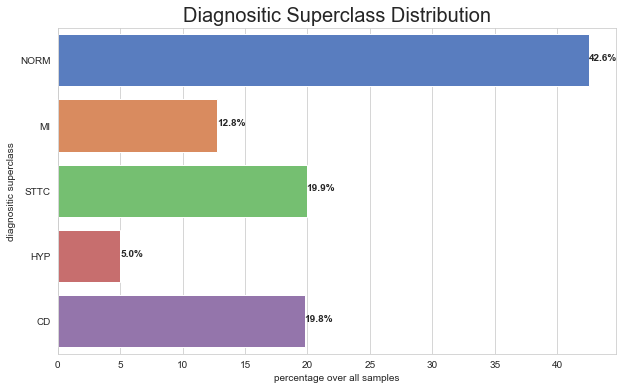

In [432]:
vc = y_all[superclass_cols].sum(axis=0)

sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x=vc.values/y_all.shape[0]*100., y=vc.index, ci=None, palette="muted",orient='h' )
ax.set_title("Diagnositic Superclass Distribution", fontsize=20)
ax.set_xlabel ("percentage over all samples")
ax.set_ylabel ("diagnositic superclass")
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )

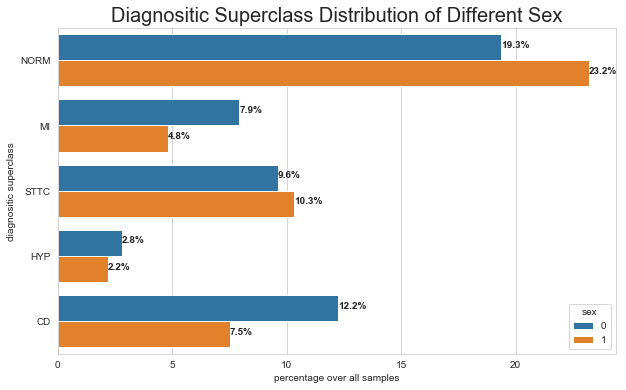

In [375]:
sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,6))
    
ax.set_title("Diagnositic Superclass Distribution of Different Sex", fontsize=20)

all_index, all_count, all_values = [], [], []
for sex in y_all.sex.unique():
    vc = y_all.loc[y_all.sex == sex][superclass_cols].sum(axis=0)
    all_index += list(vc.index)
    all_count += list(vc.values/y_all.shape[0]*100.)
    all_values += [sex]*len(vc)
    #print(all_sex)
    
df = pd.DataFrame()
df['diagnositic superclass'] = all_index
df['percentage over all samples'] = all_count
df['sex'] = all_values
    
ax = sns.barplot(data=df, x="percentage over all samples", y="diagnositic superclass", hue="sex",ci=None, orient='h')
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold')

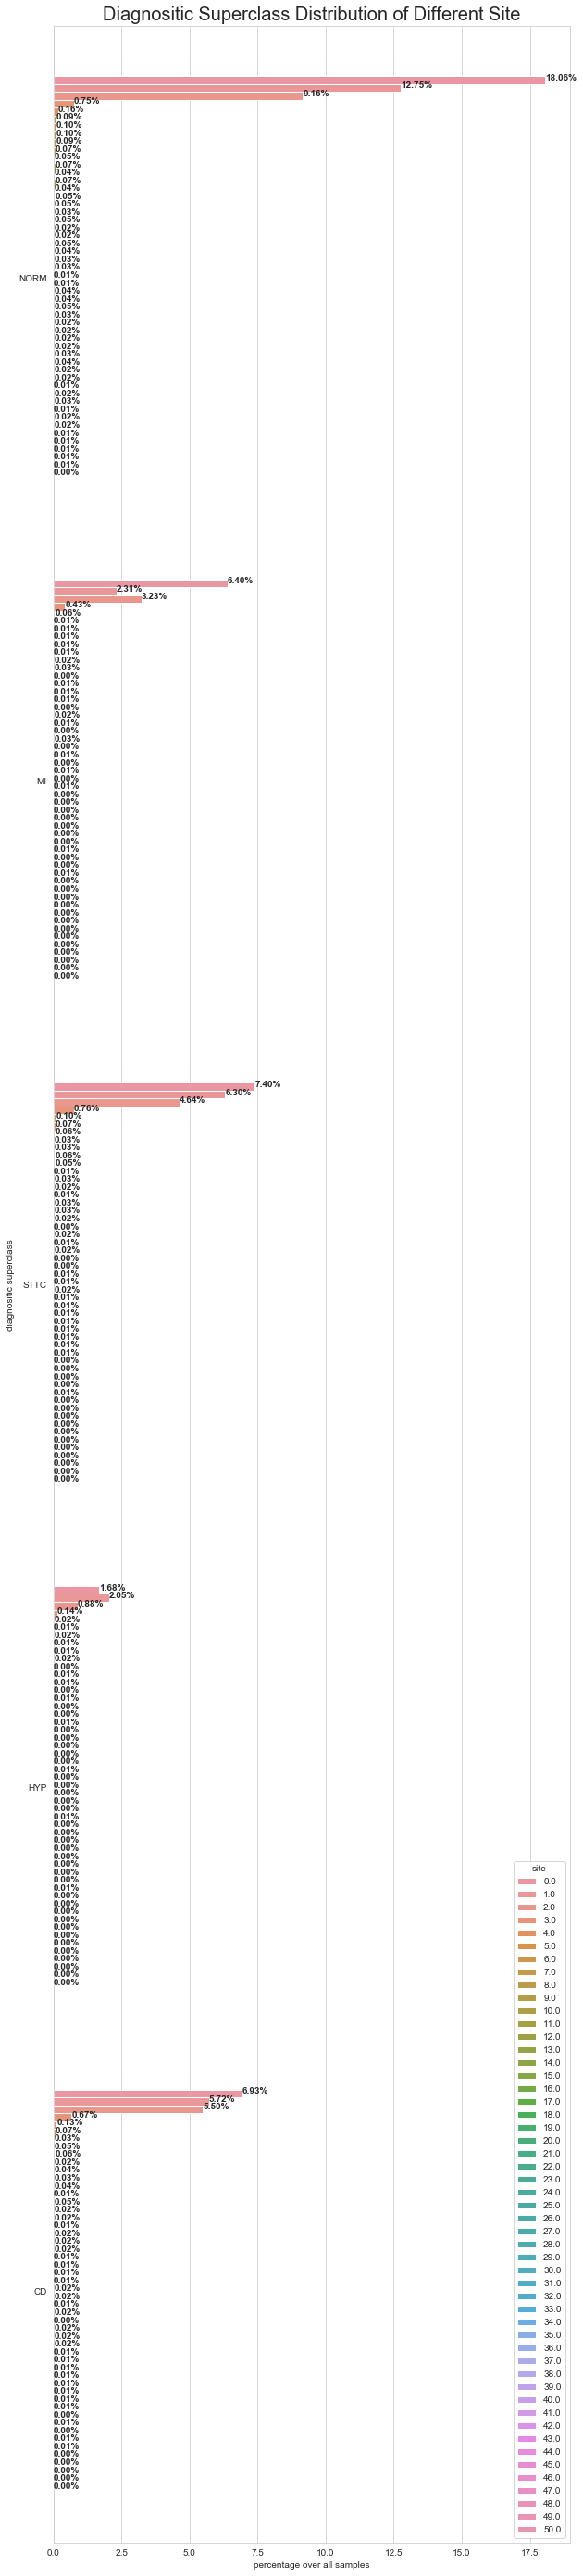

In [376]:
sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,50))
    
ax.set_title("Diagnositic Superclass Distribution of Different Site", fontsize=20)

all_index, all_count, all_values = [], [], []
for site in y_all.site.unique():
    vc = y_all.loc[y_all.site == site][superclass_cols].sum(axis=0)
    all_index += list(vc.index)
    all_count += list(vc.values/y_all.shape[0]*100.)
    all_values += [site]*len(vc)
    #print(all_sex)
    
df = pd.DataFrame()
df['diagnositic superclass'] = all_index
df['percentage over all samples'] = all_count
df['site'] = all_values
    
ax = sns.barplot(data=df, x="percentage over all samples", y="diagnositic superclass", hue="site",ci=None, orient='h')
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.2f%%"% rect.get_width(), weight='bold')

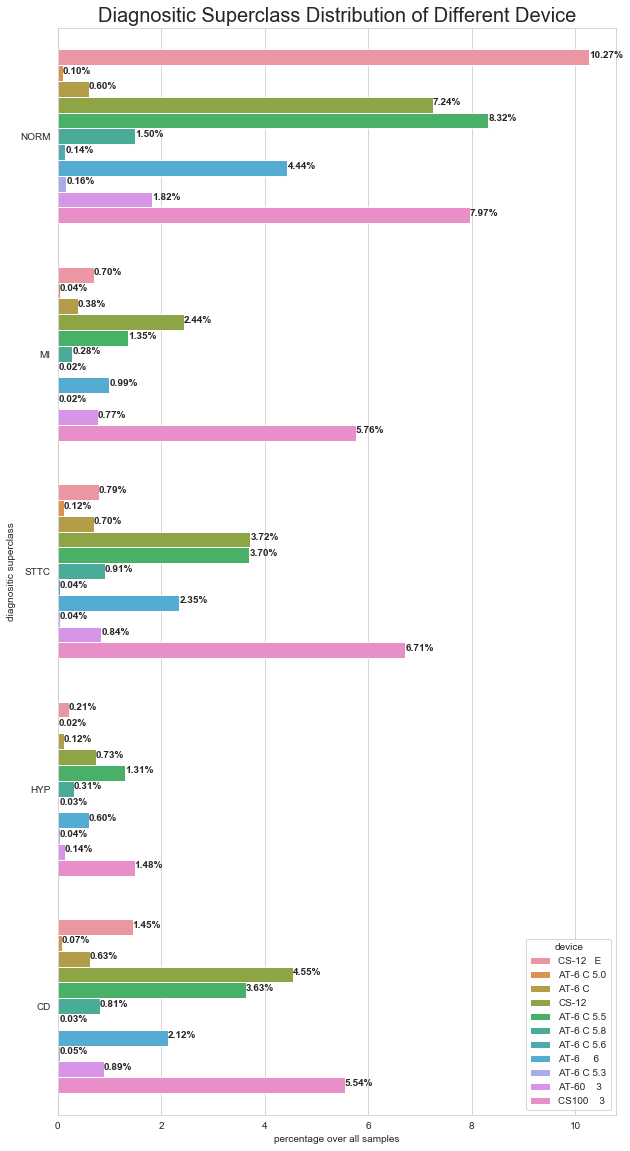

In [377]:
sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,20))
    
ax.set_title("Diagnositic Superclass Distribution of Different Device", fontsize=20)

all_index, all_count, all_values = [], [], []
for device in y_all.device.unique():
    vc = y_all.loc[y_all.device == device][superclass_cols].sum(axis=0)
    all_index += list(vc.index)
    all_count += list(vc.values/y_all.shape[0]*100.)
    all_values += [device]*len(vc)
    #print(all_sex)
    
df = pd.DataFrame()
df['diagnositic superclass'] = all_index
df['percentage over all samples'] = all_count
df['device'] = all_values

ax = sns.barplot(data=df, x="percentage over all samples", y="diagnositic superclass", hue="device",ci=None, orient='h')
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.2f%%"% rect.get_width(), weight='bold')

> Vamos a analizar los conocidos **missing values**:

In [433]:
def missing_values(df):
    missing_variables = []
    df_aux = df.isna()
    var = []
    for f in df.columns:
        missings_rows = df_aux[df_aux[f] == True][f].count()
        if missings_rows > 0:
            missing_variables.append(f)
            missings_perc = missings_rows/df.shape[0]
            print('La variable {} tiene {} registro/s ({:.2%}) con valores nulos'.format(f, missings_rows, missings_perc))
            var.append(f)
    return var

In [434]:
var_y_all = missing_values(y_all)

La variable age tiene 85 registro/s (0.40%) con valores nulos
La variable height tiene 14503 registro/s (67.68%) con valores nulos
La variable weight tiene 12056 registro/s (56.26%) con valores nulos
La variable nurse tiene 1479 registro/s (6.90%) con valores nulos
La variable site tiene 17 registro/s (0.08%) con valores nulos


In [435]:
y_all.isnull().sum()

age                     85
sex                      0
height               14503
weight               12056
nurse                 1479
site                    17
NORM                     0
MI                       0
STTC                     0
HYP                      0
CD                       0
strat_fold               0
device_AT-6     6        0
device_AT-6 C            0
device_AT-6 C 5.0        0
device_AT-6 C 5.3        0
device_AT-6 C 5.5        0
device_AT-6 C 5.6        0
device_AT-6 C 5.8        0
device_AT-60    3        0
device_CS-12             0
device_CS-12   E         0
device_CS100    3        0
dtype: int64

In [436]:
y_all['nurse'].unique()

array([ 2.,  0., nan,  1.,  7.,  8., 10.,  5.,  9., 11.,  4.,  3.,  6.])

In [437]:
y_all['site'].unique()

array([ 0.,  3.,  2.,  1., 35., 16.,  4., 39., 32., 17.,  9., 10., 34.,
       44., 11., 30., 36., 13.,  5., 12., 38., 15., 25.,  8., 14., 20.,
       29., 24., 21., 26.,  6., 22., 18., 28., 45., 41., 49., 40., 37.,
       27., 43.,  7., 19., 48., 42., 33., 23., nan, 46., 50., 47., 31.])

No tendremos en cuenta ni la altura ni el peso ya que el porcentaje de valores nulos es extremadamente alto, y es díficil predecir o sustituir esos valores sin afectar a los modelos que se crearán a continuación.

In [439]:
y_all.head(10)

age  sex  height  weight  nurse  site  NORM  MI  STTC  HYP  ...  \
ecg_id                                                               ...   
1       56.0    1     NaN    63.0    2.0   0.0     1   0     0    0  ...   
2       19.0    0     NaN    70.0    2.0   0.0     1   0     0    0  ...   
3       37.0    1     NaN    69.0    2.0   0.0     1   0     0    0  ...   
4       24.0    0     NaN    82.0    2.0   0.0     1   0     0    0  ...   
5       19.0    1     NaN    70.0    2.0   0.0     1   0     0    0  ...   
6       18.0    1     NaN    58.0    2.0   0.0     1   0     0    0  ...   
7       54.0    0     NaN    83.0    2.0   0.0     1   0     0    0  ...   
8       48.0    0     NaN    95.0    2.0   0.0     0   1     0    0  ...   
9       55.0    0     NaN    70.0    2.0   0.0     1   0     0    0  ...   
10      22.0    1     NaN    56.0    2.0   0.0     1   0     0    0  ...   

        device_AT-6 C  device_AT-6 C 5.0  device_AT-6 C 5.3  \
ecg_id                                                        
1                   0                  0                  0   
2                   0                  0                  0   
3                   0                  0                  0   
4                   0                  0                  0   
5                   0                  0                  0   
6                   0                  0                  0   
7                   0                  0                  0   
8                   0                  0                  0   
9                   0                  0                  0   
10                  0                  0                  0   

        device_AT-6 C 5.5  device_AT-6 C 5.6  device_AT-6 C 5.8  \
ecg_id                                                            
1                       0                  0                  0   
2                       0                  0                  0   
3                       0                  0                  0   
4                       0                  0                  0   
5                       0                  0                  0   
6                       0                  0                  0   
7                       0                  0                  0   
8                       0                  0                  0   
9                       0                  0                  0   
10                      0                  0                  0   

        device_AT-60    3  device_CS-12  device_CS-12   E  device_CS100    3  
ecg_id                                                                        
1                       0             0                 1                  0  
2                       0             0                 1                  0  
3                       0             0                 1                  0  
4                       0             0                 1                  0  
5                       0             0                 1                  0  
6                       0             0                 1                  0  
7                       0             0                 1                  0  
8                       0             0                 1                  0  
9                       0             0                 1                  0  
10                      0             0                 1                  0  

[10 rows x 23 columns]

In [440]:
y_all['age'].dtype

dtype('float64')

In [442]:
y_all.columns

Index(['age', 'sex', 'height', 'weight', 'nurse', 'site', 'NORM', 'MI', 'STTC',
       'HYP', 'CD', 'strat_fold', 'device_AT-6     6', 'device_AT-6 C',
       'device_AT-6 C 5.0', 'device_AT-6 C 5.3', 'device_AT-6 C 5.5',
       'device_AT-6 C 5.6', 'device_AT-6 C 5.8', 'device_AT-60    3',
       'device_CS-12', 'device_CS-12   E', 'device_CS100    3'],
      dtype='object')

In [457]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

def predicting_missing_values (variable, dataframe):

    data_with_null = dataframe[[variable, 'age', 'sex', 'nurse', 'device_AT-6 C', 'device_AT-6     6', 'device_AT-6 C 5.0', 
                            'device_AT-6 C 5.3', 'device_AT-6 C 5.5', 'device_AT-6 C 5.6', 'device_AT-6 C 5.8', 
                            'device_AT-60    3', 'device_CS-12', 'device_CS-12   E', 'device_CS100    3']];

    data_without_null = data_with_null.dropna();

    # All features except AGE
    train_data_x = data_without_null.iloc[:,1:15];

    #Only AGE
    train_data_y = data_without_null.iloc[:,0];

    # Training data
    linreg.fit(train_data_x, train_data_y)

    # Predicting values
    test_data = data_with_null.iloc[:,1:15];
    age_predicted = pd.Series(np.round(linreg.predict(test_data)))

    # Replacing missing values
    data_with_null.site.fillna(age_predicted, inplace=True)
    
    return data_with_null


In [458]:
data_with_null = predicting_missing_values ('site', y_all)

In [459]:
data_with_null.isnull().sum()

site                 0
age                  0
sex                  0
nurse                0
device_AT-6 C        0
device_AT-6     6    0
device_AT-6 C 5.0    0
device_AT-6 C 5.3    0
device_AT-6 C 5.5    0
device_AT-6 C 5.6    0
device_AT-6 C 5.8    0
device_AT-60    3    0
device_CS-12         0
device_CS-12   E     0
device_CS100    3    0
dtype: int64

In [461]:
y_all.site = data_with_null.site
y_all.isnull().sum()

age                      0
sex                      0
height               14503
weight               12056
nurse                    0
site                     0
NORM                     0
MI                       0
STTC                     0
HYP                      0
CD                       0
strat_fold               0
device_AT-6     6        0
device_AT-6 C            0
device_AT-6 C 5.0        0
device_AT-6 C 5.3        0
device_AT-6 C 5.5        0
device_AT-6 C 5.6        0
device_AT-6 C 5.8        0
device_AT-60    3        0
device_CS-12             0
device_CS-12   E         0
device_CS100    3        0
dtype: int64

In [463]:
y_all.columns

Index(['age', 'sex', 'height', 'weight', 'nurse', 'site', 'NORM', 'MI', 'STTC',
       'HYP', 'CD', 'strat_fold', 'device_AT-6     6', 'device_AT-6 C',
       'device_AT-6 C 5.0', 'device_AT-6 C 5.3', 'device_AT-6 C 5.5',
       'device_AT-6 C 5.6', 'device_AT-6 C 5.8', 'device_AT-60    3',
       'device_CS-12', 'device_CS-12   E', 'device_CS100    3'],
      dtype='object')

In [464]:
y_all = y_all.drop(['height', 'weight'], axis=1)
y_all.columns

Index(['age', 'sex', 'nurse', 'site', 'NORM', 'MI', 'STTC', 'HYP', 'CD',
       'strat_fold', 'device_AT-6     6', 'device_AT-6 C', 'device_AT-6 C 5.0',
       'device_AT-6 C 5.3', 'device_AT-6 C 5.5', 'device_AT-6 C 5.6',
       'device_AT-6 C 5.8', 'device_AT-60    3', 'device_CS-12',
       'device_CS-12   E', 'device_CS100    3'],
      dtype='object')

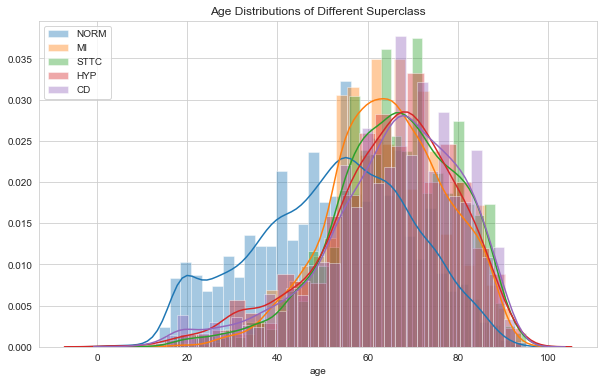

In [465]:
fig, ax = plt.subplots(figsize=(10,6))
plt.title('Age Distributions of Different Superclass')

for superclass in superclass_cols:
    data = y_all.loc[y_all[superclass] == 1]['age']   
    sns.distplot(data, label=superclass)


plt.legend(loc='upper left')
plt.show()

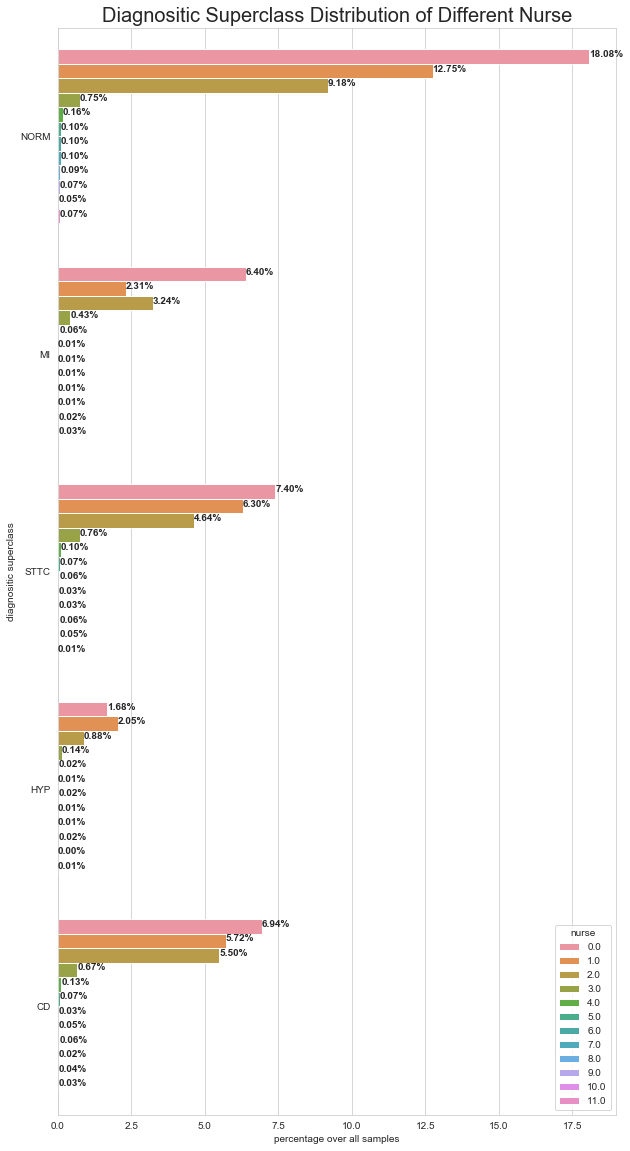

In [474]:
sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,20))
    
ax.set_title("Diagnositic Superclass Distribution of Different Nurse", fontsize=20)

all_index, all_count, all_values = [], [], []
for nurse in y_all.nurse.unique():
    vc = y_all.loc[y_all.site == nurse][superclass_cols].sum(axis=0)
    all_index += list(vc.index)
    all_count += list(vc.values/y_all.shape[0]*100.)
    all_values += [nurse]*len(vc)
    #print(all_sex)
    
df = pd.DataFrame()
df['diagnositic superclass'] = all_index
df['percentage over all samples'] = all_count
df['nurse'] = all_values
    
ax = sns.barplot(data=df, x="percentage over all samples", y="diagnositic superclass", hue="nurse",ci=None, orient='h')
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.2f%%"% rect.get_width(), weight='bold')

In [475]:
y_all.head(5)

age  sex  nurse  site  NORM  MI  STTC  HYP  CD  strat_fold  ...  \
ecg_id                                                               ...   
1       56.0    1    2.0   0.0     1   0     0    0   0           3  ...   
2       19.0    0    2.0   0.0     1   0     0    0   0           2  ...   
3       37.0    1    2.0   0.0     1   0     0    0   0           5  ...   
4       24.0    0    2.0   0.0     1   0     0    0   0           3  ...   
5       19.0    1    2.0   0.0     1   0     0    0   0           4  ...   

        device_AT-6 C  device_AT-6 C 5.0  device_AT-6 C 5.3  \
ecg_id                                                        
1                   0                  0                  0   
2                   0                  0                  0   
3                   0                  0                  0   
4                   0                  0                  0   
5                   0                  0                  0   

        device_AT-6 C 5.5  device_AT-6 C 5.6  device_AT-6 C 5.8  \
ecg_id                                                            
1                       0                  0                  0   
2                       0                  0                  0   
3                       0                  0                  0   
4                       0                  0                  0   
5                       0                  0                  0   

        device_AT-60    3  device_CS-12  device_CS-12   E  device_CS100    3  
ecg_id                                                                        
1                       0             0                 1                  0  
2                       0             0                 1                  0  
3                       0             0                 1                  0  
4                       0             0                 1                  0  
5                       0             0                 1                  0  

[5 rows x 21 columns]

In [476]:
def transform_float_int(df):
    var = df.columns
    for variant in var:
        if df[variant].dtype == 'float64':
            df[variant] = df[variant].astype('int64')
    return df

In [478]:
y_all = transform_float_int(y_all)
y_all.head(5)

age  sex  nurse  site  NORM  MI  STTC  HYP  CD  strat_fold  ...  \
ecg_id                                                              ...   
1        56    1      2     0     1   0     0    0   0           3  ...   
2        19    0      2     0     1   0     0    0   0           2  ...   
3        37    1      2     0     1   0     0    0   0           5  ...   
4        24    0      2     0     1   0     0    0   0           3  ...   
5        19    1      2     0     1   0     0    0   0           4  ...   

        device_AT-6 C  device_AT-6 C 5.0  device_AT-6 C 5.3  \
ecg_id                                                        
1                   0                  0                  0   
2                   0                  0                  0   
3                   0                  0                  0   
4                   0                  0                  0   
5                   0                  0                  0   

        device_AT-6 C 5.5  device_AT-6 C 5.6  device_AT-6 C 5.8  \
ecg_id                                                            
1                       0                  0                  0   
2                       0                  0                  0   
3                       0                  0                  0   
4                       0                  0                  0   
5                       0                  0                  0   

        device_AT-60    3  device_CS-12  device_CS-12   E  device_CS100    3  
ecg_id                                                                        
1                       0             0                 1                  0  
2                       0             0                 1                  0  
3                       0             0                 1                  0  
4                       0             0                 1                  0  
5                       0             0                 1                  0  

[5 rows x 21 columns]

In [479]:
np.savetxt(path+"y_all_for_graphs.csv", y_all, delimiter=",")

In [480]:
y_all.columns

Index(['age', 'sex', 'nurse', 'site', 'NORM', 'MI', 'STTC', 'HYP', 'CD',
       'strat_fold', 'device_AT-6     6', 'device_AT-6 C', 'device_AT-6 C 5.0',
       'device_AT-6 C 5.3', 'device_AT-6 C 5.5', 'device_AT-6 C 5.6',
       'device_AT-6 C 5.8', 'device_AT-60    3', 'device_CS-12',
       'device_CS-12   E', 'device_CS100    3'],
      dtype='object')

In [481]:
y_all = y_all.drop(['NORM', 'MI', 'STTC', 'HYP', 'CD'], axis=1)
y_all.columns

Index(['age', 'sex', 'nurse', 'site', 'strat_fold', 'device_AT-6     6',
       'device_AT-6 C', 'device_AT-6 C 5.0', 'device_AT-6 C 5.3',
       'device_AT-6 C 5.5', 'device_AT-6 C 5.6', 'device_AT-6 C 5.8',
       'device_AT-60    3', 'device_CS-12', 'device_CS-12   E',
       'device_CS100    3'],
      dtype='object')

**Creating more features for the model based on signal characteristics:**

### STEP 2: SELECTING CHARACTERISTICS TO ENTER INTO THE MODEL...

#### Feature selection based on an article features.... t = 4,8 & 10 seg

> Comenzamos con la obtención de los features con señales de duración de t = 10 segundos:

In [484]:
# feature-ak kalkulatzeko seinalearen zenbateko denbora erabiliko den
from scipy.signal import butter, lfilter
t  = 10 
fs = 100
nyq = 2 / fs
low = 0.5 * nyq
high = 30 * nyq
b, a = butter(4, [low, high], 'bandpass');
verbose = 0;
n = t*fs;
# Erabiliko dugun seinalearen tartea:

In [485]:
print(np.round(b,4))
print(np.round(a,4))
print(n)
print(b)
print(a)

[ 0.1585  0.     -0.6339  0.      0.9508  0.     -0.6339  0.      0.1585]
[ 1.     -3.1568  3.4526 -1.8567  1.2998 -0.9524  0.1373  0.0484  0.0276]
1000
[ 0.1584654   0.         -0.63386159  0.          0.95079239  0.
 -0.63386159  0.          0.1584654 ]
[ 1.         -3.15677048  3.45261035 -1.85665683  1.29984166 -0.95237249
  0.13728623  0.0484168   0.02764735]


In [486]:
from functions import *
#from compute_features import *
np.warnings.filterwarnings('ignore')

features = [];

def process(i):
    
    try:
    
        print(i)
        x = [];
        features = np.ones(32);
        s_ecg = data_100_upd_I_lead[i];
        #set_trace()
        s_ecg  = filtfilt(b,a,s_ecg, axis=0, padtype = 'odd', padlen=3*(max(len(b),len(a))-1));
        s_in = s_ecg[0:n]  # Analisirako tartea hartu
        #for sig in s_in:
            #for z in sig:
                #x.append(z)

        # Feature-en kalkulua
        x = s_in;
        x                        = np.array(x);
        idx = i;
        #idx = 'id_'+str(i);
        features[0] = idx;
        # COUNT
        c1, c2, c3b              = calculate_COUNT(x,fs);  
        c1 = np.round(c1,3); c2  = np.round(c2,3); c3b = np.round(c3b,3);
        features[1] = c1; features[2] = c2; features[3] = c3b;

        parameters               = calculate_CM_JEKOVA(x,fs,8);
        parameters               = np.round(parameters,3);
        features[4] = parameters[0]; features[5] = parameters[1]; features[6] = parameters[2]; 
        features[7] = parameters[3]; features[8] = parameters[4]; 

        N                        = calculate_EXP(x,fs);
        N                        = np.round(N,3);
        features[9] = N;

        N_expmod                 = calculate_EXPMOD(x,fs);
        N_expmod                 = np.round(N_expmod,3);
        features[10] = N_expmod;

        mav                      = calculate_MAV(x,fs);
        mav                      = np.round(mav,3);
        features[11] = mav;

        Npeak, stdAmpPeak, stdRR = calculate_peaks(x,fs);
        Npeak                    = np.round(Npeak,3);
        stdAmpPeak               = np.round(stdAmpPeak,3);
        stdRR                    = np.round(stdRR,3);
        features[12] = Npeak; features[13] = stdAmpPeak; features[14] = stdRR;

        psr,hilb                 =calculate_PSR_HILB(x,fs);
        psr                      = np.round(psr,3);
        hilb                     = np.round(hilb,3);
        features[15] = psr; features[16] = hilb;

        bCP, bWT                 = calculate_RESUS(x,fs);
        bCP                      = np.round(bCP,3);
        bWT                      = np.round(bWT,3);
        features[17] = bCP; features[18] = bWT;

        m = 2; r=0.2*statistics.stdev(x);

        #res                      = calculate_SampEn(x,m,r);
        #res                      = np.round(res,3);
        #features.append(res);

        spec                     = calculate_SPEC(x,fs);
        spec                     = np.round(spec,3);
        features[19] = spec[0]; features[20] = spec[1]; 
        features[21] = spec[2]; features[22] = spec[3];

        wL = 4;

        tci                      = calculate_TCI(x,fs,wL);
        tci                      = np.round(tci,3);
        features[23] = tci;

        tcsc                     = calculate_TCSC(x,fs);
        tcsc                     = np.round(tcsc,3);
        features[24] = tcsc;

        vfleak                   = calculate_VFLEAK(x);
        vfleak                   = np.round(vfleak,3);
        features[25] = vfleak;

        x1, x2                   = calculate_Xj(x,fs);
        x1                       = np.round(x1,3);
        x2                       = np.round(x2,3);
        features[26] = x1; features[27] = x2;

        x3, x4, x5               = calculate_Xi(x,fs);
        x3                       = np.round(x3,3);
        x4                       = np.round(x4,3);
        x5                       = np.round(x5,3);
        features[28] = x3; features[29] = x4; features[30] = x5;

        t_win = 4;

        Li                       = calculate_Li(x, fs, t_win);
        Li                       = np.round(Li,3);
        features[31] = Li;

        features = np.array(features).flatten();

        name = 'features_sv';

        with open(path+'features_10_I_lead.pickle', 'ab') as name:
            pickle.dump(features, name)
        name.close();
        
    except:   
        
        print('Error in signal number ',i);
        
        with open(path+'sig_error_10_I_lead.pickle', 'ab') as sig_error_sv:
            pickle.dump(i, sig_error_sv)
        sig_error_sv.close();

    return features

In [487]:
len(data_100_upd_I_lead)

21430

In [488]:
for idx in np.arange(len(data_100_upd_I_lead)):
    process(idx);
    print("CASE ", idx, "completed.");

0
CASE  0 completed.
1
CASE  1 completed.
2
CASE  2 completed.
3
CASE  3 completed.
4
CASE  4 completed.
5
CASE  5 completed.
6
CASE  6 completed.
7
CASE  7 completed.
8
CASE  8 completed.
9
CASE  9 completed.
10
CASE  10 completed.
11
CASE  11 completed.
12
CASE  12 completed.
13
CASE  13 completed.
14
CASE  14 completed.
15
CASE  15 completed.
16
CASE  16 completed.
17
CASE  17 completed.
18
CASE  18 completed.
19
CASE  19 completed.
20
CASE  20 completed.
21
CASE  21 completed.
22
CASE  22 completed.
23
CASE  23 completed.
24
CASE  24 completed.
25
CASE  25 completed.
26
CASE  26 completed.
27
CASE  27 completed.
28
CASE  28 completed.
29
CASE  29 completed.
30
CASE  30 completed.
31
CASE  31 completed.
32
CASE  32 completed.
33
CASE  33 completed.
34
CASE  34 completed.
35
CASE  35 completed.
36
CASE  36 completed.
37
CASE  37 completed.
38
CASE  38 completed.
39
CASE  39 completed.
40
CASE  40 completed.
41
CASE  41 completed.
42
CASE  42 completed.
43
CASE  43 completed.
44
CASE 

CASE  338 completed.
339
CASE  339 completed.
340
CASE  340 completed.
341
CASE  341 completed.
342
CASE  342 completed.
343
CASE  343 completed.
344
CASE  344 completed.
345
CASE  345 completed.
346
CASE  346 completed.
347
CASE  347 completed.
348
CASE  348 completed.
349
CASE  349 completed.
350
CASE  350 completed.
351
CASE  351 completed.
352
CASE  352 completed.
353
CASE  353 completed.
354
CASE  354 completed.
355
CASE  355 completed.
356
CASE  356 completed.
357
CASE  357 completed.
358
CASE  358 completed.
359
CASE  359 completed.
360
CASE  360 completed.
361
CASE  361 completed.
362
CASE  362 completed.
363
CASE  363 completed.
364
CASE  364 completed.
365
CASE  365 completed.
366
CASE  366 completed.
367
CASE  367 completed.
368
CASE  368 completed.
369
CASE  369 completed.
370
CASE  370 completed.
371
CASE  371 completed.
372
CASE  372 completed.
373
CASE  373 completed.
374
CASE  374 completed.
375
CASE  375 completed.
376
CASE  376 completed.
377
CASE  377 completed.
378


CASE  666 completed.
667
CASE  667 completed.
668
CASE  668 completed.
669
CASE  669 completed.
670
CASE  670 completed.
671
CASE  671 completed.
672
CASE  672 completed.
673
CASE  673 completed.
674
CASE  674 completed.
675
CASE  675 completed.
676
CASE  676 completed.
677
CASE  677 completed.
678
CASE  678 completed.
679
CASE  679 completed.
680
CASE  680 completed.
681
CASE  681 completed.
682
CASE  682 completed.
683
CASE  683 completed.
684
CASE  684 completed.
685
CASE  685 completed.
686
CASE  686 completed.
687
CASE  687 completed.
688
CASE  688 completed.
689
CASE  689 completed.
690
CASE  690 completed.
691
CASE  691 completed.
692
CASE  692 completed.
693
CASE  693 completed.
694
CASE  694 completed.
695
CASE  695 completed.
696
CASE  696 completed.
697
CASE  697 completed.
698
CASE  698 completed.
699
CASE  699 completed.
700
CASE  700 completed.
701
CASE  701 completed.
702
CASE  702 completed.
703
CASE  703 completed.
704
CASE  704 completed.
705
CASE  705 completed.
706


CASE  995 completed.
996
CASE  996 completed.
997
CASE  997 completed.
998
CASE  998 completed.
999
CASE  999 completed.
1000
CASE  1000 completed.
1001
CASE  1001 completed.
1002
CASE  1002 completed.
1003
CASE  1003 completed.
1004
CASE  1004 completed.
1005
CASE  1005 completed.
1006
CASE  1006 completed.
1007
CASE  1007 completed.
1008
CASE  1008 completed.
1009
CASE  1009 completed.
1010
CASE  1010 completed.
1011
CASE  1011 completed.
1012
CASE  1012 completed.
1013
CASE  1013 completed.
1014
CASE  1014 completed.
1015
CASE  1015 completed.
1016
CASE  1016 completed.
1017
CASE  1017 completed.
1018
CASE  1018 completed.
1019
CASE  1019 completed.
1020
CASE  1020 completed.
1021
CASE  1021 completed.
1022
CASE  1022 completed.
1023
CASE  1023 completed.
1024
CASE  1024 completed.
1025
CASE  1025 completed.
1026
CASE  1026 completed.
1027
CASE  1027 completed.
1028
CASE  1028 completed.
1029
CASE  1029 completed.
1030
CASE  1030 completed.
1031
CASE  1031 completed.
1032
CASE  1032

CASE  1299 completed.
1300
CASE  1300 completed.
1301
CASE  1301 completed.
1302
CASE  1302 completed.
1303
CASE  1303 completed.
1304
CASE  1304 completed.
1305
CASE  1305 completed.
1306
CASE  1306 completed.
1307
CASE  1307 completed.
1308
CASE  1308 completed.
1309
CASE  1309 completed.
1310
CASE  1310 completed.
1311
CASE  1311 completed.
1312
CASE  1312 completed.
1313
CASE  1313 completed.
1314
CASE  1314 completed.
1315
CASE  1315 completed.
1316
CASE  1316 completed.
1317
CASE  1317 completed.
1318
CASE  1318 completed.
1319
CASE  1319 completed.
1320
CASE  1320 completed.
1321
CASE  1321 completed.
1322
CASE  1322 completed.
1323
CASE  1323 completed.
1324
CASE  1324 completed.
1325
CASE  1325 completed.
1326
CASE  1326 completed.
1327
CASE  1327 completed.
1328
CASE  1328 completed.
1329
CASE  1329 completed.
1330
CASE  1330 completed.
1331
CASE  1331 completed.
1332
CASE  1332 completed.
1333
CASE  1333 completed.
1334
CASE  1334 completed.
1335
CASE  1335 completed.
1336
C

CASE  1603 completed.
1604
CASE  1604 completed.
1605
CASE  1605 completed.
1606
CASE  1606 completed.
1607
CASE  1607 completed.
1608
CASE  1608 completed.
1609
CASE  1609 completed.
1610
CASE  1610 completed.
1611
CASE  1611 completed.
1612
CASE  1612 completed.
1613
CASE  1613 completed.
1614
CASE  1614 completed.
1615
CASE  1615 completed.
1616
CASE  1616 completed.
1617
CASE  1617 completed.
1618
CASE  1618 completed.
1619
CASE  1619 completed.
1620
CASE  1620 completed.
1621
CASE  1621 completed.
1622
CASE  1622 completed.
1623
CASE  1623 completed.
1624
CASE  1624 completed.
1625
CASE  1625 completed.
1626
CASE  1626 completed.
1627
CASE  1627 completed.
1628
CASE  1628 completed.
1629
CASE  1629 completed.
1630
CASE  1630 completed.
1631
CASE  1631 completed.
1632
CASE  1632 completed.
1633
CASE  1633 completed.
1634
CASE  1634 completed.
1635
CASE  1635 completed.
1636
CASE  1636 completed.
1637
CASE  1637 completed.
1638
CASE  1638 completed.
1639
CASE  1639 completed.
1640
C

CASE  1907 completed.
1908
CASE  1908 completed.
1909
CASE  1909 completed.
1910
CASE  1910 completed.
1911
CASE  1911 completed.
1912
CASE  1912 completed.
1913
CASE  1913 completed.
1914
CASE  1914 completed.
1915
CASE  1915 completed.
1916
CASE  1916 completed.
1917
CASE  1917 completed.
1918
CASE  1918 completed.
1919
CASE  1919 completed.
1920
CASE  1920 completed.
1921
CASE  1921 completed.
1922
CASE  1922 completed.
1923
CASE  1923 completed.
1924
CASE  1924 completed.
1925
CASE  1925 completed.
1926
CASE  1926 completed.
1927
CASE  1927 completed.
1928
CASE  1928 completed.
1929
CASE  1929 completed.
1930
CASE  1930 completed.
1931
CASE  1931 completed.
1932
CASE  1932 completed.
1933
CASE  1933 completed.
1934
CASE  1934 completed.
1935
CASE  1935 completed.
1936
CASE  1936 completed.
1937
CASE  1937 completed.
1938
CASE  1938 completed.
1939
CASE  1939 completed.
1940
CASE  1940 completed.
1941
CASE  1941 completed.
1942
CASE  1942 completed.
1943
CASE  1943 completed.
1944
C

CASE  2211 completed.
2212
CASE  2212 completed.
2213
CASE  2213 completed.
2214
CASE  2214 completed.
2215
CASE  2215 completed.
2216
CASE  2216 completed.
2217
CASE  2217 completed.
2218
CASE  2218 completed.
2219
CASE  2219 completed.
2220
CASE  2220 completed.
2221
CASE  2221 completed.
2222
CASE  2222 completed.
2223
CASE  2223 completed.
2224
CASE  2224 completed.
2225
CASE  2225 completed.
2226
CASE  2226 completed.
2227
CASE  2227 completed.
2228
CASE  2228 completed.
2229
CASE  2229 completed.
2230
CASE  2230 completed.
2231
CASE  2231 completed.
2232
CASE  2232 completed.
2233
CASE  2233 completed.
2234
CASE  2234 completed.
2235
CASE  2235 completed.
2236
CASE  2236 completed.
2237
CASE  2237 completed.
2238
CASE  2238 completed.
2239
CASE  2239 completed.
2240
CASE  2240 completed.
2241
CASE  2241 completed.
2242
CASE  2242 completed.
2243
CASE  2243 completed.
2244
CASE  2244 completed.
2245
CASE  2245 completed.
2246
CASE  2246 completed.
2247
CASE  2247 completed.
2248
C

CASE  2515 completed.
2516
CASE  2516 completed.
2517
CASE  2517 completed.
2518
CASE  2518 completed.
2519
CASE  2519 completed.
2520
CASE  2520 completed.
2521
CASE  2521 completed.
2522
CASE  2522 completed.
2523
CASE  2523 completed.
2524
CASE  2524 completed.
2525
CASE  2525 completed.
2526
CASE  2526 completed.
2527
CASE  2527 completed.
2528
CASE  2528 completed.
2529
CASE  2529 completed.
2530
CASE  2530 completed.
2531
CASE  2531 completed.
2532
CASE  2532 completed.
2533
CASE  2533 completed.
2534
CASE  2534 completed.
2535
CASE  2535 completed.
2536
CASE  2536 completed.
2537
CASE  2537 completed.
2538
CASE  2538 completed.
2539
CASE  2539 completed.
2540
CASE  2540 completed.
2541
CASE  2541 completed.
2542
CASE  2542 completed.
2543
CASE  2543 completed.
2544
CASE  2544 completed.
2545
CASE  2545 completed.
2546
CASE  2546 completed.
2547
CASE  2547 completed.
2548
CASE  2548 completed.
2549
CASE  2549 completed.
2550
CASE  2550 completed.
2551
CASE  2551 completed.
2552
C

CASE  2819 completed.
2820
CASE  2820 completed.
2821
CASE  2821 completed.
2822
CASE  2822 completed.
2823
CASE  2823 completed.
2824
CASE  2824 completed.
2825
CASE  2825 completed.
2826
CASE  2826 completed.
2827
CASE  2827 completed.
2828
CASE  2828 completed.
2829
CASE  2829 completed.
2830
CASE  2830 completed.
2831
CASE  2831 completed.
2832
CASE  2832 completed.
2833
CASE  2833 completed.
2834
CASE  2834 completed.
2835
CASE  2835 completed.
2836
CASE  2836 completed.
2837
CASE  2837 completed.
2838
CASE  2838 completed.
2839
CASE  2839 completed.
2840
CASE  2840 completed.
2841
CASE  2841 completed.
2842
CASE  2842 completed.
2843
CASE  2843 completed.
2844
CASE  2844 completed.
2845
CASE  2845 completed.
2846
CASE  2846 completed.
2847
CASE  2847 completed.
2848
CASE  2848 completed.
2849
CASE  2849 completed.
2850
CASE  2850 completed.
2851
CASE  2851 completed.
2852
CASE  2852 completed.
2853
CASE  2853 completed.
2854
CASE  2854 completed.
2855
CASE  2855 completed.
2856
C

CASE  3123 completed.
3124
CASE  3124 completed.
3125
CASE  3125 completed.
3126
CASE  3126 completed.
3127
CASE  3127 completed.
3128
CASE  3128 completed.
3129
CASE  3129 completed.
3130
CASE  3130 completed.
3131
CASE  3131 completed.
3132
CASE  3132 completed.
3133
CASE  3133 completed.
3134
CASE  3134 completed.
3135
CASE  3135 completed.
3136
CASE  3136 completed.
3137
CASE  3137 completed.
3138
CASE  3138 completed.
3139
CASE  3139 completed.
3140
CASE  3140 completed.
3141
CASE  3141 completed.
3142
CASE  3142 completed.
3143
CASE  3143 completed.
3144
CASE  3144 completed.
3145
CASE  3145 completed.
3146
CASE  3146 completed.
3147
CASE  3147 completed.
3148
CASE  3148 completed.
3149
CASE  3149 completed.
3150
CASE  3150 completed.
3151
CASE  3151 completed.
3152
CASE  3152 completed.
3153
CASE  3153 completed.
3154
CASE  3154 completed.
3155
CASE  3155 completed.
3156
CASE  3156 completed.
3157
CASE  3157 completed.
3158
CASE  3158 completed.
3159
CASE  3159 completed.
3160
C

CASE  3427 completed.
3428
CASE  3428 completed.
3429
CASE  3429 completed.
3430
CASE  3430 completed.
3431
CASE  3431 completed.
3432
CASE  3432 completed.
3433
CASE  3433 completed.
3434
CASE  3434 completed.
3435
CASE  3435 completed.
3436
CASE  3436 completed.
3437
CASE  3437 completed.
3438
CASE  3438 completed.
3439
CASE  3439 completed.
3440
CASE  3440 completed.
3441
CASE  3441 completed.
3442
CASE  3442 completed.
3443
CASE  3443 completed.
3444
CASE  3444 completed.
3445
CASE  3445 completed.
3446
CASE  3446 completed.
3447
CASE  3447 completed.
3448
CASE  3448 completed.
3449
CASE  3449 completed.
3450
CASE  3450 completed.
3451
CASE  3451 completed.
3452
CASE  3452 completed.
3453
CASE  3453 completed.
3454
CASE  3454 completed.
3455
CASE  3455 completed.
3456
CASE  3456 completed.
3457
CASE  3457 completed.
3458
CASE  3458 completed.
3459
CASE  3459 completed.
3460
CASE  3460 completed.
3461
CASE  3461 completed.
3462
CASE  3462 completed.
3463
CASE  3463 completed.
3464
C

CASE  3731 completed.
3732
CASE  3732 completed.
3733
CASE  3733 completed.
3734
CASE  3734 completed.
3735
CASE  3735 completed.
3736
CASE  3736 completed.
3737
CASE  3737 completed.
3738
CASE  3738 completed.
3739
CASE  3739 completed.
3740
CASE  3740 completed.
3741
CASE  3741 completed.
3742
CASE  3742 completed.
3743
CASE  3743 completed.
3744
CASE  3744 completed.
3745
CASE  3745 completed.
3746
CASE  3746 completed.
3747
CASE  3747 completed.
3748
CASE  3748 completed.
3749
CASE  3749 completed.
3750
CASE  3750 completed.
3751
CASE  3751 completed.
3752
CASE  3752 completed.
3753
CASE  3753 completed.
3754
CASE  3754 completed.
3755
CASE  3755 completed.
3756
CASE  3756 completed.
3757
CASE  3757 completed.
3758
CASE  3758 completed.
3759
CASE  3759 completed.
3760
CASE  3760 completed.
3761
CASE  3761 completed.
3762
CASE  3762 completed.
3763
CASE  3763 completed.
3764
CASE  3764 completed.
3765
CASE  3765 completed.
3766
CASE  3766 completed.
3767
CASE  3767 completed.
3768
C

CASE  4035 completed.
4036
CASE  4036 completed.
4037
CASE  4037 completed.
4038
CASE  4038 completed.
4039
CASE  4039 completed.
4040
CASE  4040 completed.
4041
CASE  4041 completed.
4042
CASE  4042 completed.
4043
CASE  4043 completed.
4044
CASE  4044 completed.
4045
CASE  4045 completed.
4046
CASE  4046 completed.
4047
CASE  4047 completed.
4048
CASE  4048 completed.
4049
CASE  4049 completed.
4050
CASE  4050 completed.
4051
CASE  4051 completed.
4052
CASE  4052 completed.
4053
CASE  4053 completed.
4054
CASE  4054 completed.
4055
CASE  4055 completed.
4056
CASE  4056 completed.
4057
CASE  4057 completed.
4058
CASE  4058 completed.
4059
CASE  4059 completed.
4060
CASE  4060 completed.
4061
CASE  4061 completed.
4062
CASE  4062 completed.
4063
CASE  4063 completed.
4064
CASE  4064 completed.
4065
CASE  4065 completed.
4066
CASE  4066 completed.
4067
CASE  4067 completed.
4068
CASE  4068 completed.
4069
CASE  4069 completed.
4070
CASE  4070 completed.
4071
CASE  4071 completed.
4072
C

CASE  4339 completed.
4340
CASE  4340 completed.
4341
CASE  4341 completed.
4342
CASE  4342 completed.
4343
CASE  4343 completed.
4344
CASE  4344 completed.
4345
CASE  4345 completed.
4346
CASE  4346 completed.
4347
CASE  4347 completed.
4348
CASE  4348 completed.
4349
CASE  4349 completed.
4350
CASE  4350 completed.
4351
CASE  4351 completed.
4352
CASE  4352 completed.
4353
CASE  4353 completed.
4354
CASE  4354 completed.
4355
CASE  4355 completed.
4356
CASE  4356 completed.
4357
CASE  4357 completed.
4358
CASE  4358 completed.
4359
CASE  4359 completed.
4360
CASE  4360 completed.
4361
CASE  4361 completed.
4362
CASE  4362 completed.
4363
CASE  4363 completed.
4364
CASE  4364 completed.
4365
CASE  4365 completed.
4366
CASE  4366 completed.
4367
CASE  4367 completed.
4368
CASE  4368 completed.
4369
CASE  4369 completed.
4370
CASE  4370 completed.
4371
CASE  4371 completed.
4372
CASE  4372 completed.
4373
CASE  4373 completed.
4374
CASE  4374 completed.
4375
CASE  4375 completed.
4376
C

CASE  4643 completed.
4644
CASE  4644 completed.
4645
CASE  4645 completed.
4646
CASE  4646 completed.
4647
CASE  4647 completed.
4648
CASE  4648 completed.
4649
CASE  4649 completed.
4650
CASE  4650 completed.
4651
CASE  4651 completed.
4652
CASE  4652 completed.
4653
CASE  4653 completed.
4654
CASE  4654 completed.
4655
CASE  4655 completed.
4656
CASE  4656 completed.
4657
CASE  4657 completed.
4658
CASE  4658 completed.
4659
CASE  4659 completed.
4660
CASE  4660 completed.
4661
CASE  4661 completed.
4662
CASE  4662 completed.
4663
CASE  4663 completed.
4664
CASE  4664 completed.
4665
CASE  4665 completed.
4666
CASE  4666 completed.
4667
CASE  4667 completed.
4668
CASE  4668 completed.
4669
CASE  4669 completed.
4670
CASE  4670 completed.
4671
CASE  4671 completed.
4672
CASE  4672 completed.
4673
CASE  4673 completed.
4674
CASE  4674 completed.
4675
CASE  4675 completed.
4676
CASE  4676 completed.
4677
CASE  4677 completed.
4678
CASE  4678 completed.
4679
CASE  4679 completed.
4680
C

CASE  4947 completed.
4948
CASE  4948 completed.
4949
CASE  4949 completed.
4950
CASE  4950 completed.
4951
CASE  4951 completed.
4952
CASE  4952 completed.
4953
CASE  4953 completed.
4954
CASE  4954 completed.
4955
CASE  4955 completed.
4956
CASE  4956 completed.
4957
CASE  4957 completed.
4958
CASE  4958 completed.
4959
CASE  4959 completed.
4960
CASE  4960 completed.
4961
CASE  4961 completed.
4962
CASE  4962 completed.
4963
CASE  4963 completed.
4964
CASE  4964 completed.
4965
CASE  4965 completed.
4966
CASE  4966 completed.
4967
CASE  4967 completed.
4968
CASE  4968 completed.
4969
CASE  4969 completed.
4970
CASE  4970 completed.
4971
CASE  4971 completed.
4972
CASE  4972 completed.
4973
CASE  4973 completed.
4974
CASE  4974 completed.
4975
CASE  4975 completed.
4976
CASE  4976 completed.
4977
CASE  4977 completed.
4978
CASE  4978 completed.
4979
CASE  4979 completed.
4980
CASE  4980 completed.
4981
CASE  4981 completed.
4982
CASE  4982 completed.
4983
CASE  4983 completed.
4984
C

CASE  5251 completed.
5252
CASE  5252 completed.
5253
CASE  5253 completed.
5254
CASE  5254 completed.
5255
CASE  5255 completed.
5256
CASE  5256 completed.
5257
CASE  5257 completed.
5258
CASE  5258 completed.
5259
CASE  5259 completed.
5260
CASE  5260 completed.
5261
CASE  5261 completed.
5262
CASE  5262 completed.
5263
CASE  5263 completed.
5264
CASE  5264 completed.
5265
CASE  5265 completed.
5266
CASE  5266 completed.
5267
CASE  5267 completed.
5268
CASE  5268 completed.
5269
CASE  5269 completed.
5270
CASE  5270 completed.
5271
CASE  5271 completed.
5272
CASE  5272 completed.
5273
CASE  5273 completed.
5274
CASE  5274 completed.
5275
CASE  5275 completed.
5276
CASE  5276 completed.
5277
CASE  5277 completed.
5278
CASE  5278 completed.
5279
CASE  5279 completed.
5280
CASE  5280 completed.
5281
CASE  5281 completed.
5282
CASE  5282 completed.
5283
CASE  5283 completed.
5284
CASE  5284 completed.
5285
CASE  5285 completed.
5286
CASE  5286 completed.
5287
CASE  5287 completed.
5288
C

CASE  5555 completed.
5556
CASE  5556 completed.
5557
CASE  5557 completed.
5558
CASE  5558 completed.
5559
CASE  5559 completed.
5560
CASE  5560 completed.
5561
CASE  5561 completed.
5562
CASE  5562 completed.
5563
CASE  5563 completed.
5564
CASE  5564 completed.
5565
CASE  5565 completed.
5566
CASE  5566 completed.
5567
CASE  5567 completed.
5568
CASE  5568 completed.
5569
CASE  5569 completed.
5570
CASE  5570 completed.
5571
CASE  5571 completed.
5572
CASE  5572 completed.
5573
CASE  5573 completed.
5574
CASE  5574 completed.
5575
CASE  5575 completed.
5576
CASE  5576 completed.
5577
CASE  5577 completed.
5578
CASE  5578 completed.
5579
CASE  5579 completed.
5580
CASE  5580 completed.
5581
CASE  5581 completed.
5582
CASE  5582 completed.
5583
CASE  5583 completed.
5584
CASE  5584 completed.
5585
CASE  5585 completed.
5586
CASE  5586 completed.
5587
CASE  5587 completed.
5588
CASE  5588 completed.
5589
CASE  5589 completed.
5590
CASE  5590 completed.
5591
CASE  5591 completed.
5592
C

CASE  5859 completed.
5860
CASE  5860 completed.
5861
CASE  5861 completed.
5862
CASE  5862 completed.
5863
CASE  5863 completed.
5864
CASE  5864 completed.
5865
CASE  5865 completed.
5866
CASE  5866 completed.
5867
CASE  5867 completed.
5868
CASE  5868 completed.
5869
CASE  5869 completed.
5870
CASE  5870 completed.
5871
CASE  5871 completed.
5872
CASE  5872 completed.
5873
CASE  5873 completed.
5874
CASE  5874 completed.
5875
CASE  5875 completed.
5876
CASE  5876 completed.
5877
CASE  5877 completed.
5878
CASE  5878 completed.
5879
CASE  5879 completed.
5880
CASE  5880 completed.
5881
CASE  5881 completed.
5882
CASE  5882 completed.
5883
CASE  5883 completed.
5884
CASE  5884 completed.
5885
CASE  5885 completed.
5886
CASE  5886 completed.
5887
CASE  5887 completed.
5888
CASE  5888 completed.
5889
CASE  5889 completed.
5890
CASE  5890 completed.
5891
CASE  5891 completed.
5892
CASE  5892 completed.
5893
CASE  5893 completed.
5894
CASE  5894 completed.
5895
CASE  5895 completed.
5896
C

CASE  6163 completed.
6164
CASE  6164 completed.
6165
CASE  6165 completed.
6166
CASE  6166 completed.
6167
CASE  6167 completed.
6168
CASE  6168 completed.
6169
CASE  6169 completed.
6170
CASE  6170 completed.
6171
CASE  6171 completed.
6172
CASE  6172 completed.
6173
CASE  6173 completed.
6174
CASE  6174 completed.
6175
CASE  6175 completed.
6176
CASE  6176 completed.
6177
CASE  6177 completed.
6178
CASE  6178 completed.
6179
CASE  6179 completed.
6180
CASE  6180 completed.
6181
CASE  6181 completed.
6182
CASE  6182 completed.
6183
CASE  6183 completed.
6184
CASE  6184 completed.
6185
CASE  6185 completed.
6186
CASE  6186 completed.
6187
CASE  6187 completed.
6188
CASE  6188 completed.
6189
CASE  6189 completed.
6190
CASE  6190 completed.
6191
CASE  6191 completed.
6192
CASE  6192 completed.
6193
CASE  6193 completed.
6194
CASE  6194 completed.
6195
CASE  6195 completed.
6196
CASE  6196 completed.
6197
CASE  6197 completed.
6198
CASE  6198 completed.
6199
CASE  6199 completed.
6200
C

CASE  6467 completed.
6468
CASE  6468 completed.
6469
CASE  6469 completed.
6470
CASE  6470 completed.
6471
CASE  6471 completed.
6472
CASE  6472 completed.
6473
CASE  6473 completed.
6474
CASE  6474 completed.
6475
CASE  6475 completed.
6476
CASE  6476 completed.
6477
CASE  6477 completed.
6478
CASE  6478 completed.
6479
CASE  6479 completed.
6480
CASE  6480 completed.
6481
CASE  6481 completed.
6482
CASE  6482 completed.
6483
CASE  6483 completed.
6484
CASE  6484 completed.
6485
CASE  6485 completed.
6486
CASE  6486 completed.
6487
CASE  6487 completed.
6488
CASE  6488 completed.
6489
CASE  6489 completed.
6490
CASE  6490 completed.
6491
CASE  6491 completed.
6492
CASE  6492 completed.
6493
CASE  6493 completed.
6494
CASE  6494 completed.
6495
CASE  6495 completed.
6496
CASE  6496 completed.
6497
CASE  6497 completed.
6498
CASE  6498 completed.
6499
CASE  6499 completed.
6500
CASE  6500 completed.
6501
CASE  6501 completed.
6502
CASE  6502 completed.
6503
CASE  6503 completed.
6504
C

CASE  6771 completed.
6772
CASE  6772 completed.
6773
CASE  6773 completed.
6774
CASE  6774 completed.
6775
CASE  6775 completed.
6776
CASE  6776 completed.
6777
CASE  6777 completed.
6778
CASE  6778 completed.
6779
CASE  6779 completed.
6780
CASE  6780 completed.
6781
CASE  6781 completed.
6782
CASE  6782 completed.
6783
CASE  6783 completed.
6784
CASE  6784 completed.
6785
CASE  6785 completed.
6786
CASE  6786 completed.
6787
CASE  6787 completed.
6788
CASE  6788 completed.
6789
CASE  6789 completed.
6790
CASE  6790 completed.
6791
CASE  6791 completed.
6792
CASE  6792 completed.
6793
CASE  6793 completed.
6794
CASE  6794 completed.
6795
CASE  6795 completed.
6796
CASE  6796 completed.
6797
CASE  6797 completed.
6798
CASE  6798 completed.
6799
CASE  6799 completed.
6800
CASE  6800 completed.
6801
CASE  6801 completed.
6802
CASE  6802 completed.
6803
CASE  6803 completed.
6804
CASE  6804 completed.
6805
CASE  6805 completed.
6806
CASE  6806 completed.
6807
CASE  6807 completed.
6808
C

CASE  7075 completed.
7076
CASE  7076 completed.
7077
CASE  7077 completed.
7078
CASE  7078 completed.
7079
CASE  7079 completed.
7080
CASE  7080 completed.
7081
CASE  7081 completed.
7082
CASE  7082 completed.
7083
CASE  7083 completed.
7084
CASE  7084 completed.
7085
CASE  7085 completed.
7086
CASE  7086 completed.
7087
CASE  7087 completed.
7088
CASE  7088 completed.
7089
CASE  7089 completed.
7090
CASE  7090 completed.
7091
CASE  7091 completed.
7092
CASE  7092 completed.
7093
CASE  7093 completed.
7094
CASE  7094 completed.
7095
CASE  7095 completed.
7096
CASE  7096 completed.
7097
CASE  7097 completed.
7098
CASE  7098 completed.
7099
CASE  7099 completed.
7100
CASE  7100 completed.
7101
CASE  7101 completed.
7102
CASE  7102 completed.
7103
CASE  7103 completed.
7104
CASE  7104 completed.
7105
CASE  7105 completed.
7106
CASE  7106 completed.
7107
CASE  7107 completed.
7108
CASE  7108 completed.
7109
CASE  7109 completed.
7110
CASE  7110 completed.
7111
CASE  7111 completed.
7112
C

CASE  7379 completed.
7380
CASE  7380 completed.
7381
CASE  7381 completed.
7382
CASE  7382 completed.
7383
CASE  7383 completed.
7384
CASE  7384 completed.
7385
CASE  7385 completed.
7386
CASE  7386 completed.
7387
CASE  7387 completed.
7388
CASE  7388 completed.
7389
CASE  7389 completed.
7390
CASE  7390 completed.
7391
CASE  7391 completed.
7392
CASE  7392 completed.
7393
CASE  7393 completed.
7394
CASE  7394 completed.
7395
CASE  7395 completed.
7396
CASE  7396 completed.
7397
CASE  7397 completed.
7398
CASE  7398 completed.
7399
CASE  7399 completed.
7400
CASE  7400 completed.
7401
CASE  7401 completed.
7402
CASE  7402 completed.
7403
CASE  7403 completed.
7404
CASE  7404 completed.
7405
CASE  7405 completed.
7406
CASE  7406 completed.
7407
CASE  7407 completed.
7408
CASE  7408 completed.
7409
CASE  7409 completed.
7410
CASE  7410 completed.
7411
CASE  7411 completed.
7412
CASE  7412 completed.
7413
CASE  7413 completed.
7414
CASE  7414 completed.
7415
CASE  7415 completed.
7416
C

CASE  7683 completed.
7684
CASE  7684 completed.
7685
CASE  7685 completed.
7686
CASE  7686 completed.
7687
CASE  7687 completed.
7688
CASE  7688 completed.
7689
CASE  7689 completed.
7690
CASE  7690 completed.
7691
CASE  7691 completed.
7692
CASE  7692 completed.
7693
CASE  7693 completed.
7694
CASE  7694 completed.
7695
CASE  7695 completed.
7696
CASE  7696 completed.
7697
CASE  7697 completed.
7698
CASE  7698 completed.
7699
CASE  7699 completed.
7700
CASE  7700 completed.
7701
CASE  7701 completed.
7702
CASE  7702 completed.
7703
CASE  7703 completed.
7704
CASE  7704 completed.
7705
CASE  7705 completed.
7706
CASE  7706 completed.
7707
CASE  7707 completed.
7708
CASE  7708 completed.
7709
CASE  7709 completed.
7710
CASE  7710 completed.
7711
CASE  7711 completed.
7712
CASE  7712 completed.
7713
CASE  7713 completed.
7714
CASE  7714 completed.
7715
CASE  7715 completed.
7716
CASE  7716 completed.
7717
CASE  7717 completed.
7718
CASE  7718 completed.
7719
CASE  7719 completed.
7720
C

CASE  7987 completed.
7988
CASE  7988 completed.
7989
CASE  7989 completed.
7990
CASE  7990 completed.
7991
CASE  7991 completed.
7992
CASE  7992 completed.
7993
CASE  7993 completed.
7994
CASE  7994 completed.
7995
CASE  7995 completed.
7996
CASE  7996 completed.
7997
CASE  7997 completed.
7998
CASE  7998 completed.
7999
CASE  7999 completed.
8000
CASE  8000 completed.
8001
CASE  8001 completed.
8002
CASE  8002 completed.
8003
CASE  8003 completed.
8004
CASE  8004 completed.
8005
CASE  8005 completed.
8006
CASE  8006 completed.
8007
CASE  8007 completed.
8008
CASE  8008 completed.
8009
CASE  8009 completed.
8010
CASE  8010 completed.
8011
CASE  8011 completed.
8012
CASE  8012 completed.
8013
CASE  8013 completed.
8014
CASE  8014 completed.
8015
CASE  8015 completed.
8016
CASE  8016 completed.
8017
CASE  8017 completed.
8018
CASE  8018 completed.
8019
CASE  8019 completed.
8020
CASE  8020 completed.
8021
CASE  8021 completed.
8022
CASE  8022 completed.
8023
CASE  8023 completed.
8024
C

CASE  8291 completed.
8292
CASE  8292 completed.
8293
CASE  8293 completed.
8294
CASE  8294 completed.
8295
CASE  8295 completed.
8296
CASE  8296 completed.
8297
CASE  8297 completed.
8298
CASE  8298 completed.
8299
CASE  8299 completed.
8300
CASE  8300 completed.
8301
CASE  8301 completed.
8302
CASE  8302 completed.
8303
CASE  8303 completed.
8304
CASE  8304 completed.
8305
CASE  8305 completed.
8306
CASE  8306 completed.
8307
CASE  8307 completed.
8308
CASE  8308 completed.
8309
CASE  8309 completed.
8310
CASE  8310 completed.
8311
CASE  8311 completed.
8312
CASE  8312 completed.
8313
CASE  8313 completed.
8314
CASE  8314 completed.
8315
CASE  8315 completed.
8316
CASE  8316 completed.
8317
CASE  8317 completed.
8318
CASE  8318 completed.
8319
CASE  8319 completed.
8320
CASE  8320 completed.
8321
CASE  8321 completed.
8322
CASE  8322 completed.
8323
CASE  8323 completed.
8324
CASE  8324 completed.
8325
CASE  8325 completed.
8326
CASE  8326 completed.
8327
CASE  8327 completed.
8328
C

CASE  8595 completed.
8596
CASE  8596 completed.
8597
CASE  8597 completed.
8598
CASE  8598 completed.
8599
CASE  8599 completed.
8600
CASE  8600 completed.
8601
CASE  8601 completed.
8602
CASE  8602 completed.
8603
CASE  8603 completed.
8604
CASE  8604 completed.
8605
CASE  8605 completed.
8606
CASE  8606 completed.
8607
CASE  8607 completed.
8608
CASE  8608 completed.
8609
CASE  8609 completed.
8610
CASE  8610 completed.
8611
CASE  8611 completed.
8612
CASE  8612 completed.
8613
CASE  8613 completed.
8614
CASE  8614 completed.
8615
CASE  8615 completed.
8616
CASE  8616 completed.
8617
CASE  8617 completed.
8618
CASE  8618 completed.
8619
CASE  8619 completed.
8620
CASE  8620 completed.
8621
CASE  8621 completed.
8622
CASE  8622 completed.
8623
CASE  8623 completed.
8624
CASE  8624 completed.
8625
CASE  8625 completed.
8626
CASE  8626 completed.
8627
CASE  8627 completed.
8628
CASE  8628 completed.
8629
CASE  8629 completed.
8630
CASE  8630 completed.
8631
CASE  8631 completed.
8632
C

CASE  8899 completed.
8900
CASE  8900 completed.
8901
CASE  8901 completed.
8902
CASE  8902 completed.
8903
CASE  8903 completed.
8904
CASE  8904 completed.
8905
CASE  8905 completed.
8906
CASE  8906 completed.
8907
CASE  8907 completed.
8908
CASE  8908 completed.
8909
CASE  8909 completed.
8910
CASE  8910 completed.
8911
CASE  8911 completed.
8912
CASE  8912 completed.
8913
CASE  8913 completed.
8914
CASE  8914 completed.
8915
CASE  8915 completed.
8916
CASE  8916 completed.
8917
CASE  8917 completed.
8918
CASE  8918 completed.
8919
CASE  8919 completed.
8920
CASE  8920 completed.
8921
CASE  8921 completed.
8922
CASE  8922 completed.
8923
CASE  8923 completed.
8924
CASE  8924 completed.
8925
CASE  8925 completed.
8926
CASE  8926 completed.
8927
CASE  8927 completed.
8928
CASE  8928 completed.
8929
CASE  8929 completed.
8930
CASE  8930 completed.
8931
CASE  8931 completed.
8932
CASE  8932 completed.
8933
CASE  8933 completed.
8934
CASE  8934 completed.
8935
CASE  8935 completed.
8936
C

CASE  9203 completed.
9204
CASE  9204 completed.
9205
CASE  9205 completed.
9206
CASE  9206 completed.
9207
CASE  9207 completed.
9208
CASE  9208 completed.
9209
CASE  9209 completed.
9210
CASE  9210 completed.
9211
CASE  9211 completed.
9212
CASE  9212 completed.
9213
CASE  9213 completed.
9214
CASE  9214 completed.
9215
CASE  9215 completed.
9216
CASE  9216 completed.
9217
CASE  9217 completed.
9218
CASE  9218 completed.
9219
CASE  9219 completed.
9220
CASE  9220 completed.
9221
CASE  9221 completed.
9222
CASE  9222 completed.
9223
CASE  9223 completed.
9224
CASE  9224 completed.
9225
CASE  9225 completed.
9226
CASE  9226 completed.
9227
CASE  9227 completed.
9228
CASE  9228 completed.
9229
CASE  9229 completed.
9230
CASE  9230 completed.
9231
CASE  9231 completed.
9232
CASE  9232 completed.
9233
CASE  9233 completed.
9234
CASE  9234 completed.
9235
CASE  9235 completed.
9236
CASE  9236 completed.
9237
CASE  9237 completed.
9238
CASE  9238 completed.
9239
CASE  9239 completed.
9240
C

CASE  9507 completed.
9508
CASE  9508 completed.
9509
CASE  9509 completed.
9510
CASE  9510 completed.
9511
CASE  9511 completed.
9512
CASE  9512 completed.
9513
CASE  9513 completed.
9514
CASE  9514 completed.
9515
CASE  9515 completed.
9516
CASE  9516 completed.
9517
CASE  9517 completed.
9518
CASE  9518 completed.
9519
CASE  9519 completed.
9520
CASE  9520 completed.
9521
CASE  9521 completed.
9522
CASE  9522 completed.
9523
CASE  9523 completed.
9524
CASE  9524 completed.
9525
CASE  9525 completed.
9526
CASE  9526 completed.
9527
CASE  9527 completed.
9528
CASE  9528 completed.
9529
CASE  9529 completed.
9530
CASE  9530 completed.
9531
CASE  9531 completed.
9532
CASE  9532 completed.
9533
CASE  9533 completed.
9534
CASE  9534 completed.
9535
CASE  9535 completed.
9536
CASE  9536 completed.
9537
CASE  9537 completed.
9538
CASE  9538 completed.
9539
CASE  9539 completed.
9540
CASE  9540 completed.
9541
CASE  9541 completed.
9542
CASE  9542 completed.
9543
CASE  9543 completed.
9544
C

CASE  9811 completed.
9812
CASE  9812 completed.
9813
CASE  9813 completed.
9814
CASE  9814 completed.
9815
CASE  9815 completed.
9816
CASE  9816 completed.
9817
CASE  9817 completed.
9818
CASE  9818 completed.
9819
CASE  9819 completed.
9820
CASE  9820 completed.
9821
CASE  9821 completed.
9822
CASE  9822 completed.
9823
CASE  9823 completed.
9824
CASE  9824 completed.
9825
CASE  9825 completed.
9826
CASE  9826 completed.
9827
CASE  9827 completed.
9828
CASE  9828 completed.
9829
CASE  9829 completed.
9830
CASE  9830 completed.
9831
CASE  9831 completed.
9832
CASE  9832 completed.
9833
CASE  9833 completed.
9834
CASE  9834 completed.
9835
CASE  9835 completed.
9836
CASE  9836 completed.
9837
CASE  9837 completed.
9838
CASE  9838 completed.
9839
CASE  9839 completed.
9840
CASE  9840 completed.
9841
CASE  9841 completed.
9842
CASE  9842 completed.
9843
CASE  9843 completed.
9844
CASE  9844 completed.
9845
CASE  9845 completed.
9846
CASE  9846 completed.
9847
CASE  9847 completed.
9848
C

CASE  10107 completed.
10108
CASE  10108 completed.
10109
CASE  10109 completed.
10110
CASE  10110 completed.
10111
CASE  10111 completed.
10112
CASE  10112 completed.
10113
CASE  10113 completed.
10114
CASE  10114 completed.
10115
CASE  10115 completed.
10116
CASE  10116 completed.
10117
CASE  10117 completed.
10118
CASE  10118 completed.
10119
CASE  10119 completed.
10120
CASE  10120 completed.
10121
CASE  10121 completed.
10122
CASE  10122 completed.
10123
CASE  10123 completed.
10124
CASE  10124 completed.
10125
CASE  10125 completed.
10126
CASE  10126 completed.
10127
CASE  10127 completed.
10128
CASE  10128 completed.
10129
CASE  10129 completed.
10130
CASE  10130 completed.
10131
CASE  10131 completed.
10132
CASE  10132 completed.
10133
CASE  10133 completed.
10134
CASE  10134 completed.
10135
CASE  10135 completed.
10136
CASE  10136 completed.
10137
CASE  10137 completed.
10138
CASE  10138 completed.
10139
CASE  10139 completed.
10140
CASE  10140 completed.
10141
CASE  10141 co

CASE  10390 completed.
10391
CASE  10391 completed.
10392
CASE  10392 completed.
10393
CASE  10393 completed.
10394
CASE  10394 completed.
10395
CASE  10395 completed.
10396
CASE  10396 completed.
10397
CASE  10397 completed.
10398
CASE  10398 completed.
10399
CASE  10399 completed.
10400
CASE  10400 completed.
10401
CASE  10401 completed.
10402
CASE  10402 completed.
10403
CASE  10403 completed.
10404
CASE  10404 completed.
10405
CASE  10405 completed.
10406
CASE  10406 completed.
10407
CASE  10407 completed.
10408
CASE  10408 completed.
10409
CASE  10409 completed.
10410
CASE  10410 completed.
10411
CASE  10411 completed.
10412
CASE  10412 completed.
10413
CASE  10413 completed.
10414
CASE  10414 completed.
10415
CASE  10415 completed.
10416
CASE  10416 completed.
10417
CASE  10417 completed.
10418
CASE  10418 completed.
10419
CASE  10419 completed.
10420
CASE  10420 completed.
10421
CASE  10421 completed.
10422
CASE  10422 completed.
10423
CASE  10423 completed.
10424
CASE  10424 co

CASE  10673 completed.
10674
CASE  10674 completed.
10675
CASE  10675 completed.
10676
CASE  10676 completed.
10677
CASE  10677 completed.
10678
CASE  10678 completed.
10679
CASE  10679 completed.
10680
CASE  10680 completed.
10681
CASE  10681 completed.
10682
CASE  10682 completed.
10683
CASE  10683 completed.
10684
CASE  10684 completed.
10685
CASE  10685 completed.
10686
CASE  10686 completed.
10687
CASE  10687 completed.
10688
CASE  10688 completed.
10689
CASE  10689 completed.
10690
CASE  10690 completed.
10691
CASE  10691 completed.
10692
CASE  10692 completed.
10693
CASE  10693 completed.
10694
CASE  10694 completed.
10695
CASE  10695 completed.
10696
CASE  10696 completed.
10697
CASE  10697 completed.
10698
CASE  10698 completed.
10699
CASE  10699 completed.
10700
CASE  10700 completed.
10701
CASE  10701 completed.
10702
CASE  10702 completed.
10703
CASE  10703 completed.
10704
CASE  10704 completed.
10705
CASE  10705 completed.
10706
CASE  10706 completed.
10707
CASE  10707 co

CASE  10957 completed.
10958
CASE  10958 completed.
10959
CASE  10959 completed.
10960
CASE  10960 completed.
10961
CASE  10961 completed.
10962
CASE  10962 completed.
10963
CASE  10963 completed.
10964
CASE  10964 completed.
10965
CASE  10965 completed.
10966
CASE  10966 completed.
10967
CASE  10967 completed.
10968
CASE  10968 completed.
10969
CASE  10969 completed.
10970
CASE  10970 completed.
10971
CASE  10971 completed.
10972
CASE  10972 completed.
10973
CASE  10973 completed.
10974
CASE  10974 completed.
10975
CASE  10975 completed.
10976
CASE  10976 completed.
10977
CASE  10977 completed.
10978
CASE  10978 completed.
10979
CASE  10979 completed.
10980
CASE  10980 completed.
10981
CASE  10981 completed.
10982
CASE  10982 completed.
10983
CASE  10983 completed.
10984
CASE  10984 completed.
10985
CASE  10985 completed.
10986
CASE  10986 completed.
10987
CASE  10987 completed.
10988
CASE  10988 completed.
10989
CASE  10989 completed.
10990
CASE  10990 completed.
10991
CASE  10991 co

CASE  11241 completed.
11242
CASE  11242 completed.
11243
CASE  11243 completed.
11244
CASE  11244 completed.
11245
CASE  11245 completed.
11246
CASE  11246 completed.
11247
CASE  11247 completed.
11248
CASE  11248 completed.
11249
CASE  11249 completed.
11250
CASE  11250 completed.
11251
CASE  11251 completed.
11252
CASE  11252 completed.
11253
CASE  11253 completed.
11254
CASE  11254 completed.
11255
CASE  11255 completed.
11256
CASE  11256 completed.
11257
CASE  11257 completed.
11258
CASE  11258 completed.
11259
CASE  11259 completed.
11260
CASE  11260 completed.
11261
CASE  11261 completed.
11262
CASE  11262 completed.
11263
CASE  11263 completed.
11264
CASE  11264 completed.
11265
CASE  11265 completed.
11266
CASE  11266 completed.
11267
CASE  11267 completed.
11268
CASE  11268 completed.
11269
CASE  11269 completed.
11270
CASE  11270 completed.
11271
CASE  11271 completed.
11272
CASE  11272 completed.
11273
CASE  11273 completed.
11274
CASE  11274 completed.
11275
CASE  11275 co

CASE  11525 completed.
11526
CASE  11526 completed.
11527
CASE  11527 completed.
11528
CASE  11528 completed.
11529
CASE  11529 completed.
11530
CASE  11530 completed.
11531
CASE  11531 completed.
11532
CASE  11532 completed.
11533
CASE  11533 completed.
11534
CASE  11534 completed.
11535
CASE  11535 completed.
11536
CASE  11536 completed.
11537
CASE  11537 completed.
11538
CASE  11538 completed.
11539
CASE  11539 completed.
11540
CASE  11540 completed.
11541
CASE  11541 completed.
11542
CASE  11542 completed.
11543
CASE  11543 completed.
11544
CASE  11544 completed.
11545
CASE  11545 completed.
11546
CASE  11546 completed.
11547
CASE  11547 completed.
11548
CASE  11548 completed.
11549
CASE  11549 completed.
11550
CASE  11550 completed.
11551
CASE  11551 completed.
11552
CASE  11552 completed.
11553
CASE  11553 completed.
11554
CASE  11554 completed.
11555
CASE  11555 completed.
11556
CASE  11556 completed.
11557
CASE  11557 completed.
11558
CASE  11558 completed.
11559
CASE  11559 co

CASE  11809 completed.
11810
CASE  11810 completed.
11811
CASE  11811 completed.
11812
CASE  11812 completed.
11813
CASE  11813 completed.
11814
CASE  11814 completed.
11815
CASE  11815 completed.
11816
CASE  11816 completed.
11817
CASE  11817 completed.
11818
CASE  11818 completed.
11819
CASE  11819 completed.
11820
CASE  11820 completed.
11821
CASE  11821 completed.
11822
CASE  11822 completed.
11823
CASE  11823 completed.
11824
CASE  11824 completed.
11825
CASE  11825 completed.
11826
CASE  11826 completed.
11827
CASE  11827 completed.
11828
CASE  11828 completed.
11829
CASE  11829 completed.
11830
CASE  11830 completed.
11831
CASE  11831 completed.
11832
CASE  11832 completed.
11833
CASE  11833 completed.
11834
CASE  11834 completed.
11835
CASE  11835 completed.
11836
CASE  11836 completed.
11837
CASE  11837 completed.
11838
CASE  11838 completed.
11839
CASE  11839 completed.
11840
CASE  11840 completed.
11841
CASE  11841 completed.
11842
CASE  11842 completed.
11843
CASE  11843 co

CASE  12092 completed.
12093
CASE  12093 completed.
12094
CASE  12094 completed.
12095
CASE  12095 completed.
12096
CASE  12096 completed.
12097
CASE  12097 completed.
12098
CASE  12098 completed.
12099
CASE  12099 completed.
12100
CASE  12100 completed.
12101
CASE  12101 completed.
12102
CASE  12102 completed.
12103
CASE  12103 completed.
12104
CASE  12104 completed.
12105
CASE  12105 completed.
12106
CASE  12106 completed.
12107
CASE  12107 completed.
12108
CASE  12108 completed.
12109
CASE  12109 completed.
12110
CASE  12110 completed.
12111
CASE  12111 completed.
12112
CASE  12112 completed.
12113
CASE  12113 completed.
12114
CASE  12114 completed.
12115
CASE  12115 completed.
12116
CASE  12116 completed.
12117
CASE  12117 completed.
12118
CASE  12118 completed.
12119
CASE  12119 completed.
12120
CASE  12120 completed.
12121
CASE  12121 completed.
12122
CASE  12122 completed.
12123
CASE  12123 completed.
12124
CASE  12124 completed.
12125
CASE  12125 completed.
12126
CASE  12126 co

CASE  12375 completed.
12376
CASE  12376 completed.
12377
CASE  12377 completed.
12378
CASE  12378 completed.
12379
CASE  12379 completed.
12380
CASE  12380 completed.
12381
CASE  12381 completed.
12382
CASE  12382 completed.
12383
CASE  12383 completed.
12384
CASE  12384 completed.
12385
CASE  12385 completed.
12386
CASE  12386 completed.
12387
CASE  12387 completed.
12388
CASE  12388 completed.
12389
CASE  12389 completed.
12390
CASE  12390 completed.
12391
CASE  12391 completed.
12392
CASE  12392 completed.
12393
CASE  12393 completed.
12394
CASE  12394 completed.
12395
CASE  12395 completed.
12396
CASE  12396 completed.
12397
CASE  12397 completed.
12398
CASE  12398 completed.
12399
CASE  12399 completed.
12400
CASE  12400 completed.
12401
CASE  12401 completed.
12402
CASE  12402 completed.
12403
CASE  12403 completed.
12404
CASE  12404 completed.
12405
CASE  12405 completed.
12406
CASE  12406 completed.
12407
CASE  12407 completed.
12408
CASE  12408 completed.
12409
CASE  12409 co

CASE  12658 completed.
12659
CASE  12659 completed.
12660
CASE  12660 completed.
12661
CASE  12661 completed.
12662
CASE  12662 completed.
12663
CASE  12663 completed.
12664
CASE  12664 completed.
12665
CASE  12665 completed.
12666
CASE  12666 completed.
12667
CASE  12667 completed.
12668
CASE  12668 completed.
12669
CASE  12669 completed.
12670
CASE  12670 completed.
12671
CASE  12671 completed.
12672
CASE  12672 completed.
12673
CASE  12673 completed.
12674
CASE  12674 completed.
12675
CASE  12675 completed.
12676
CASE  12676 completed.
12677
CASE  12677 completed.
12678
CASE  12678 completed.
12679
CASE  12679 completed.
12680
CASE  12680 completed.
12681
CASE  12681 completed.
12682
CASE  12682 completed.
12683
CASE  12683 completed.
12684
CASE  12684 completed.
12685
CASE  12685 completed.
12686
CASE  12686 completed.
12687
CASE  12687 completed.
12688
CASE  12688 completed.
12689
CASE  12689 completed.
12690
CASE  12690 completed.
12691
CASE  12691 completed.
12692
CASE  12692 co

CASE  12942 completed.
12943
CASE  12943 completed.
12944
CASE  12944 completed.
12945
CASE  12945 completed.
12946
CASE  12946 completed.
12947
CASE  12947 completed.
12948
CASE  12948 completed.
12949
CASE  12949 completed.
12950
CASE  12950 completed.
12951
CASE  12951 completed.
12952
CASE  12952 completed.
12953
CASE  12953 completed.
12954
CASE  12954 completed.
12955
CASE  12955 completed.
12956
CASE  12956 completed.
12957
CASE  12957 completed.
12958
CASE  12958 completed.
12959
CASE  12959 completed.
12960
CASE  12960 completed.
12961
CASE  12961 completed.
12962
CASE  12962 completed.
12963
CASE  12963 completed.
12964
CASE  12964 completed.
12965
CASE  12965 completed.
12966
CASE  12966 completed.
12967
CASE  12967 completed.
12968
CASE  12968 completed.
12969
CASE  12969 completed.
12970
CASE  12970 completed.
12971
CASE  12971 completed.
12972
CASE  12972 completed.
12973
CASE  12973 completed.
12974
CASE  12974 completed.
12975
CASE  12975 completed.
12976
CASE  12976 co

CASE  13225 completed.
13226
CASE  13226 completed.
13227
CASE  13227 completed.
13228
CASE  13228 completed.
13229
CASE  13229 completed.
13230
CASE  13230 completed.
13231
CASE  13231 completed.
13232
CASE  13232 completed.
13233
CASE  13233 completed.
13234
CASE  13234 completed.
13235
CASE  13235 completed.
13236
CASE  13236 completed.
13237
CASE  13237 completed.
13238
CASE  13238 completed.
13239
CASE  13239 completed.
13240
CASE  13240 completed.
13241
CASE  13241 completed.
13242
CASE  13242 completed.
13243
CASE  13243 completed.
13244
CASE  13244 completed.
13245
CASE  13245 completed.
13246
CASE  13246 completed.
13247
CASE  13247 completed.
13248
CASE  13248 completed.
13249
CASE  13249 completed.
13250
CASE  13250 completed.
13251
CASE  13251 completed.
13252
CASE  13252 completed.
13253
CASE  13253 completed.
13254
CASE  13254 completed.
13255
CASE  13255 completed.
13256
CASE  13256 completed.
13257
CASE  13257 completed.
13258
CASE  13258 completed.
13259
CASE  13259 co

CASE  13508 completed.
13509
CASE  13509 completed.
13510
CASE  13510 completed.
13511
CASE  13511 completed.
13512
CASE  13512 completed.
13513
CASE  13513 completed.
13514
CASE  13514 completed.
13515
CASE  13515 completed.
13516
CASE  13516 completed.
13517
CASE  13517 completed.
13518
CASE  13518 completed.
13519
CASE  13519 completed.
13520
CASE  13520 completed.
13521
CASE  13521 completed.
13522
CASE  13522 completed.
13523
CASE  13523 completed.
13524
CASE  13524 completed.
13525
CASE  13525 completed.
13526
CASE  13526 completed.
13527
CASE  13527 completed.
13528
CASE  13528 completed.
13529
CASE  13529 completed.
13530
CASE  13530 completed.
13531
CASE  13531 completed.
13532
CASE  13532 completed.
13533
CASE  13533 completed.
13534
CASE  13534 completed.
13535
CASE  13535 completed.
13536
CASE  13536 completed.
13537
CASE  13537 completed.
13538
CASE  13538 completed.
13539
CASE  13539 completed.
13540
CASE  13540 completed.
13541
CASE  13541 completed.
13542
CASE  13542 co

CASE  13792 completed.
13793
CASE  13793 completed.
13794
CASE  13794 completed.
13795
CASE  13795 completed.
13796
CASE  13796 completed.
13797
CASE  13797 completed.
13798
CASE  13798 completed.
13799
CASE  13799 completed.
13800
CASE  13800 completed.
13801
CASE  13801 completed.
13802
CASE  13802 completed.
13803
CASE  13803 completed.
13804
CASE  13804 completed.
13805
CASE  13805 completed.
13806
CASE  13806 completed.
13807
CASE  13807 completed.
13808
CASE  13808 completed.
13809
CASE  13809 completed.
13810
CASE  13810 completed.
13811
CASE  13811 completed.
13812
CASE  13812 completed.
13813
CASE  13813 completed.
13814
CASE  13814 completed.
13815
CASE  13815 completed.
13816
CASE  13816 completed.
13817
CASE  13817 completed.
13818
CASE  13818 completed.
13819
CASE  13819 completed.
13820
CASE  13820 completed.
13821
CASE  13821 completed.
13822
CASE  13822 completed.
13823
CASE  13823 completed.
13824
CASE  13824 completed.
13825
CASE  13825 completed.
13826
CASE  13826 co

CASE  14076 completed.
14077
CASE  14077 completed.
14078
CASE  14078 completed.
14079
CASE  14079 completed.
14080
CASE  14080 completed.
14081
CASE  14081 completed.
14082
CASE  14082 completed.
14083
CASE  14083 completed.
14084
CASE  14084 completed.
14085
CASE  14085 completed.
14086
CASE  14086 completed.
14087
CASE  14087 completed.
14088
CASE  14088 completed.
14089
CASE  14089 completed.
14090
CASE  14090 completed.
14091
CASE  14091 completed.
14092
CASE  14092 completed.
14093
CASE  14093 completed.
14094
CASE  14094 completed.
14095
CASE  14095 completed.
14096
CASE  14096 completed.
14097
CASE  14097 completed.
14098
CASE  14098 completed.
14099
CASE  14099 completed.
14100
CASE  14100 completed.
14101
CASE  14101 completed.
14102
CASE  14102 completed.
14103
CASE  14103 completed.
14104
CASE  14104 completed.
14105
CASE  14105 completed.
14106
CASE  14106 completed.
14107
CASE  14107 completed.
14108
CASE  14108 completed.
14109
CASE  14109 completed.
14110
CASE  14110 co

CASE  14360 completed.
14361
CASE  14361 completed.
14362
CASE  14362 completed.
14363
CASE  14363 completed.
14364
CASE  14364 completed.
14365
CASE  14365 completed.
14366
CASE  14366 completed.
14367
CASE  14367 completed.
14368
CASE  14368 completed.
14369
CASE  14369 completed.
14370
CASE  14370 completed.
14371
CASE  14371 completed.
14372
CASE  14372 completed.
14373
CASE  14373 completed.
14374
CASE  14374 completed.
14375
CASE  14375 completed.
14376
CASE  14376 completed.
14377
CASE  14377 completed.
14378
CASE  14378 completed.
14379
CASE  14379 completed.
14380
CASE  14380 completed.
14381
CASE  14381 completed.
14382
CASE  14382 completed.
14383
CASE  14383 completed.
14384
CASE  14384 completed.
14385
CASE  14385 completed.
14386
CASE  14386 completed.
14387
CASE  14387 completed.
14388
CASE  14388 completed.
14389
CASE  14389 completed.
14390
CASE  14390 completed.
14391
CASE  14391 completed.
14392
CASE  14392 completed.
14393
CASE  14393 completed.
14394
CASE  14394 co

CASE  14644 completed.
14645
CASE  14645 completed.
14646
CASE  14646 completed.
14647
CASE  14647 completed.
14648
CASE  14648 completed.
14649
CASE  14649 completed.
14650
CASE  14650 completed.
14651
CASE  14651 completed.
14652
CASE  14652 completed.
14653
CASE  14653 completed.
14654
CASE  14654 completed.
14655
CASE  14655 completed.
14656
CASE  14656 completed.
14657
CASE  14657 completed.
14658
CASE  14658 completed.
14659
CASE  14659 completed.
14660
CASE  14660 completed.
14661
CASE  14661 completed.
14662
CASE  14662 completed.
14663
CASE  14663 completed.
14664
CASE  14664 completed.
14665
CASE  14665 completed.
14666
CASE  14666 completed.
14667
CASE  14667 completed.
14668
CASE  14668 completed.
14669
CASE  14669 completed.
14670
CASE  14670 completed.
14671
CASE  14671 completed.
14672
CASE  14672 completed.
14673
CASE  14673 completed.
14674
CASE  14674 completed.
14675
CASE  14675 completed.
14676
CASE  14676 completed.
14677
CASE  14677 completed.
14678
CASE  14678 co

CASE  14928 completed.
14929
CASE  14929 completed.
14930
CASE  14930 completed.
14931
CASE  14931 completed.
14932
CASE  14932 completed.
14933
CASE  14933 completed.
14934
CASE  14934 completed.
14935
CASE  14935 completed.
14936
CASE  14936 completed.
14937
CASE  14937 completed.
14938
CASE  14938 completed.
14939
CASE  14939 completed.
14940
CASE  14940 completed.
14941
CASE  14941 completed.
14942
CASE  14942 completed.
14943
CASE  14943 completed.
14944
CASE  14944 completed.
14945
CASE  14945 completed.
14946
CASE  14946 completed.
14947
CASE  14947 completed.
14948
CASE  14948 completed.
14949
CASE  14949 completed.
14950
CASE  14950 completed.
14951
CASE  14951 completed.
14952
CASE  14952 completed.
14953
CASE  14953 completed.
14954
CASE  14954 completed.
14955
CASE  14955 completed.
14956
CASE  14956 completed.
14957
CASE  14957 completed.
14958
CASE  14958 completed.
14959
CASE  14959 completed.
14960
CASE  14960 completed.
14961
CASE  14961 completed.
14962
CASE  14962 co

CASE  15211 completed.
15212
CASE  15212 completed.
15213
CASE  15213 completed.
15214
CASE  15214 completed.
15215
CASE  15215 completed.
15216
CASE  15216 completed.
15217
CASE  15217 completed.
15218
CASE  15218 completed.
15219
CASE  15219 completed.
15220
CASE  15220 completed.
15221
CASE  15221 completed.
15222
CASE  15222 completed.
15223
CASE  15223 completed.
15224
CASE  15224 completed.
15225
CASE  15225 completed.
15226
CASE  15226 completed.
15227
CASE  15227 completed.
15228
CASE  15228 completed.
15229
CASE  15229 completed.
15230
CASE  15230 completed.
15231
CASE  15231 completed.
15232
CASE  15232 completed.
15233
CASE  15233 completed.
15234
CASE  15234 completed.
15235
CASE  15235 completed.
15236
CASE  15236 completed.
15237
CASE  15237 completed.
15238
CASE  15238 completed.
15239
CASE  15239 completed.
15240
CASE  15240 completed.
15241
CASE  15241 completed.
15242
CASE  15242 completed.
15243
CASE  15243 completed.
15244
CASE  15244 completed.
15245
CASE  15245 co

CASE  15495 completed.
15496
CASE  15496 completed.
15497
CASE  15497 completed.
15498
CASE  15498 completed.
15499
CASE  15499 completed.
15500
CASE  15500 completed.
15501
CASE  15501 completed.
15502
CASE  15502 completed.
15503
CASE  15503 completed.
15504
CASE  15504 completed.
15505
CASE  15505 completed.
15506
CASE  15506 completed.
15507
CASE  15507 completed.
15508
CASE  15508 completed.
15509
CASE  15509 completed.
15510
CASE  15510 completed.
15511
CASE  15511 completed.
15512
CASE  15512 completed.
15513
CASE  15513 completed.
15514
CASE  15514 completed.
15515
CASE  15515 completed.
15516
CASE  15516 completed.
15517
CASE  15517 completed.
15518
CASE  15518 completed.
15519
CASE  15519 completed.
15520
CASE  15520 completed.
15521
CASE  15521 completed.
15522
CASE  15522 completed.
15523
CASE  15523 completed.
15524
CASE  15524 completed.
15525
CASE  15525 completed.
15526
CASE  15526 completed.
15527
CASE  15527 completed.
15528
CASE  15528 completed.
15529
CASE  15529 co

CASE  15779 completed.
15780
CASE  15780 completed.
15781
CASE  15781 completed.
15782
CASE  15782 completed.
15783
CASE  15783 completed.
15784
CASE  15784 completed.
15785
CASE  15785 completed.
15786
CASE  15786 completed.
15787
CASE  15787 completed.
15788
CASE  15788 completed.
15789
CASE  15789 completed.
15790
CASE  15790 completed.
15791
CASE  15791 completed.
15792
CASE  15792 completed.
15793
CASE  15793 completed.
15794
CASE  15794 completed.
15795
CASE  15795 completed.
15796
CASE  15796 completed.
15797
CASE  15797 completed.
15798
CASE  15798 completed.
15799
CASE  15799 completed.
15800
CASE  15800 completed.
15801
CASE  15801 completed.
15802
CASE  15802 completed.
15803
CASE  15803 completed.
15804
CASE  15804 completed.
15805
CASE  15805 completed.
15806
CASE  15806 completed.
15807
CASE  15807 completed.
15808
CASE  15808 completed.
15809
CASE  15809 completed.
15810
CASE  15810 completed.
15811
CASE  15811 completed.
15812
CASE  15812 completed.
15813
CASE  15813 co

CASE  16062 completed.
16063
CASE  16063 completed.
16064
CASE  16064 completed.
16065
CASE  16065 completed.
16066
CASE  16066 completed.
16067
CASE  16067 completed.
16068
CASE  16068 completed.
16069
CASE  16069 completed.
16070
CASE  16070 completed.
16071
CASE  16071 completed.
16072
CASE  16072 completed.
16073
CASE  16073 completed.
16074
CASE  16074 completed.
16075
CASE  16075 completed.
16076
CASE  16076 completed.
16077
CASE  16077 completed.
16078
CASE  16078 completed.
16079
CASE  16079 completed.
16080
CASE  16080 completed.
16081
CASE  16081 completed.
16082
CASE  16082 completed.
16083
CASE  16083 completed.
16084
CASE  16084 completed.
16085
CASE  16085 completed.
16086
CASE  16086 completed.
16087
CASE  16087 completed.
16088
CASE  16088 completed.
16089
CASE  16089 completed.
16090
CASE  16090 completed.
16091
CASE  16091 completed.
16092
CASE  16092 completed.
16093
CASE  16093 completed.
16094
CASE  16094 completed.
16095
CASE  16095 completed.
16096
CASE  16096 co

CASE  16346 completed.
16347
CASE  16347 completed.
16348
CASE  16348 completed.
16349
CASE  16349 completed.
16350
CASE  16350 completed.
16351
CASE  16351 completed.
16352
CASE  16352 completed.
16353
CASE  16353 completed.
16354
CASE  16354 completed.
16355
CASE  16355 completed.
16356
CASE  16356 completed.
16357
CASE  16357 completed.
16358
CASE  16358 completed.
16359
CASE  16359 completed.
16360
CASE  16360 completed.
16361
CASE  16361 completed.
16362
CASE  16362 completed.
16363
CASE  16363 completed.
16364
CASE  16364 completed.
16365
CASE  16365 completed.
16366
CASE  16366 completed.
16367
CASE  16367 completed.
16368
CASE  16368 completed.
16369
CASE  16369 completed.
16370
CASE  16370 completed.
16371
CASE  16371 completed.
16372
CASE  16372 completed.
16373
CASE  16373 completed.
16374
CASE  16374 completed.
16375
CASE  16375 completed.
16376
CASE  16376 completed.
16377
CASE  16377 completed.
16378
CASE  16378 completed.
16379
CASE  16379 completed.
16380
CASE  16380 co

CASE  16629 completed.
16630
CASE  16630 completed.
16631
CASE  16631 completed.
16632
CASE  16632 completed.
16633
CASE  16633 completed.
16634
CASE  16634 completed.
16635
CASE  16635 completed.
16636
CASE  16636 completed.
16637
CASE  16637 completed.
16638
CASE  16638 completed.
16639
CASE  16639 completed.
16640
CASE  16640 completed.
16641
CASE  16641 completed.
16642
CASE  16642 completed.
16643
CASE  16643 completed.
16644
CASE  16644 completed.
16645
CASE  16645 completed.
16646
CASE  16646 completed.
16647
CASE  16647 completed.
16648
CASE  16648 completed.
16649
CASE  16649 completed.
16650
CASE  16650 completed.
16651
CASE  16651 completed.
16652
CASE  16652 completed.
16653
CASE  16653 completed.
16654
CASE  16654 completed.
16655
CASE  16655 completed.
16656
CASE  16656 completed.
16657
CASE  16657 completed.
16658
CASE  16658 completed.
16659
CASE  16659 completed.
16660
CASE  16660 completed.
16661
CASE  16661 completed.
16662
CASE  16662 completed.
16663
CASE  16663 co

CASE  16912 completed.
16913
CASE  16913 completed.
16914
CASE  16914 completed.
16915
CASE  16915 completed.
16916
CASE  16916 completed.
16917
CASE  16917 completed.
16918
CASE  16918 completed.
16919
CASE  16919 completed.
16920
CASE  16920 completed.
16921
CASE  16921 completed.
16922
CASE  16922 completed.
16923
CASE  16923 completed.
16924
CASE  16924 completed.
16925
CASE  16925 completed.
16926
CASE  16926 completed.
16927
CASE  16927 completed.
16928
CASE  16928 completed.
16929
CASE  16929 completed.
16930
CASE  16930 completed.
16931
CASE  16931 completed.
16932
CASE  16932 completed.
16933
CASE  16933 completed.
16934
CASE  16934 completed.
16935
CASE  16935 completed.
16936
CASE  16936 completed.
16937
CASE  16937 completed.
16938
CASE  16938 completed.
16939
CASE  16939 completed.
16940
CASE  16940 completed.
16941
CASE  16941 completed.
16942
CASE  16942 completed.
16943
CASE  16943 completed.
16944
CASE  16944 completed.
16945
CASE  16945 completed.
16946
CASE  16946 co

CASE  17196 completed.
17197
CASE  17197 completed.
17198
CASE  17198 completed.
17199
CASE  17199 completed.
17200
CASE  17200 completed.
17201
CASE  17201 completed.
17202
CASE  17202 completed.
17203
CASE  17203 completed.
17204
CASE  17204 completed.
17205
CASE  17205 completed.
17206
CASE  17206 completed.
17207
CASE  17207 completed.
17208
CASE  17208 completed.
17209
CASE  17209 completed.
17210
CASE  17210 completed.
17211
CASE  17211 completed.
17212
CASE  17212 completed.
17213
CASE  17213 completed.
17214
CASE  17214 completed.
17215
CASE  17215 completed.
17216
CASE  17216 completed.
17217
CASE  17217 completed.
17218
CASE  17218 completed.
17219
CASE  17219 completed.
17220
CASE  17220 completed.
17221
CASE  17221 completed.
17222
CASE  17222 completed.
17223
CASE  17223 completed.
17224
CASE  17224 completed.
17225
CASE  17225 completed.
17226
CASE  17226 completed.
17227
CASE  17227 completed.
17228
CASE  17228 completed.
17229
CASE  17229 completed.
17230
CASE  17230 co

CASE  17480 completed.
17481
CASE  17481 completed.
17482
CASE  17482 completed.
17483
CASE  17483 completed.
17484
CASE  17484 completed.
17485
CASE  17485 completed.
17486
CASE  17486 completed.
17487
CASE  17487 completed.
17488
CASE  17488 completed.
17489
CASE  17489 completed.
17490
CASE  17490 completed.
17491
CASE  17491 completed.
17492
CASE  17492 completed.
17493
CASE  17493 completed.
17494
CASE  17494 completed.
17495
CASE  17495 completed.
17496
CASE  17496 completed.
17497
CASE  17497 completed.
17498
CASE  17498 completed.
17499
CASE  17499 completed.
17500
CASE  17500 completed.
17501
CASE  17501 completed.
17502
CASE  17502 completed.
17503
CASE  17503 completed.
17504
CASE  17504 completed.
17505
CASE  17505 completed.
17506
CASE  17506 completed.
17507
CASE  17507 completed.
17508
CASE  17508 completed.
17509
CASE  17509 completed.
17510
CASE  17510 completed.
17511
CASE  17511 completed.
17512
CASE  17512 completed.
17513
CASE  17513 completed.
17514
CASE  17514 co

CASE  17764 completed.
17765
CASE  17765 completed.
17766
CASE  17766 completed.
17767
CASE  17767 completed.
17768
CASE  17768 completed.
17769
CASE  17769 completed.
17770
CASE  17770 completed.
17771
CASE  17771 completed.
17772
CASE  17772 completed.
17773
CASE  17773 completed.
17774
CASE  17774 completed.
17775
CASE  17775 completed.
17776
CASE  17776 completed.
17777
CASE  17777 completed.
17778
CASE  17778 completed.
17779
CASE  17779 completed.
17780
CASE  17780 completed.
17781
CASE  17781 completed.
17782
CASE  17782 completed.
17783
CASE  17783 completed.
17784
CASE  17784 completed.
17785
CASE  17785 completed.
17786
CASE  17786 completed.
17787
CASE  17787 completed.
17788
CASE  17788 completed.
17789
CASE  17789 completed.
17790
CASE  17790 completed.
17791
CASE  17791 completed.
17792
CASE  17792 completed.
17793
CASE  17793 completed.
17794
CASE  17794 completed.
17795
CASE  17795 completed.
17796
CASE  17796 completed.
17797
CASE  17797 completed.
17798
CASE  17798 co

CASE  18048 completed.
18049
CASE  18049 completed.
18050
CASE  18050 completed.
18051
CASE  18051 completed.
18052
CASE  18052 completed.
18053
CASE  18053 completed.
18054
CASE  18054 completed.
18055
CASE  18055 completed.
18056
CASE  18056 completed.
18057
CASE  18057 completed.
18058
CASE  18058 completed.
18059
CASE  18059 completed.
18060
CASE  18060 completed.
18061
CASE  18061 completed.
18062
CASE  18062 completed.
18063
CASE  18063 completed.
18064
CASE  18064 completed.
18065
CASE  18065 completed.
18066
CASE  18066 completed.
18067
CASE  18067 completed.
18068
CASE  18068 completed.
18069
CASE  18069 completed.
18070
CASE  18070 completed.
18071
CASE  18071 completed.
18072
CASE  18072 completed.
18073
CASE  18073 completed.
18074
CASE  18074 completed.
18075
CASE  18075 completed.
18076
CASE  18076 completed.
18077
CASE  18077 completed.
18078
CASE  18078 completed.
18079
CASE  18079 completed.
18080
CASE  18080 completed.
18081
CASE  18081 completed.
18082
CASE  18082 co

CASE  18331 completed.
18332
CASE  18332 completed.
18333
CASE  18333 completed.
18334
CASE  18334 completed.
18335
CASE  18335 completed.
18336
CASE  18336 completed.
18337
CASE  18337 completed.
18338
CASE  18338 completed.
18339
CASE  18339 completed.
18340
CASE  18340 completed.
18341
CASE  18341 completed.
18342
CASE  18342 completed.
18343
CASE  18343 completed.
18344
CASE  18344 completed.
18345
CASE  18345 completed.
18346
CASE  18346 completed.
18347
CASE  18347 completed.
18348
CASE  18348 completed.
18349
CASE  18349 completed.
18350
CASE  18350 completed.
18351
CASE  18351 completed.
18352
CASE  18352 completed.
18353
CASE  18353 completed.
18354
CASE  18354 completed.
18355
CASE  18355 completed.
18356
CASE  18356 completed.
18357
CASE  18357 completed.
18358
CASE  18358 completed.
18359
CASE  18359 completed.
18360
CASE  18360 completed.
18361
CASE  18361 completed.
18362
CASE  18362 completed.
18363
CASE  18363 completed.
18364
CASE  18364 completed.
18365
CASE  18365 co

CASE  18614 completed.
18615
CASE  18615 completed.
18616
CASE  18616 completed.
18617
CASE  18617 completed.
18618
CASE  18618 completed.
18619
CASE  18619 completed.
18620
CASE  18620 completed.
18621
CASE  18621 completed.
18622
CASE  18622 completed.
18623
CASE  18623 completed.
18624
CASE  18624 completed.
18625
CASE  18625 completed.
18626
CASE  18626 completed.
18627
CASE  18627 completed.
18628
CASE  18628 completed.
18629
CASE  18629 completed.
18630
CASE  18630 completed.
18631
CASE  18631 completed.
18632
CASE  18632 completed.
18633
CASE  18633 completed.
18634
CASE  18634 completed.
18635
CASE  18635 completed.
18636
CASE  18636 completed.
18637
CASE  18637 completed.
18638
CASE  18638 completed.
18639
CASE  18639 completed.
18640
CASE  18640 completed.
18641
CASE  18641 completed.
18642
CASE  18642 completed.
18643
CASE  18643 completed.
18644
CASE  18644 completed.
18645
CASE  18645 completed.
18646
CASE  18646 completed.
18647
CASE  18647 completed.
18648
CASE  18648 co

CASE  18897 completed.
18898
CASE  18898 completed.
18899
CASE  18899 completed.
18900
CASE  18900 completed.
18901
CASE  18901 completed.
18902
CASE  18902 completed.
18903
CASE  18903 completed.
18904
CASE  18904 completed.
18905
CASE  18905 completed.
18906
CASE  18906 completed.
18907
CASE  18907 completed.
18908
CASE  18908 completed.
18909
CASE  18909 completed.
18910
CASE  18910 completed.
18911
CASE  18911 completed.
18912
CASE  18912 completed.
18913
CASE  18913 completed.
18914
CASE  18914 completed.
18915
CASE  18915 completed.
18916
CASE  18916 completed.
18917
CASE  18917 completed.
18918
CASE  18918 completed.
18919
CASE  18919 completed.
18920
CASE  18920 completed.
18921
CASE  18921 completed.
18922
CASE  18922 completed.
18923
CASE  18923 completed.
18924
CASE  18924 completed.
18925
CASE  18925 completed.
18926
CASE  18926 completed.
18927
CASE  18927 completed.
18928
CASE  18928 completed.
18929
CASE  18929 completed.
18930
CASE  18930 completed.
18931
CASE  18931 co

CASE  19181 completed.
19182
CASE  19182 completed.
19183
CASE  19183 completed.
19184
CASE  19184 completed.
19185
CASE  19185 completed.
19186
CASE  19186 completed.
19187
CASE  19187 completed.
19188
CASE  19188 completed.
19189
CASE  19189 completed.
19190
CASE  19190 completed.
19191
CASE  19191 completed.
19192
CASE  19192 completed.
19193
CASE  19193 completed.
19194
CASE  19194 completed.
19195
CASE  19195 completed.
19196
CASE  19196 completed.
19197
CASE  19197 completed.
19198
CASE  19198 completed.
19199
CASE  19199 completed.
19200
CASE  19200 completed.
19201
CASE  19201 completed.
19202
CASE  19202 completed.
19203
CASE  19203 completed.
19204
CASE  19204 completed.
19205
CASE  19205 completed.
19206
CASE  19206 completed.
19207
CASE  19207 completed.
19208
CASE  19208 completed.
19209
CASE  19209 completed.
19210
CASE  19210 completed.
19211
CASE  19211 completed.
19212
CASE  19212 completed.
19213
CASE  19213 completed.
19214
CASE  19214 completed.
19215
CASE  19215 co

CASE  19464 completed.
19465
CASE  19465 completed.
19466
CASE  19466 completed.
19467
CASE  19467 completed.
19468
CASE  19468 completed.
19469
CASE  19469 completed.
19470
CASE  19470 completed.
19471
CASE  19471 completed.
19472
CASE  19472 completed.
19473
CASE  19473 completed.
19474
CASE  19474 completed.
19475
CASE  19475 completed.
19476
CASE  19476 completed.
19477
CASE  19477 completed.
19478
CASE  19478 completed.
19479
CASE  19479 completed.
19480
CASE  19480 completed.
19481
CASE  19481 completed.
19482
CASE  19482 completed.
19483
CASE  19483 completed.
19484
CASE  19484 completed.
19485
CASE  19485 completed.
19486
CASE  19486 completed.
19487
CASE  19487 completed.
19488
CASE  19488 completed.
19489
CASE  19489 completed.
19490
CASE  19490 completed.
19491
CASE  19491 completed.
19492
CASE  19492 completed.
19493
CASE  19493 completed.
19494
CASE  19494 completed.
19495
CASE  19495 completed.
19496
CASE  19496 completed.
19497
CASE  19497 completed.
19498
CASE  19498 co

CASE  19747 completed.
19748
CASE  19748 completed.
19749
CASE  19749 completed.
19750
CASE  19750 completed.
19751
CASE  19751 completed.
19752
CASE  19752 completed.
19753
CASE  19753 completed.
19754
CASE  19754 completed.
19755
CASE  19755 completed.
19756
CASE  19756 completed.
19757
CASE  19757 completed.
19758
CASE  19758 completed.
19759
CASE  19759 completed.
19760
CASE  19760 completed.
19761
CASE  19761 completed.
19762
CASE  19762 completed.
19763
CASE  19763 completed.
19764
CASE  19764 completed.
19765
CASE  19765 completed.
19766
CASE  19766 completed.
19767
CASE  19767 completed.
19768
CASE  19768 completed.
19769
CASE  19769 completed.
19770
CASE  19770 completed.
19771
CASE  19771 completed.
19772
CASE  19772 completed.
19773
CASE  19773 completed.
19774
CASE  19774 completed.
19775
CASE  19775 completed.
19776
CASE  19776 completed.
19777
CASE  19777 completed.
19778
CASE  19778 completed.
19779
CASE  19779 completed.
19780
CASE  19780 completed.
19781
CASE  19781 co

CASE  20031 completed.
20032
CASE  20032 completed.
20033
CASE  20033 completed.
20034
CASE  20034 completed.
20035
CASE  20035 completed.
20036
CASE  20036 completed.
20037
CASE  20037 completed.
20038
CASE  20038 completed.
20039
CASE  20039 completed.
20040
CASE  20040 completed.
20041
CASE  20041 completed.
20042
CASE  20042 completed.
20043
CASE  20043 completed.
20044
CASE  20044 completed.
20045
CASE  20045 completed.
20046
CASE  20046 completed.
20047
CASE  20047 completed.
20048
CASE  20048 completed.
20049
CASE  20049 completed.
20050
CASE  20050 completed.
20051
CASE  20051 completed.
20052
CASE  20052 completed.
20053
CASE  20053 completed.
20054
CASE  20054 completed.
20055
CASE  20055 completed.
20056
CASE  20056 completed.
20057
CASE  20057 completed.
20058
CASE  20058 completed.
20059
CASE  20059 completed.
20060
CASE  20060 completed.
20061
CASE  20061 completed.
20062
CASE  20062 completed.
20063
CASE  20063 completed.
20064
CASE  20064 completed.
20065
CASE  20065 co

CASE  20315 completed.
20316
CASE  20316 completed.
20317
CASE  20317 completed.
20318
CASE  20318 completed.
20319
CASE  20319 completed.
20320
CASE  20320 completed.
20321
CASE  20321 completed.
20322
CASE  20322 completed.
20323
CASE  20323 completed.
20324
CASE  20324 completed.
20325
CASE  20325 completed.
20326
CASE  20326 completed.
20327
CASE  20327 completed.
20328
CASE  20328 completed.
20329
CASE  20329 completed.
20330
CASE  20330 completed.
20331
CASE  20331 completed.
20332
CASE  20332 completed.
20333
CASE  20333 completed.
20334
CASE  20334 completed.
20335
CASE  20335 completed.
20336
CASE  20336 completed.
20337
CASE  20337 completed.
20338
CASE  20338 completed.
20339
CASE  20339 completed.
20340
CASE  20340 completed.
20341
CASE  20341 completed.
20342
CASE  20342 completed.
20343
CASE  20343 completed.
20344
CASE  20344 completed.
20345
CASE  20345 completed.
20346
CASE  20346 completed.
20347
CASE  20347 completed.
20348
CASE  20348 completed.
20349
CASE  20349 co

CASE  20599 completed.
20600
CASE  20600 completed.
20601
CASE  20601 completed.
20602
CASE  20602 completed.
20603
CASE  20603 completed.
20604
CASE  20604 completed.
20605
CASE  20605 completed.
20606
CASE  20606 completed.
20607
CASE  20607 completed.
20608
CASE  20608 completed.
20609
CASE  20609 completed.
20610
CASE  20610 completed.
20611
CASE  20611 completed.
20612
CASE  20612 completed.
20613
CASE  20613 completed.
20614
CASE  20614 completed.
20615
CASE  20615 completed.
20616
CASE  20616 completed.
20617
CASE  20617 completed.
20618
CASE  20618 completed.
20619
CASE  20619 completed.
20620
CASE  20620 completed.
20621
CASE  20621 completed.
20622
CASE  20622 completed.
20623
CASE  20623 completed.
20624
CASE  20624 completed.
20625
CASE  20625 completed.
20626
CASE  20626 completed.
20627
CASE  20627 completed.
20628
CASE  20628 completed.
20629
CASE  20629 completed.
20630
CASE  20630 completed.
20631
CASE  20631 completed.
20632
CASE  20632 completed.
20633
CASE  20633 co

CASE  20883 completed.
20884
CASE  20884 completed.
20885
CASE  20885 completed.
20886
CASE  20886 completed.
20887
CASE  20887 completed.
20888
CASE  20888 completed.
20889
CASE  20889 completed.
20890
CASE  20890 completed.
20891
CASE  20891 completed.
20892
CASE  20892 completed.
20893
CASE  20893 completed.
20894
CASE  20894 completed.
20895
CASE  20895 completed.
20896
CASE  20896 completed.
20897
CASE  20897 completed.
20898
CASE  20898 completed.
20899
CASE  20899 completed.
20900
CASE  20900 completed.
20901
CASE  20901 completed.
20902
CASE  20902 completed.
20903
CASE  20903 completed.
20904
CASE  20904 completed.
20905
CASE  20905 completed.
20906
CASE  20906 completed.
20907
CASE  20907 completed.
20908
CASE  20908 completed.
20909
CASE  20909 completed.
20910
CASE  20910 completed.
20911
CASE  20911 completed.
20912
CASE  20912 completed.
20913
CASE  20913 completed.
20914
CASE  20914 completed.
20915
CASE  20915 completed.
20916
CASE  20916 completed.
20917
CASE  20917 co

CASE  21166 completed.
21167
CASE  21167 completed.
21168
CASE  21168 completed.
21169
CASE  21169 completed.
21170
CASE  21170 completed.
21171
CASE  21171 completed.
21172
CASE  21172 completed.
21173
CASE  21173 completed.
21174
CASE  21174 completed.
21175
CASE  21175 completed.
21176
CASE  21176 completed.
21177
CASE  21177 completed.
21178
CASE  21178 completed.
21179
CASE  21179 completed.
21180
CASE  21180 completed.
21181
CASE  21181 completed.
21182
CASE  21182 completed.
21183
CASE  21183 completed.
21184
CASE  21184 completed.
21185
CASE  21185 completed.
21186
CASE  21186 completed.
21187
CASE  21187 completed.
21188
CASE  21188 completed.
21189
CASE  21189 completed.
21190
CASE  21190 completed.
21191
CASE  21191 completed.
21192
CASE  21192 completed.
21193
CASE  21193 completed.
21194
CASE  21194 completed.
21195
CASE  21195 completed.
21196
CASE  21196 completed.
21197
CASE  21197 completed.
21198
CASE  21198 completed.
21199
CASE  21199 completed.
21200
CASE  21200 co

In [5]:
from joblib import Parallel, delayed
from multiprocessing import Pool, cpu_count
import time

for idx in np.arange(212,212,2):
    start_time = time.time()
    results = Parallel(n_jobs=8)(delayed(process)(i) for i in np.arange(idx*100, idx*100+200))
    end_time = time.time()
    print("Parallel time=", end_time - start_time)

Parallel time= 13.322387456893921
Parallel time= 7.274944067001343
Parallel time= 8.116283893585205
Parallel time= 8.664367914199829
Parallel time= 8.92472219467163
Parallel time= 8.828329086303711
Parallel time= 9.075533628463745
Parallel time= 9.27038860321045
Parallel time= 9.545393943786621
Parallel time= 10.10726547241211
Parallel time= 9.87914490699768
Parallel time= 10.133498907089233
Parallel time= 9.683701515197754
Parallel time= 9.932214736938477
Parallel time= 10.230379343032837
Parallel time= 10.123797416687012
Parallel time= 10.02532410621643
Parallel time= 10.142677307128906
Parallel time= 10.615530490875244
Parallel time= 10.375337839126587
Parallel time= 10.52819561958313
Parallel time= 10.787760019302368
Parallel time= 10.458616018295288
Parallel time= 11.376342535018921
Parallel time= 12.081607341766357
Parallel time= 11.805226802825928
Parallel time= 12.002057790756226
Parallel time= 12.429523468017578
Parallel time= 12.134793758392334
Parallel time= 12.1228084564208

In [98]:
errors = [];
with open('sig_error.pickle', 'rb') as sig_error_sv:
    try:
        while True:
            errors.append(pickle.load(sig_error_sv))
    except EOFError:
        pass
sig_error_sv.close();

In [489]:
features_10_I_lead = []
with open(path+'features_10_I_lead.pickle', 'rb') as features_sv:
    try:
        while True:
            features_10_I_lead.append(pickle.load(features_sv))
    except EOFError:
        pass
features_sv.close();

In [490]:
len(features_10_I_lead)

21430

In [491]:
features_10_I_lead[0:1000]

[array([0.00000e+00, 1.34000e+01, 3.52000e+01, 7.92700e+00, 5.08000e-01,
        2.05000e-01, 6.50000e+00, 5.11000e+02, 1.36930e+01, 2.70000e+02,
        1.14000e+02, 2.05000e-01, 1.10000e+01, 3.10000e-02, 2.27200e+00,
        1.04000e-01, 1.20000e-01, 6.75000e-01, 1.42000e-01, 3.90300e+00,
        1.80000e-02, 1.23000e-01, 3.13900e+00, 4.71494e+02, 6.33300e+00,
        8.45000e-01, 3.00000e-03, 1.10000e+01, 3.20000e+00, 3.80000e-01,
        2.66000e-01, 3.15900e+01]),
 array([1.00000e+00, 1.74000e+01, 3.79000e+01, 1.10090e+01, 2.59000e-01,
        1.95000e-01, 3.37500e+00, 5.34000e+02, 6.61000e+00, 1.56000e+02,
        9.00000e+01, 3.06000e-01, 7.00000e+00, 2.70000e-02, 7.39400e+00,
        8.90000e-02, 1.09000e-01, 7.90000e-01, 6.30000e-02, 7.47800e+00,
        0.00000e+00, 1.31000e-01, 1.87200e+00, 5.97103e+02, 1.39580e+01,
        9.06000e-01, 1.00000e-03, 7.00000e+00, 1.53900e+00, 2.99000e-01,
        1.68000e-01, 6.32900e+01]),
 array([2.00000e+00, 1.42000e+01, 4.07000e+01, 9.648

In [15]:
# Si ejecutamos de manera paralela, necesitamos ordenar todos los resultados y verificar que se hayan ejecutados cada uno de
# ellos. 
auxiliar = np.array(data);
type(auxiliar)
auxiliar = auxiliar[auxiliar[:,0].argsort()];
print(auxiliar)

[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 3.0600e-01 1.6600e-01 1.9843e+01]
 [2.0000e+00 1.4875e+01 4.0625e+01 ... 3.4700e-01 3.0000e-01 1.6936e+01]
 ...
 [2.1491e+04 1.2250e+01 3.3000e+01 ... 3.4300e-01 2.9900e-01 1.5847e+01]
 [2.1492e+04 1.8125e+01 3.5625e+01 ... 4.4900e-01 2.9700e-01 2.9775e+01]
 [2.1493e+04 1.2500e+01 3.0875e+01 ... 3.5700e-01 3.1100e-01 9.7520e+00]]


In [16]:
for i in np.arange(len(auxiliar)):
    if not int(auxiliar[i][0])== i:
        print(i) 
        break;

In [12]:
count = 0 ;
while count != 21494:
    
    data = []
    with open(path+'features_8_I_lead.pickle', 'rb') as features_sv:
        try:
            while True:
                data.append(pickle.load(features_sv))
        except EOFError:
            pass
    features_sv.close();

    auxiliar = np.array(data);
    type(auxiliar)
    auxiliar = auxiliar[auxiliar[:,0].argsort()];
    print(auxiliar);
    
    for i in np.arange(len(auxiliar)):
        if not int(auxiliar[i][0])== i:
            print(i)
            Parallel(n_jobs=8)(delayed(process)(i) for i in [i]); 
            count = count + 1;
            break;
        else:
            count = count+1;

[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 3.0600e-01 1.6600e-01 1.9843e+01]
 [2.0000e+00 1.4875e+01 4.0625e+01 ... 3.4700e-01 3.0000e-01 1.6936e+01]
 ...
 [2.1491e+04 1.2250e+01 3.3000e+01 ... 3.4300e-01 2.9900e-01 1.5847e+01]
 [2.1492e+04 1.8125e+01 3.5625e+01 ... 4.4900e-01 2.9700e-01 2.9775e+01]
 [2.1493e+04 1.2500e+01 3.0875e+01 ... 3.5700e-01 3.1100e-01 9.7520e+00]]
45
[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 3.0600e-01 1.6600e-01 1.9843e+01]
 [2.0000e+00 1.4875e+01 4.0625e+01 ... 3.4700e-01 3.0000e-01 1.6936e+01]
 ...
 [2.1491e+04 1.2250e+01 3.3000e+01 ... 3.4300e-01 2.9900e-01 1.5847e+01]
 [2.1492e+04 1.8125e+01 3.5625e+01 ... 4.4900e-01 2.9700e-01 2.9775e+01]
 [2.1493e+04 1.2500e+01 3.0875e+01 ... 3.5700e-01 3.1100e-01 9.7520e+00]]
83
[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+0

[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 3.0600e-01 1.6600e-01 1.9843e+01]
 [2.0000e+00 1.4875e+01 4.0625e+01 ... 3.4700e-01 3.0000e-01 1.6936e+01]
 ...
 [2.1491e+04 1.2250e+01 3.3000e+01 ... 3.4300e-01 2.9900e-01 1.5847e+01]
 [2.1492e+04 1.8125e+01 3.5625e+01 ... 4.4900e-01 2.9700e-01 2.9775e+01]
 [2.1493e+04 1.2500e+01 3.0875e+01 ... 3.5700e-01 3.1100e-01 9.7520e+00]]
3442
[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 3.0600e-01 1.6600e-01 1.9843e+01]
 [2.0000e+00 1.4875e+01 4.0625e+01 ... 3.4700e-01 3.0000e-01 1.6936e+01]
 ...
 [2.1491e+04 1.2250e+01 3.3000e+01 ... 3.4300e-01 2.9900e-01 1.5847e+01]
 [2.1492e+04 1.8125e+01 3.5625e+01 ... 4.4900e-01 2.9700e-01 2.9775e+01]
 [2.1493e+04 1.2500e+01 3.0875e+01 ... 3.5700e-01 3.1100e-01 9.7520e+00]]
3491
[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.787

[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 3.0600e-01 1.6600e-01 1.9843e+01]
 [2.0000e+00 1.4875e+01 4.0625e+01 ... 3.4700e-01 3.0000e-01 1.6936e+01]
 ...
 [2.1491e+04 1.2250e+01 3.3000e+01 ... 3.4300e-01 2.9900e-01 1.5847e+01]
 [2.1492e+04 1.8125e+01 3.5625e+01 ... 4.4900e-01 2.9700e-01 2.9775e+01]
 [2.1493e+04 1.2500e+01 3.0875e+01 ... 3.5700e-01 3.1100e-01 9.7520e+00]]
8779
[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 3.0600e-01 1.6600e-01 1.9843e+01]
 [2.0000e+00 1.4875e+01 4.0625e+01 ... 3.4700e-01 3.0000e-01 1.6936e+01]
 ...
 [2.1491e+04 1.2250e+01 3.3000e+01 ... 3.4300e-01 2.9900e-01 1.5847e+01]
 [2.1492e+04 1.8125e+01 3.5625e+01 ... 4.4900e-01 2.9700e-01 2.9775e+01]
 [2.1493e+04 1.2500e+01 3.0875e+01 ... 3.5700e-01 3.1100e-01 9.7520e+00]]
8929
[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.787

[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 3.0600e-01 1.6600e-01 1.9843e+01]
 [2.0000e+00 1.4875e+01 4.0625e+01 ... 3.4700e-01 3.0000e-01 1.6936e+01]
 ...
 [2.1491e+04 1.2250e+01 3.3000e+01 ... 3.4300e-01 2.9900e-01 1.5847e+01]
 [2.1492e+04 1.8125e+01 3.5625e+01 ... 4.4900e-01 2.9700e-01 2.9775e+01]
 [2.1493e+04 1.2500e+01 3.0875e+01 ... 3.5700e-01 3.1100e-01 9.7520e+00]]
12597
[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 3.0600e-01 1.6600e-01 1.9843e+01]
 [2.0000e+00 1.4875e+01 4.0625e+01 ... 3.4700e-01 3.0000e-01 1.6936e+01]
 ...
 [2.1491e+04 1.2250e+01 3.3000e+01 ... 3.4300e-01 2.9900e-01 1.5847e+01]
 [2.1492e+04 1.8125e+01 3.5625e+01 ... 4.4900e-01 2.9700e-01 2.9775e+01]
 [2.1493e+04 1.2500e+01 3.0875e+01 ... 3.5700e-01 3.1100e-01 9.7520e+00]]
12599
[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7

[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 3.0600e-01 1.6600e-01 1.9843e+01]
 [2.0000e+00 1.4875e+01 4.0625e+01 ... 3.4700e-01 3.0000e-01 1.6936e+01]
 ...
 [2.1491e+04 1.2250e+01 3.3000e+01 ... 3.4300e-01 2.9900e-01 1.5847e+01]
 [2.1492e+04 1.8125e+01 3.5625e+01 ... 4.4900e-01 2.9700e-01 2.9775e+01]
 [2.1493e+04 1.2500e+01 3.0875e+01 ... 3.5700e-01 3.1100e-01 9.7520e+00]]
16158
[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 3.0600e-01 1.6600e-01 1.9843e+01]
 [2.0000e+00 1.4875e+01 4.0625e+01 ... 3.4700e-01 3.0000e-01 1.6936e+01]
 ...
 [2.1491e+04 1.2250e+01 3.3000e+01 ... 3.4300e-01 2.9900e-01 1.5847e+01]
 [2.1492e+04 1.8125e+01 3.5625e+01 ... 4.4900e-01 2.9700e-01 2.9775e+01]
 [2.1493e+04 1.2500e+01 3.0875e+01 ... 3.5700e-01 3.1100e-01 9.7520e+00]]
16204
[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7

[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 3.0600e-01 1.6600e-01 1.9843e+01]
 [2.0000e+00 1.4875e+01 4.0625e+01 ... 3.4700e-01 3.0000e-01 1.6936e+01]
 ...
 [2.1491e+04 1.2250e+01 3.3000e+01 ... 3.4300e-01 2.9900e-01 1.5847e+01]
 [2.1492e+04 1.8125e+01 3.5625e+01 ... 4.4900e-01 2.9700e-01 2.9775e+01]
 [2.1493e+04 1.2500e+01 3.0875e+01 ... 3.5700e-01 3.1100e-01 9.7520e+00]]
18612
[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 3.0600e-01 1.6600e-01 1.9843e+01]
 [2.0000e+00 1.4875e+01 4.0625e+01 ... 3.4700e-01 3.0000e-01 1.6936e+01]
 ...
 [2.1491e+04 1.2250e+01 3.3000e+01 ... 3.4300e-01 2.9900e-01 1.5847e+01]
 [2.1492e+04 1.8125e+01 3.5625e+01 ... 4.4900e-01 2.9700e-01 2.9775e+01]
 [2.1493e+04 1.2500e+01 3.0875e+01 ... 3.5700e-01 3.1100e-01 9.7520e+00]]
18801
[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7

[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 3.0600e-01 1.6600e-01 1.9843e+01]
 [2.0000e+00 1.4875e+01 4.0625e+01 ... 3.4700e-01 3.0000e-01 1.6936e+01]
 ...
 [2.1491e+04 1.2250e+01 3.3000e+01 ... 3.4300e-01 2.9900e-01 1.5847e+01]
 [2.1492e+04 1.8125e+01 3.5625e+01 ... 4.4900e-01 2.9700e-01 2.9775e+01]
 [2.1493e+04 1.2500e+01 3.0875e+01 ... 3.5700e-01 3.1100e-01 9.7520e+00]]
[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 3.0600e-01 1.6600e-01 1.9843e+01]
 [2.0000e+00 1.4875e+01 4.0625e+01 ... 3.4700e-01 3.0000e-01 1.6936e+01]
 ...
 [2.1491e+04 1.2250e+01 3.3000e+01 ... 3.4300e-01 2.9900e-01 1.5847e+01]
 [2.1492e+04 1.8125e+01 3.5625e+01 ... 4.4900e-01 2.9700e-01 2.9775e+01]
 [2.1493e+04 1.2500e+01 3.0875e+01 ... 3.5700e-01 3.1100e-01 9.7520e+00]]
[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 

[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 3.0600e-01 1.6600e-01 1.9843e+01]
 [2.0000e+00 1.4875e+01 4.0625e+01 ... 3.4700e-01 3.0000e-01 1.6936e+01]
 ...
 [2.1491e+04 1.2250e+01 3.3000e+01 ... 3.4300e-01 2.9900e-01 1.5847e+01]
 [2.1492e+04 1.8125e+01 3.5625e+01 ... 4.4900e-01 2.9700e-01 2.9775e+01]
 [2.1493e+04 1.2500e+01 3.0875e+01 ... 3.5700e-01 3.1100e-01 9.7520e+00]]
[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 3.0600e-01 1.6600e-01 1.9843e+01]
 [2.0000e+00 1.4875e+01 4.0625e+01 ... 3.4700e-01 3.0000e-01 1.6936e+01]
 ...
 [2.1491e+04 1.2250e+01 3.3000e+01 ... 3.4300e-01 2.9900e-01 1.5847e+01]
 [2.1492e+04 1.8125e+01 3.5625e+01 ... 4.4900e-01 2.9700e-01 2.9775e+01]
 [2.1493e+04 1.2500e+01 3.0875e+01 ... 3.5700e-01 3.1100e-01 9.7520e+00]]
[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 

[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 3.0600e-01 1.6600e-01 1.9843e+01]
 [2.0000e+00 1.4875e+01 4.0625e+01 ... 3.4700e-01 3.0000e-01 1.6936e+01]
 ...
 [2.1491e+04 1.2250e+01 3.3000e+01 ... 3.4300e-01 2.9900e-01 1.5847e+01]
 [2.1492e+04 1.8125e+01 3.5625e+01 ... 4.4900e-01 2.9700e-01 2.9775e+01]
 [2.1493e+04 1.2500e+01 3.0875e+01 ... 3.5700e-01 3.1100e-01 9.7520e+00]]
[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 3.0600e-01 1.6600e-01 1.9843e+01]
 [2.0000e+00 1.4875e+01 4.0625e+01 ... 3.4700e-01 3.0000e-01 1.6936e+01]
 ...
 [2.1491e+04 1.2250e+01 3.3000e+01 ... 3.4300e-01 2.9900e-01 1.5847e+01]
 [2.1492e+04 1.8125e+01 3.5625e+01 ... 4.4900e-01 2.9700e-01 2.9775e+01]
 [2.1493e+04 1.2500e+01 3.0875e+01 ... 3.5700e-01 3.1100e-01 9.7520e+00]]
[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 

[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 3.0600e-01 1.6600e-01 1.9843e+01]
 [2.0000e+00 1.4875e+01 4.0625e+01 ... 3.4700e-01 3.0000e-01 1.6936e+01]
 ...
 [2.1491e+04 1.2250e+01 3.3000e+01 ... 3.4300e-01 2.9900e-01 1.5847e+01]
 [2.1492e+04 1.8125e+01 3.5625e+01 ... 4.4900e-01 2.9700e-01 2.9775e+01]
 [2.1493e+04 1.2500e+01 3.0875e+01 ... 3.5700e-01 3.1100e-01 9.7520e+00]]
[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 3.0600e-01 1.6600e-01 1.9843e+01]
 [2.0000e+00 1.4875e+01 4.0625e+01 ... 3.4700e-01 3.0000e-01 1.6936e+01]
 ...
 [2.1491e+04 1.2250e+01 3.3000e+01 ... 3.4300e-01 2.9900e-01 1.5847e+01]
 [2.1492e+04 1.8125e+01 3.5625e+01 ... 4.4900e-01 2.9700e-01 2.9775e+01]
 [2.1493e+04 1.2500e+01 3.0875e+01 ... 3.5700e-01 3.1100e-01 9.7520e+00]]
[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 

[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 3.0600e-01 1.6600e-01 1.9843e+01]
 [2.0000e+00 1.4875e+01 4.0625e+01 ... 3.4700e-01 3.0000e-01 1.6936e+01]
 ...
 [2.1491e+04 1.2250e+01 3.3000e+01 ... 3.4300e-01 2.9900e-01 1.5847e+01]
 [2.1492e+04 1.8125e+01 3.5625e+01 ... 4.4900e-01 2.9700e-01 2.9775e+01]
 [2.1493e+04 1.2500e+01 3.0875e+01 ... 3.5700e-01 3.1100e-01 9.7520e+00]]
[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 3.0600e-01 1.6600e-01 1.9843e+01]
 [2.0000e+00 1.4875e+01 4.0625e+01 ... 3.4700e-01 3.0000e-01 1.6936e+01]
 ...
 [2.1491e+04 1.2250e+01 3.3000e+01 ... 3.4300e-01 2.9900e-01 1.5847e+01]
 [2.1492e+04 1.8125e+01 3.5625e+01 ... 4.4900e-01 2.9700e-01 2.9775e+01]
 [2.1493e+04 1.2500e+01 3.0875e+01 ... 3.5700e-01 3.1100e-01 9.7520e+00]]
[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 

[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 3.0600e-01 1.6600e-01 1.9843e+01]
 [2.0000e+00 1.4875e+01 4.0625e+01 ... 3.4700e-01 3.0000e-01 1.6936e+01]
 ...
 [2.1491e+04 1.2250e+01 3.3000e+01 ... 3.4300e-01 2.9900e-01 1.5847e+01]
 [2.1492e+04 1.8125e+01 3.5625e+01 ... 4.4900e-01 2.9700e-01 2.9775e+01]
 [2.1493e+04 1.2500e+01 3.0875e+01 ... 3.5700e-01 3.1100e-01 9.7520e+00]]
[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 3.0600e-01 1.6600e-01 1.9843e+01]
 [2.0000e+00 1.4875e+01 4.0625e+01 ... 3.4700e-01 3.0000e-01 1.6936e+01]
 ...
 [2.1491e+04 1.2250e+01 3.3000e+01 ... 3.4300e-01 2.9900e-01 1.5847e+01]
 [2.1492e+04 1.8125e+01 3.5625e+01 ... 4.4900e-01 2.9700e-01 2.9775e+01]
 [2.1493e+04 1.2500e+01 3.0875e+01 ... 3.5700e-01 3.1100e-01 9.7520e+00]]
[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 

[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 3.0600e-01 1.6600e-01 1.9843e+01]
 [2.0000e+00 1.4875e+01 4.0625e+01 ... 3.4700e-01 3.0000e-01 1.6936e+01]
 ...
 [2.1491e+04 1.2250e+01 3.3000e+01 ... 3.4300e-01 2.9900e-01 1.5847e+01]
 [2.1492e+04 1.8125e+01 3.5625e+01 ... 4.4900e-01 2.9700e-01 2.9775e+01]
 [2.1493e+04 1.2500e+01 3.0875e+01 ... 3.5700e-01 3.1100e-01 9.7520e+00]]
[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 3.0600e-01 1.6600e-01 1.9843e+01]
 [2.0000e+00 1.4875e+01 4.0625e+01 ... 3.4700e-01 3.0000e-01 1.6936e+01]
 ...
 [2.1491e+04 1.2250e+01 3.3000e+01 ... 3.4300e-01 2.9900e-01 1.5847e+01]
 [2.1492e+04 1.8125e+01 3.5625e+01 ... 4.4900e-01 2.9700e-01 2.9775e+01]
 [2.1493e+04 1.2500e+01 3.0875e+01 ... 3.5700e-01 3.1100e-01 9.7520e+00]]
[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 

[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 3.0600e-01 1.6600e-01 1.9843e+01]
 [2.0000e+00 1.4875e+01 4.0625e+01 ... 3.4700e-01 3.0000e-01 1.6936e+01]
 ...
 [2.1491e+04 1.2250e+01 3.3000e+01 ... 3.4300e-01 2.9900e-01 1.5847e+01]
 [2.1492e+04 1.8125e+01 3.5625e+01 ... 4.4900e-01 2.9700e-01 2.9775e+01]
 [2.1493e+04 1.2500e+01 3.0875e+01 ... 3.5700e-01 3.1100e-01 9.7520e+00]]
[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 3.0600e-01 1.6600e-01 1.9843e+01]
 [2.0000e+00 1.4875e+01 4.0625e+01 ... 3.4700e-01 3.0000e-01 1.6936e+01]
 ...
 [2.1491e+04 1.2250e+01 3.3000e+01 ... 3.4300e-01 2.9900e-01 1.5847e+01]
 [2.1492e+04 1.8125e+01 3.5625e+01 ... 4.4900e-01 2.9700e-01 2.9775e+01]
 [2.1493e+04 1.2500e+01 3.0875e+01 ... 3.5700e-01 3.1100e-01 9.7520e+00]]
[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 

[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 3.0600e-01 1.6600e-01 1.9843e+01]
 [2.0000e+00 1.4875e+01 4.0625e+01 ... 3.4700e-01 3.0000e-01 1.6936e+01]
 ...
 [2.1491e+04 1.2250e+01 3.3000e+01 ... 3.4300e-01 2.9900e-01 1.5847e+01]
 [2.1492e+04 1.8125e+01 3.5625e+01 ... 4.4900e-01 2.9700e-01 2.9775e+01]
 [2.1493e+04 1.2500e+01 3.0875e+01 ... 3.5700e-01 3.1100e-01 9.7520e+00]]
[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 3.0600e-01 1.6600e-01 1.9843e+01]
 [2.0000e+00 1.4875e+01 4.0625e+01 ... 3.4700e-01 3.0000e-01 1.6936e+01]
 ...
 [2.1491e+04 1.2250e+01 3.3000e+01 ... 3.4300e-01 2.9900e-01 1.5847e+01]
 [2.1492e+04 1.8125e+01 3.5625e+01 ... 4.4900e-01 2.9700e-01 2.9775e+01]
 [2.1493e+04 1.2500e+01 3.0875e+01 ... 3.5700e-01 3.1100e-01 9.7520e+00]]
[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 

[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 3.0600e-01 1.6600e-01 1.9843e+01]
 [2.0000e+00 1.4875e+01 4.0625e+01 ... 3.4700e-01 3.0000e-01 1.6936e+01]
 ...
 [2.1491e+04 1.2250e+01 3.3000e+01 ... 3.4300e-01 2.9900e-01 1.5847e+01]
 [2.1492e+04 1.8125e+01 3.5625e+01 ... 4.4900e-01 2.9700e-01 2.9775e+01]
 [2.1493e+04 1.2500e+01 3.0875e+01 ... 3.5700e-01 3.1100e-01 9.7520e+00]]
[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 3.0600e-01 1.6600e-01 1.9843e+01]
 [2.0000e+00 1.4875e+01 4.0625e+01 ... 3.4700e-01 3.0000e-01 1.6936e+01]
 ...
 [2.1491e+04 1.2250e+01 3.3000e+01 ... 3.4300e-01 2.9900e-01 1.5847e+01]
 [2.1492e+04 1.8125e+01 3.5625e+01 ... 4.4900e-01 2.9700e-01 2.9775e+01]
 [2.1493e+04 1.2500e+01 3.0875e+01 ... 3.5700e-01 3.1100e-01 9.7520e+00]]
[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 

[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 3.0600e-01 1.6600e-01 1.9843e+01]
 [2.0000e+00 1.4875e+01 4.0625e+01 ... 3.4700e-01 3.0000e-01 1.6936e+01]
 ...
 [2.1491e+04 1.2250e+01 3.3000e+01 ... 3.4300e-01 2.9900e-01 1.5847e+01]
 [2.1492e+04 1.8125e+01 3.5625e+01 ... 4.4900e-01 2.9700e-01 2.9775e+01]
 [2.1493e+04 1.2500e+01 3.0875e+01 ... 3.5700e-01 3.1100e-01 9.7520e+00]]
[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 3.0600e-01 1.6600e-01 1.9843e+01]
 [2.0000e+00 1.4875e+01 4.0625e+01 ... 3.4700e-01 3.0000e-01 1.6936e+01]
 ...
 [2.1491e+04 1.2250e+01 3.3000e+01 ... 3.4300e-01 2.9900e-01 1.5847e+01]
 [2.1492e+04 1.8125e+01 3.5625e+01 ... 4.4900e-01 2.9700e-01 2.9775e+01]
 [2.1493e+04 1.2500e+01 3.0875e+01 ... 3.5700e-01 3.1100e-01 9.7520e+00]]
[[0.0000e+00 1.3625e+01 3.4750e+01 ... 3.5500e-01 2.7400e-01 1.5445e+01]
 [1.0000e+00 1.7250e+01 3.7875e+01 ... 

KeyboardInterrupt: 

In [13]:
# We convert from a list to a matrix using reshape() function
data = np.array(data).reshape(len(data),32);
print(data)

[[6.0000e+00 1.0625e+01 2.2125e+01 ... 4.0900e-01 2.6700e-01 1.7786e+01]
 [2.0000e+00 1.1000e+01 2.9250e+01 ... 3.4400e-01 3.0500e-01 2.6974e+01]
 [7.0000e+00 1.1875e+01 2.8500e+01 ... 3.2300e-01 3.6900e-01 1.8029e+01]
 ...
 [2.1353e+04 1.3625e+01 2.8875e+01 ... 3.9600e-01 3.3800e-01 4.2538e+01]
 [2.1374e+04 1.4000e+01 2.6500e+01 ... 3.1800e-01 3.6100e-01 4.4058e+01]
 [2.1482e+04 1.3250e+01 2.4000e+01 ... 4.1800e-01 2.4900e-01 5.6050e+01]]


In [14]:
# We sort the matrix based on first column (signal index) - al ejecutar en paralelo no se ejecutan en orden, por lo que teniamos
# que asignarles un índice, y después ordenarlos. 
data = data[data[:,0].argsort()];

In [16]:
data[0]

array([0.00000e+00, 1.07500e+01, 2.93750e+01, 5.70300e+00, 4.22000e-01,
       2.08000e-01, 4.50000e+00, 5.64000e+02, 9.92800e+00, 2.47500e+02,
       1.05000e+02, 2.43000e-01, 8.00000e+00, 2.60000e-02, 2.10000e+00,
       1.04000e-01, 9.80000e-02, 7.00000e-01, 1.01000e-01, 3.75400e+00,
       2.00000e-02, 1.32000e-01, 2.97600e+00, 3.54512e+02, 9.66700e+00,
       7.96000e-01, 4.00000e-03, 9.00000e+00, 3.24900e+00, 3.50000e-01,
       2.78000e-01, 1.61560e+01])

In [17]:
with open(path+'features_8_I_lead_sorted.pickle', 'wb') as features_8_sorted_sv:
    pickle.dump(auxiliar, features_8_sorted_sv);
features_8_sorted_sv.close();

# features_8_I_lead

In [3]:
with open(path+'features_8_I_lead_sorted.pickle', 'rb') as features_8_sorted_sv:
    features_8_I_lead = pickle.load(features_8_sorted_sv);

features_8_sorted_sv.close();

In [492]:
np.shape(features_10_I_lead)

(21430, 32)

In [19]:
np.savetxt(path+"features_8_I_lead.csv", features_8_I_lead, delimiter=",")

In [17]:
from multiprocessing import Pool, cpu_count
print("Number of processors: ", cpu_count())

Number of processors:  8


In [493]:
# Create an array with reals diagnostics
real_diag = Y_final['diagnostic_superclass'].values;

# Creating a real diagnostic numeric array
real_diag_num = np.ones(len(data_100_upd), dtype=int);

In [495]:
real_diag

array([list(['NORM']), list(['NORM']), list(['NORM']), ...,
       list(['STTC']), list(['NORM']), list(['NORM'])], dtype=object)

In [496]:
# Completing the real diagnostic numeric array with the following nomenclature:
# 0 - NORM
# 1 - MI
# 2 - STTC
# 3 - CD
# 4 - HYP

for i in np.arange(len(data_100_upd), dtype=int):
    if np.size(real_diag[i])==1:
        if 'NORM' in real_diag[i]:
            real_diag_num[i] = 0;
        if 'MI' in real_diag[i]:
            real_diag_num[i] = 1;
        if 'STTC' in real_diag[i]:
            real_diag_num[i] = 2;
        if 'CD' in real_diag[i]:
            real_diag_num[i] = 3;
        if 'HYP' in real_diag[i]:
            real_diag_num[i] = 4;

#with open('data.pickle', 'wb') as real_diag_num_sv:
#    pickle.dump(real_diag_num, real_diag_num_sv)

In [497]:
np.unique(real_diag_num)

array([0, 1, 2, 3, 4])

In [498]:
with open(path+'real_diag.pickle', 'wb') as real_diag_sv:
    pickle.dump([real_diag, real_diag_num], real_diag_sv);
real_diag_sv.close();

In [499]:
with open(path+'real_diag.pickle', 'rb') as real_diag_sv:
    real_diag, real_diag_num = pickle.load(real_diag_sv);
real_diag_sv.close();

In [501]:
real_diag_num

array([0, 0, 0, ..., 2, 0, 0])

In [502]:
print(len(y_all));
print(len(Y_final));

21430
21430


### PERFORMING CROSS VALIDATION - Based on patients

In [7]:
features_8 = data;
data

[array([0.00000e+00, 1.36250e+01, 3.47500e+01, 7.99100e+00, 5.18000e-01,
        2.02000e-01, 5.50000e+00, 5.76000e+02, 1.43750e+01, 1.42500e+02,
        1.05000e+02, 2.03000e-01, 8.00000e+00, 2.70000e-02, 1.64100e+00,
        9.10000e-02, 1.02000e-01, 6.75000e-01, 1.42000e-01, 3.89600e+00,
        1.70000e-02, 1.21000e-01, 3.13400e+00, 4.71494e+02, 6.50000e+00,
        8.37000e-01, 3.00000e-03, 9.00000e+00, 3.24900e+00, 3.55000e-01,
        2.74000e-01, 1.54450e+01]),
 array([1.00000e+00, 1.72500e+01, 3.78750e+01, 1.09580e+01, 2.89000e-01,
        1.89000e-01, 2.75000e+00, 5.97000e+02, 4.73700e+00, 1.35000e+02,
        9.75000e+01, 3.11000e-01, 6.00000e+00, 2.60000e-02, 6.45000e+00,
        9.20000e-02, 1.09000e-01, 7.90000e-01, 6.30000e-02, 7.70800e+00,
        0.00000e+00, 1.31000e-01, 1.78100e+00, 5.97103e+02, 1.29440e+01,
        9.02000e-01, 1.00000e-03, 6.00000e+00, 3.00400e+00, 3.06000e-01,
        1.66000e-01, 1.98430e+01]),
 array([2.00000e+00, 1.48750e+01, 4.06250e+01, 9.988

In [8]:
patients_id = Y_final['patient_id'].to_numpy();
print(len(np.unique(patients_id)))

18659


In [9]:
patients_id = patients_id. astype(int)
print(patients_id);

[15709 13243 20372 ... 19311  8873 11744]


In [504]:
np.shape(features_10_I_lead)

(21430, 32)

In [506]:
features_10 = features_10_I_lead;
print(features_10)
print(np.shape(features_10))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [507]:
features_10 = np.delete(features_10, 0, 1)

In [509]:
np.shape(features_10)

(21430, 31)

> Adding performed features to y_all dataframe

In [521]:
y_all['c1']         = features_10[:,0];  y_all['Npeak']      = features_10[:,11]; y_all['tci']    = features_10[:,22]; 
y_all['c2']         = features_10[:,1];  y_all['stdAmpPeak'] = features_10[:,12]; y_all['tcsc']   = features_10[:,23];
y_all['c3b']        = features_10[:,2];  y_all['stdRR']      = features_10[:,13]; y_all['vfleak'] = features_10[:,24];
y_all['complexity'] = features_10[:,3];  y_all['psr']        = features_10[:,14]; y_all['x1']     = features_10[:,25];
y_all['cvbin']      = features_10[:,4];  y_all['hilb']       = features_10[:,15]; y_all['x2']     = features_10[:,26];
y_all['frqbin']     = features_10[:,5];  y_all['bcP']        = features_10[:,16]; y_all['x3']     = features_10[:,27];
y_all['abin']       = features_10[:,6];  y_all['bWT']        = features_10[:,17]; y_all['x4']     = features_10[:,28];
y_all['kurt']       = features_10[:,7];  y_all['M']          = features_10[:,18]; y_all['x5']     = features_10[:,28];
y_all['N']          = features_10[:,8];  y_all['A1']         = features_10[:,19]; y_all['Li']     = features_10[:,30];
y_all['N_expmod']   = features_10[:,9];  y_all['A2']         = features_10[:,20]; 
y_all['mav']        = features_10[:,10]; y_all['A3']         = features_10[:,21];

In [522]:
y_all.columns

Index(['age', 'sex', 'nurse', 'site', 'strat_fold', 'device_AT-6     6',
       'device_AT-6 C', 'device_AT-6 C 5.0', 'device_AT-6 C 5.3',
       'device_AT-6 C 5.5', 'device_AT-6 C 5.6', 'device_AT-6 C 5.8',
       'device_AT-60    3', 'device_CS-12', 'device_CS-12   E',
       'device_CS100    3', 'c1', 'Npeak', 'tci', 'c2', 'stdAmpPeak', 'tcsc',
       'c3b', 'stdRR', 'vfleak', 'complexity', 'psr', 'x1', 'cvbin', 'hilb',
       'x2', 'frqbin', 'bcP', 'x3', 'abin', 'bWT', 'x4', 'kurt', 'M', 'x5',
       'N', 'A1', 'Li', 'N_expmod', 'A2', 'mav', 'A3'],
      dtype='object')

> Adding diagnostic categorical and numeric values for each signal

In [ ]:
Y_final['diagnostic_numeric'] = real_diag_num;
print(Y_final['diagnostic_numeric'].head(5))

In [524]:
Y_final.columns

Index(['patient_id', 'age', 'sex', 'height', 'weight', 'nurse', 'site',
       'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr',
       'diagnostic_superclass', 'diagnostic_numeric'],
      dtype='object')

In [525]:
y_all['diagnostic_superclass'] = Y_final['diagnostic_superclass'];
y_all['diagnostic_numeric']    = Y_final['diagnostic_numeric'];

In [526]:
y_all.columns

Index(['age', 'sex', 'nurse', 'site', 'strat_fold', 'device_AT-6     6',
       'device_AT-6 C', 'device_AT-6 C 5.0', 'device_AT-6 C 5.3',
       'device_AT-6 C 5.5', 'device_AT-6 C 5.6', 'device_AT-6 C 5.8',
       'device_AT-60    3', 'device_CS-12', 'device_CS-12   E',
       'device_CS100    3', 'c1', 'Npeak', 'tci', 'c2', 'stdAmpPeak', 'tcsc',
       'c3b', 'stdRR', 'vfleak', 'complexity', 'psr', 'x1', 'cvbin', 'hilb',
       'x2', 'frqbin', 'bcP', 'x3', 'abin', 'bWT', 'x4', 'kurt', 'M', 'x5',
       'N', 'A1', 'Li', 'N_expmod', 'A2', 'mav', 'A3', 'diagnostic_superclass',
       'diagnostic_numeric'],
      dtype='object')

In [530]:
y_all[10:20]

age  sex  nurse  site  strat_fold  device_AT-6     6  device_AT-6 C  \
ecg_id                                                                        
11       20    1      2     0           5                  0              0   
12       43    1      2     0           8                  0              0   
13       58    1      2     0           2                  0              0   
14       19    1      2     0           7                  0              0   
15       17    1      2     0           3                  0              0   
16       49    0      2     0           6                  0              0   
19       20    0      2     0           7                  0              0   
21       19    1      2     0           6                  0              0   
22       17    1      2     0           4                  0              0   
24       41    0      2     0           3                  0              0   

        device_AT-6 C 5.0  device_AT-6 C 5.3  device_AT-6 C 5.5  ...     x5  \
ecg_id                                                           ...          
11                      0                  0                  0  ...  0.486   
12                      0                  0                  0  ...  0.311   
13                      0                  0                  0  ...  0.365   
14                      0                  0                  0  ...  0.304   
15                      0                  0                  0  ...  0.272   
16                      0                  0                  0  ...  0.454   
19                      0                  0                  0  ...  0.327   
21                      0                  0                  0  ...  0.400   
22                      0                  0                  0  ...  0.372   
24                      0                  0                  0  ...  0.340   

            N     A1      Li  N_expmod     A2    mav     A3  \
ecg_id                                                        
11      180.0  0.000  49.429     138.0  0.091  0.282  2.351   
12      132.0  0.000  44.619      96.0  0.100  0.234  1.614   
13      360.0  0.008  55.380     186.0  0.095  0.298  3.109   
14      210.0  0.061  58.372     132.0  0.259  0.224  0.838   
15      132.0  0.000  42.705      78.0  0.065  0.197  1.716   
16      288.0  0.020  95.158     186.0  0.125  0.432  3.034   
19      210.0  0.000  78.284     126.0  0.085  0.350  1.768   
21      228.0  0.001  51.242     168.0  0.066  0.285  2.154   
22      240.0  0.015  32.900      78.0  0.177  0.185  2.491   
24      144.0  0.000  24.834     114.0  0.072  0.224  1.440   

        diagnostic_superclass  diagnostic_numeric  
ecg_id                                             
11                     [NORM]                   0  
12                     [NORM]                   0  
13                     [NORM]                   0  
14                     [NORM]                   0  
15                     [NORM]                   0  
16                     [NORM]                   0  
19                     [NORM]                   0  
21                     [NORM]                   0  
22                     [STTC]                   2  
24                     [NORM]                   0  

[10 rows x 49 columns]

According to the source of the dataset, there are recommended **stratified 10-folds**, where the **same patients are kept within the same folds.** Moreover, **9th fold and 10th are of higher quality, which are recommeded to be used as validation set and test set.**  

**Cross-validation Folds:** recommended 10-fold train-test splits (strat_fold) obtained via stratified sampling while respecting patient assignments, i.e. all records of a particular patient were assigned to the same fold. Records in fold 9 and 10 underwent at least one human evaluation and are therefore of a particularly high label quality. We therefore propose to use folds 1-8 as training set, fold 9 as validation set and fold 10 as test set.  

Here, I will split compile fold 1-8 as train sets, fold 9 as validation set, and fold 10 as test set.

In [586]:
def get_data_by_folds(folds, y, target_col, feature_cols):
    assert len(folds)  > 0, '# of provided folds should longer than 1'
    #print(y.strat_fold)
    filt = np.isin(y.strat_fold.values, folds)
    y_selected = y[filt]
        
    x_selected = y_selected[list(feature_cols)];
    y_selected = y_selected[list(target_col)];
    
    return x_selected, y_selected

In [587]:
target_col   = ['diagnostic_numeric'];
feature_cols = ['age', 'sex', 'nurse', 'site', 'device_AT-6     6', 'device_AT-6 C', 'device_AT-6 C 5.0', 
                'device_AT-6 C 5.3', 'device_AT-6 C 5.5', 'device_AT-6 C 5.6', 'device_AT-6 C 5.8', 'device_AT-60    3', 
                'device_CS-12', 'device_CS-12   E', 'device_CS100    3', 'c1', 'Npeak', 'tci', 'c2', 'stdAmpPeak', 'tcsc', 
                'c3b', 'stdRR', 'vfleak', 'complexity', 'psr', 'x1', 'cvbin', 'hilb', 'x2', 'frqbin', 'bcP', 'x3', 'abin', 
                'bWT', 'x4', 'kurt', 'M', 'x5', 'N', 'A1', 'Li', 'N_expmod', 'A2', 'mav', 'A3'];

**TRAIN**

In [588]:
x_train, y_train = get_data_by_folds(np.arange(1, 9), y_all, target_col, feature_cols);
print('data shape', x_train.shape)
x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

data shape (17111, 46)


In [589]:
y_train.head(5)

diagnostic_numeric
0                   0
1                   0
2                   0
3                   0
4                   0

In [590]:
x_train.head(5)

age  sex  nurse  site  device_AT-6     6  device_AT-6 C  device_AT-6 C 5.0  \
0   56    1      2     0                  0              0                  0   
1   19    0      2     0                  0              0                  0   
2   37    1      2     0                  0              0                  0   
3   24    0      2     0                  0              0                  0   
4   19    1      2     0                  0              0                  0   

   device_AT-6 C 5.3  device_AT-6 C 5.5  device_AT-6 C 5.6  ...    kurt  \
0                  0                  0                  0  ...  13.693   
1                  0                  0                  0  ...   6.610   
2                  0                  0                  0  ...  14.167   
3                  0                  0                  0  ...   4.073   
4                  0                  0                  0  ...   6.218   

       M     x5      N     A1      Li  N_expmod     A2    mav     A3  
0  3.903  0.380  270.0  0.018  31.590     114.0  0.123  0.205  3.139  
1  7.478  0.299  156.0  0.000  63.290      90.0  0.131  0.306  1.872  
2  9.609  0.334  180.0  0.001  26.887     120.0  0.063  0.207  1.683  
3  4.517  0.308  276.0  0.015  82.757     162.0  0.117  0.326  3.120  
4  9.037  0.311  180.0  0.001  49.494     132.0  0.064  0.271  1.736  

[5 rows x 46 columns]

In [591]:
x_train.columns

Index(['age', 'sex', 'nurse', 'site', 'device_AT-6     6', 'device_AT-6 C',
       'device_AT-6 C 5.0', 'device_AT-6 C 5.3', 'device_AT-6 C 5.5',
       'device_AT-6 C 5.6', 'device_AT-6 C 5.8', 'device_AT-60    3',
       'device_CS-12', 'device_CS-12   E', 'device_CS100    3', 'c1', 'Npeak',
       'tci', 'c2', 'stdAmpPeak', 'tcsc', 'c3b', 'stdRR', 'vfleak',
       'complexity', 'psr', 'x1', 'cvbin', 'hilb', 'x2', 'frqbin', 'bcP', 'x3',
       'abin', 'bWT', 'x4', 'kurt', 'M', 'x5', 'N', 'A1', 'Li', 'N_expmod',
       'A2', 'mav', 'A3'],
      dtype='object')

**TEST**

In [592]:
x_test, y_test = get_data_by_folds([10], y_all, target_col, feature_cols);
print('data shape', x_test.shape)
x_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

data shape (2163, 46)


In [593]:
y_test.head(5)

diagnostic_numeric
0                   0
1                   0
2                   0
3                   0
4                   0

In [594]:
x_test.head(5)

age  sex  nurse  site  device_AT-6     6  device_AT-6 C  device_AT-6 C 5.0  \
0   55    0      2     0                  0              0                  0   
1   40    0      2     0                  0              0                  0   
2   60    0      2     0                  0              0                  0   
3   26    0      2     0                  0              0                  0   
4   54    0      2     0                  0              0                  0   

   device_AT-6 C 5.3  device_AT-6 C 5.5  device_AT-6 C 5.6  ...    kurt  \
0                  0                  0                  0  ...   1.969   
1                  0                  0                  0  ...   3.644   
2                  0                  0                  0  ...  22.401   
3                  0                  0                  0  ...   9.074   
4                  0                  0                  0  ...   3.823   

       M     x5      N     A1      Li  N_expmod     A2    mav     A3  
0  8.406  0.279  252.0  0.000  80.416     156.0  0.101  0.409  1.635  
1  5.116  0.300  324.0  0.015  39.210     162.0  0.066  0.329  2.931  
2  2.463  0.461  108.0  0.018  17.742      60.0  0.209  0.157  1.968  
3  8.923  0.377  240.0  0.000  45.216     198.0  0.077  0.253  1.864  
4  4.814  0.267  288.0  0.014  25.426     138.0  0.072  0.328  3.233  

[5 rows x 46 columns]

**VALID**

In [595]:
x_valid, y_valid = get_data_by_folds([9], y_all, target_col, feature_cols);
print('data shape', x_valid.shape)
x_valid.reset_index(drop=True, inplace=True)
y_valid.reset_index(drop=True, inplace=True)

data shape (2156, 46)


In [596]:
y_valid.head(5)

diagnostic_numeric
0                   1
1                   0
2                   2
3                   2
4                   4

In [597]:
x_valid.head(5)

age  sex  nurse  site  device_AT-6     6  device_AT-6 C  device_AT-6 C 5.0  \
0   48    0      2     0                  0              0                  0   
1   22    1      2     0                  0              0                  0   
2   56    0      2     0                  0              0                  0   
3   56    0      2     0                  0              0                  0   
4   25    0      2     0                  0              0                  0   

   device_AT-6 C 5.3  device_AT-6 C 5.5  device_AT-6 C 5.6  ...    kurt  \
0                  0                  0                  0  ...  13.729   
1                  0                  0                  0  ...   5.765   
2                  0                  0                  0  ...  10.333   
3                  0                  0                  0  ...  11.528   
4                  0                  0                  0  ...   7.356   

        M     x5      N     A1      Li  N_expmod     A2    mav     A3  
0  10.069  0.337  192.0  0.000  28.104      90.0  0.063  0.216  1.539  
1   8.798  0.378  204.0  0.000  50.189     162.0  0.085  0.267  1.959  
2   1.475  0.299  156.0  0.052  15.865      96.0  0.237  0.236  0.883  
3   1.817  0.295  252.0  0.026  19.463      90.0  0.258  0.210  1.213  
4   9.249  0.399  204.0  0.000  36.593     132.0  0.071  0.267  1.802  

[5 rows x 46 columns]

**STEP 2: SELECTING CHARACTERISTICS TO ENTER INTO THE MODEL...**

In [598]:
from sklearn.ensemble import ExtraTreesClassifier

feat_labels = x_train.columns

rf = ExtraTreesClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

rf.fit(x_train, y_train)
importances = rf.feature_importances_

indices = np.argsort(rf.feature_importances_)[::-1]

for f in range(x_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,feat_labels[indices[f]], importances[indices[f]]))

 1) stdAmpPeak                     0.043882
 2) age                            0.043401
 3) Npeak                          0.041502
 4) abin                           0.035095
 5) tci                            0.033239
 6) M                              0.030378
 7) tcsc                           0.030017
 8) x4                             0.029662
 9) x5                             0.029142
10) stdRR                          0.029061
11) bWT                            0.028421
12) mav                            0.028296
13) cvbin                          0.027398
14) A2                             0.027120
15) vfleak                         0.025944
16) kurt                           0.025912
17) x3                             0.025735
18) Li                             0.025721
19) A3                             0.025334
20) hilb                           0.025311
21) complexity                     0.025088
22) bcP                            0.025038
23) frqbin                      

In [599]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(rf, threshold='median', prefit=True)
print('Número de features antes de la selección: {}'.format(x_train.shape[1]))
n_features = sfm.transform(x_train).shape[1]
print('Número de features después de la selección: {}'.format(n_features))
selected_vars = list(feat_labels[sfm.get_support()])

Número de features antes de la selección: 46
Número de features después de la selección: 23


In [600]:
print(selected_vars)

['age', 'Npeak', 'tci', 'stdAmpPeak', 'tcsc', 'stdRR', 'vfleak', 'complexity', 'cvbin', 'hilb', 'frqbin', 'bcP', 'x3', 'abin', 'bWT', 'x4', 'kurt', 'M', 'x5', 'Li', 'A2', 'mav', 'A3']


In [579]:
from sklearn.preprocessing import StandardScaler

scaler  = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test  = scaler.fit_transform(x_test)

In [605]:
x_train = x_train[selected_vars]
x_test  = x_test[selected_vars]

In [571]:
# Is it the data imbalanced? YES!!!!!!!!!!
unique, counts = np.unique(y_train['diagnostic_numeric'], return_counts=True)
dict(zip(unique, counts))

{0: 7280, 1: 2198, 2: 3407, 3: 3374, 4: 852}

> As our dataset is not balanced, we need to get 10-fold cross validation based on an specific diagnostic proportion. In this case, we'll use %85 of each diagnostic type. After that, we will perform a 10-fold cross validation based on patients (using Group Kfolds) 100 times. 

In [511]:
len(real_diag_num)

21430

In [523]:
Y_final.columns

Index(['patient_id', 'age', 'sex', 'height', 'weight', 'nurse', 'site',
       'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr',
       'diagnostic_superclass', 'diagnostic_numeric'],
      dtype='object')

In [513]:
Y_final

patient_id   age  sex  height  weight  nurse  site      device  \
ecg_id                                                                   
1          15709.0  56.0    1     NaN    63.0    2.0   0.0   CS-12   E   
2          13243.0  19.0    0     NaN    70.0    2.0   0.0   CS-12   E   
3          20372.0  37.0    1     NaN    69.0    2.0   0.0   CS-12   E   
4          17014.0  24.0    0     NaN    82.0    2.0   0.0   CS-12   E   
5          17448.0  19.0    1     NaN    70.0    2.0   0.0   CS-12   E   
6          19005.0  18.0    1     NaN    58.0    2.0   0.0   CS-12   E   
7          16193.0  54.0    0     NaN    83.0    2.0   0.0   CS-12   E   
8          11275.0  48.0    0     NaN    95.0    2.0   0.0   CS-12   E   
9          18792.0  55.0    0     NaN    70.0    2.0   0.0   CS-12   E   
10          9456.0  22.0    1     NaN    56.0    2.0   0.0   CS-12   E   
11         11243.0  20.0    1     NaN    57.0    2.0   0.0   CS-12   E   
12         11031.0  43.0    1     NaN    44.0    2.0   0.0   CS-12   E   
13         19953.0  58.0    1     NaN    54.0    2.0   0.0   CS-12   E   
14         12925.0  19.0    1     NaN    58.0    2.0   0.0   CS-12   E   
15         13375.0  17.0    1     NaN    67.0    2.0   0.0   CS-12   E   
16         10999.0  49.0    0     NaN    79.0    2.0   0.0   CS-12   E   
19         11116.0  20.0    0     NaN    85.0    2.0   0.0   CS-12   E   
21         17102.0  19.0    1     NaN    58.0    2.0   0.0   CS-12   E   
22         20978.0  17.0    1     NaN    53.0    2.0   0.0   CS-12   E   
24          9012.0  41.0    0     NaN    69.0    2.0   0.0   CS-12   E   
25         10962.0  19.0    1     NaN    64.0    2.0   0.0   CS-12   E   
26         13619.0  56.0    0     NaN     NaN    2.0   0.0   CS-12   E   
27         10316.0  56.0    0     NaN    87.0    2.0   0.0   CS-12   E   
28         13619.0  56.0    0     NaN     NaN    2.0   0.0   CS-12   E   
29         14340.0  18.0    1     NaN    47.0    2.0   0.0   CS-12   E   
30         19053.0  25.0    0     NaN    83.0    2.0   0.0   CS-12   E   
31         15348.0  24.0    1     NaN    58.0    2.0   0.0   CS-12   E   
32         11154.0  18.0    0     NaN    56.0    2.0   0.0   CS-12   E   
33         20527.0  49.0    1     NaN    58.0    2.0   0.0   CS-12   E   
35         15539.0  20.0    0     NaN    81.0    2.0   0.0   CS-12   E   
...            ...   ...  ...     ...     ...    ...   ...         ...   
21807      21396.0  52.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21808      20699.0  70.0    0     NaN     NaN    1.0   2.0  AT-60    3   
21809      12931.0  69.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21810      21295.0  56.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21811      12934.0  75.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21812      20789.0  67.0    0     NaN     NaN    1.0   2.0  AT-60    3   
21813      10205.0  75.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21814      20746.0  58.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21815      14433.0  82.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21816      15103.0  62.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21818      19204.0  84.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21819       9843.0  54.0    0     NaN     NaN    1.0   2.0  AT-60    3   
21820      18655.0  80.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21821       8382.0  53.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21822      15134.0  55.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21823      18689.0  80.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21824      19977.0  69.0    0     NaN     NaN    1.0   2.0  AT-60    3   
21825      11197.0  59.0    0     NaN     NaN    1.0   2.0  AT-60    3   
21826       9178.0  82.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21827      13862.0  79.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21828      13862.0  79.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21829      1

In [16]:
norm_pro = round((counts[0]/len(real_diag_num))*0.85, 3); print("norm_pro: ", norm_pro);
mi_pro   = round((counts[1]/len(real_diag_num))*0.85, 3); print("mi_pro: ", mi_pro);
sttc_pro = round((counts[2]/len(real_diag_num))*0.85, 3); print("sttc_pro: ", sttc_pro);
cd_pro   = round((counts[3]/len(real_diag_num))*0.85, 3); print("cd_pro: ", cd_pro);
hyp_pro  = round((counts[4]/len(real_diag_num))*0.85, 3); print("hyp_pro: ", hyp_pro);

norm_pro:  0.356
mi_pro:  0.139
sttc_pro:  0.156
cd_pro:  0.157
hyp_pro:  0.042


In [17]:
# In order to perform the Group Cross validation into our datasets, we will use the following nomenclature: 
# X (data), Y (labels) and groups (the patients in the dataset)

from sklearn.model_selection import GroupKFold

X      = features_8;
y      = real_diag_num;
groups = patients_id;

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [20]:
# Split data into train and test
test_fold = 10
# Train
X_train = X_scaled[np.where(Y_final.strat_fold != test_fold)]
y_train = Y_final[(Y_final.strat_fold != test_fold)].diagnostic_numeric
# Test
X_test = X_scaled[np.where(Y_final.strat_fold == test_fold)]
y_test = Y_final[Y_final.strat_fold == test_fold].diagnostic_numeric

In [21]:
len(y_train)

19327

In [22]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 8099, 1: 3159, 2: 3558, 3: 3562, 4: 949}

In [23]:
from sklearn.model_selection import train_test_split
from warnings import simplefilter
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.metrics import matthews_corrcoef
import xgboost as xgb
from sklearn import metrics

simplefilter(action='ignore', category=FutureWarning)
simplefilter("ignore", category=DeprecationWarning)

In [15]:
from cv_partition import *
val       = 0;
train_set = [];
test_set  = [];

while val < 1:
    tr, train, test = RandomGroupKFold_split(groups, 10, y);
    
    if tr == 10:
        val = val+1;

    train_set.append(train);
    test_set.append(test);
    
print("TRAIN:", np.shape(train_set));
print("TEST:", np.shape(test_set));

TRAIN: (1, 10)
TEST: (1, 10)


## XGBOOST model

In [24]:
def my_custom_gini(y, pred_dev):
    gini_score = 2*metrics.roc_auc_score(y, pred_dev, multi_class='ovr', average = 'weighted')-1
    #gini_score = 2*metrics.roc_auc_score(y, pred_dev, average = 'weighted')-1
    return gini_score

In [57]:
def model_validate(results, n_iter, X_train, y_train, X_test, y_test):
    for n in np.arange(n_iter):
        xgb_model    = xgb.XGBClassifier(subsample = results[n]['subsample'], reg_lambda = results[n]['reg_lambda'], 
                                      reg_alpha = results[n]['reg_alpha'], n_estimators = results[n]['n_estimators'], 
                                      min_child_weight = results[n]['min_child_weight'], max_depth = results[n]['max_depth'], 
                                      learning_rate = results[n]['learning_rate'], gamma = results[n]['gamma'],
                                      eval_metric='mlogloss');
        
        xgb_model.fit(X_train, y_train);
        #Predictions
        y_train_pred = xgb_model.predict(X_train);
        y_test_pred  = xgb_model.predict(X_test);
         
        #Probabilities predictions
        y_train_pred_prob  = xgb_model.predict_proba(X_train);
        y_test_pred_prob   = xgb_model.predict_proba(X_test);
        
        #Gini parameter
        gini_score_train   = my_custom_gini(y_train, y_train_pred_prob);
        gini_score_test    = my_custom_gini(y_test, y_test_pred_prob); 
        
        #Confusion Matrix, UMS and MulAcc parameters
        CM = confusion_matrix(y_test, y_test_pred);

        R = np.sum(CM, axis = 1);
        Se = [CM[0,0]/R[0], CM[1,1]/R[1], CM[2,2]/R[2], CM[3,3]/R[3], CM[4,4]/R[4]];

        UMS = np.sum(Se)/len(Se);

        C = np.sum(CM, axis = 0);
        PPV = [CM[0,0]/C[0], CM[1,1]/C[1], CM[2,2]/C[2], CM[3,3]/C[3], CM[4,4]/C[4]];

        MulAcc = np.sum([CM[0,0],CM[1,1],CM[2,2],CM[3,3],CM[4,4]])/np.sum(C);
        
        Acc_train = metrics.accuracy_score(y_train,y_train_pred); 
        Acc_test  = metrics.accuracy_score(y_test,y_test_pred);
        
        GINI       = [gini_score_train, gini_score_test];
        UMS_MULACC = [UMS, MulAcc];
        
        with open(path+'GINI_8_I_lead_V2.pickle', 'ab') as gini_sv:
            pickle.dump(GINI, gini_sv)
        gini_sv.close();
        
        with open(path+'UMS_MULACC_8_I_lead_V2.pickle', 'ab') as ums_mul_sv:
            pickle.dump(UMS_MULACC, ums_mul_sv)
        ums_mul_sv.close();
        
        with open(path+'Parameters_V2.pickle', 'ab') as parameters_sv:
            pickle.dump(results[n], parameters_sv)
        parameters_sv.close();
        
        print("CASE ", n,":");
        print(results[n]);
        print("GINI_TRAIN: ",gini_score_train,";", " GINI_TEST: ",gini_score_test);
        print("UMS: ",UMS,";", " MulAcc: ",MulAcc);
        print("Accuracy_train: ", Acc_train,";", " Accuracy_test: ", Acc_test);

In [ ]:
param_dist = {"max_depth": [20,25],
              "min_child_weight":[3,10],
              "n_estimators": [500,2000],
              "reg_alpha": [.2,1],
              "reg_lambda": [.1,.001],
              "subsample": [0.3,0.7],
              "gamma": [3,8],
              "learning_rate": [.08, .25],
              }

scorer = ['balanced_accuracy', 'f1_weighted', 'roc_auc_ovr_weighted', 'jaccard_weighted'];

xgb_model = xgb.XGBClassifier(nthread=16, n_jobs = -1, eval_metric='mlogloss');

n_iter_search = 50;
search_result = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=n_iter_search, scoring=scorer,
                                     refit='balanced_accuracy', cv=10, n_jobs = -1);

search_result.fit(X_train, y_train)

results = search_result.cv_results_['params'];

model_validate(results, n_iter_search, X_train, y_train, X_test, y_test);

In [82]:
param_dist = {"max_depth": [5,8],
              "min_child_weight":[5,8,10],
              "n_estimators": [850],
              "reg_alpha": [.2],
              "reg_lambda": [.1],
              "subsample": [0.3],
              "gamma": [3,5,10],
              "learning_rate": [.015,.025, .035],
              }

scorer = ['balanced_accuracy', 'f1_weighted', 'roc_auc_ovr_weighted', 'jaccard_weighted'];

xgb_model = xgb.XGBClassifier(nthread=16, n_jobs = -1, eval_metric='mlogloss');

n_iter_search = 54;
search_result = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=n_iter_search, scoring=scorer,
                                     refit='jaccard_weighted', cv=10, n_jobs = -1);

search_result.fit(X_train, y_train)

results = search_result.cv_results_['params'];

model_validate(results, n_iter_search, X_train, y_train, X_test, y_test);

CASE  0 :
{'subsample': 0.3, 'reg_lambda': 0.1, 'reg_alpha': 0.2, 'n_estimators': 850, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.015, 'gamma': 3}
GINI_TRAIN:  0.7486906521821446 ;  GINI_TEST:  0.5998487704270672
UMS:  0.4343380477550518 ;  MulAcc:  0.6054453161052146
Accuracy_train:  0.6558700263879547 ;  Accuracy_test:  0.6054453161052146
CASE  1 :
{'subsample': 0.3, 'reg_lambda': 0.1, 'reg_alpha': 0.2, 'n_estimators': 850, 'min_child_weight': 8, 'max_depth': 5, 'learning_rate': 0.015, 'gamma': 3}
GINI_TRAIN:  0.7384483766644465 ;  GINI_TEST:  0.6013806576343383
UMS:  0.4329922184207371 ;  MulAcc:  0.6040609137055838
Accuracy_train:  0.6500750245770166 ;  Accuracy_test:  0.6040609137055838
CASE  2 :
{'subsample': 0.3, 'reg_lambda': 0.1, 'reg_alpha': 0.2, 'n_estimators': 850, 'min_child_weight': 10, 'max_depth': 5, 'learning_rate': 0.015, 'gamma': 3}
GINI_TRAIN:  0.7329208230379225 ;  GINI_TEST:  0.5991261251240381
UMS:  0.4326335023005063 ;  MulAcc:  0.6040609137055838

CASE  23 :
{'subsample': 0.3, 'reg_lambda': 0.1, 'reg_alpha': 0.2, 'n_estimators': 850, 'min_child_weight': 10, 'max_depth': 8, 'learning_rate': 0.015, 'gamma': 5}
GINI_TRAIN:  0.7399763724045116 ;  GINI_TEST:  0.5981813577197184
UMS:  0.4301511000547569 ;  MulAcc:  0.5999077065066912
Accuracy_train:  0.6473327469343405 ;  Accuracy_test:  0.5999077065066912
CASE  24 :
{'subsample': 0.3, 'reg_lambda': 0.1, 'reg_alpha': 0.2, 'n_estimators': 850, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.025, 'gamma': 5}
GINI_TRAIN:  0.7268467533990688 ;  GINI_TEST:  0.5981945773304167
UMS:  0.43263087703798 ;  MulAcc:  0.6031379787724965
Accuracy_train:  0.6430899777513324 ;  Accuracy_test:  0.6031379787724965
CASE  25 :
{'subsample': 0.3, 'reg_lambda': 0.1, 'reg_alpha': 0.2, 'n_estimators': 850, 'min_child_weight': 8, 'max_depth': 5, 'learning_rate': 0.025, 'gamma': 5}
GINI_TRAIN:  0.7164263542544238 ;  GINI_TEST:  0.5988142179041924
UMS:  0.43644174362187593 ;  MulAcc:  0.60544531610521

CASE  46 :
{'subsample': 0.3, 'reg_lambda': 0.1, 'reg_alpha': 0.2, 'n_estimators': 850, 'min_child_weight': 8, 'max_depth': 8, 'learning_rate': 0.025, 'gamma': 10}
GINI_TRAIN:  0.6294070909122131 ;  GINI_TEST:  0.5796331790802756
UMS:  0.41502712978480166 ;  MulAcc:  0.5897554222427319
Accuracy_train:  0.5958503647746676 ;  Accuracy_test:  0.5897554222427319
CASE  47 :
{'subsample': 0.3, 'reg_lambda': 0.1, 'reg_alpha': 0.2, 'n_estimators': 850, 'min_child_weight': 10, 'max_depth': 8, 'learning_rate': 0.025, 'gamma': 10}
GINI_TRAIN:  0.6279533833671753 ;  GINI_TEST:  0.5792769057049099
UMS:  0.4174375787026217 ;  MulAcc:  0.5911398246423627
Accuracy_train:  0.5968334454390232 ;  Accuracy_test:  0.5911398246423627
CASE  48 :
{'subsample': 0.3, 'reg_lambda': 0.1, 'reg_alpha': 0.2, 'n_estimators': 850, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.035, 'gamma': 10}
GINI_TRAIN:  0.6228331004373533 ;  GINI_TEST:  0.5768445708591932
UMS:  0.4162682960284979 ;  MulAcc:  0.591601292

In [35]:
gini_I_8 = []
with open(path+'GINI_8_I_lead.pickle', 'rb') as gini_sv:
    try:
        while True:
            gini_I_8.append(pickle.load(gini_sv))
    except EOFError:
        pass
gini_sv.close();

ums_mul_I_lead = []
with open(path+'UMS_MULACC_8_I_lead.pickle', 'rb') as ums_mul_sv:
    try:
        while True:
            ums_mul_I_lead.append(pickle.load(ums_mul_sv))
    except EOFError:
        pass
ums_mul_sv.close();

In [36]:
gini_I_8

[[0.9858782606270755, 0.5770689624452146],
 [0.9858782606270755, 0.5770689624452146],
 [0.9858782606270755, 0.5770689624452146],
 [0.9869388770768686, 0.5803358882626111],
 [0.9869388770768686, 0.5803358882626111],
 [0.9949986117176721, 0.5753180827525102],
 [0.9869388770768686, 0.5803358882626111],
 [0.9949986117176721, 0.5753180827525102],
 [0.9869388770768686, 0.5803358882626111],
 [0.9949986117176721, 0.5753180827525102],
 [0.9907415095979286, 0.5551389379823495],
 [0.9961728501094951, 0.548064252028786],
 [0.9907415095979286, 0.5551389379823495],
 [0.9961728501094951, 0.548064252028786],
 [0.9907415095979286, 0.5551389379823495],
 [0.9961728501094951, 0.548064252028786]]

In [607]:
model = [{"max_depth": 8,
              "min_child_weight":15,
              "n_estimators": 10000,
              "reg_alpha": .2,
              "reg_lambda": .1,
              "subsample": 0.3,
              "gamma": 3,
              "learning_rate": .015,
              }]

In [558]:
model[0]['n_estimators']

5000

In [608]:
n = 0;
xgb_model    = xgb.XGBClassifier(subsample = model[n]['subsample'], reg_lambda = model[n]['reg_lambda'], 
                                      reg_alpha = model[n]['reg_alpha'], n_estimators = model[n]['n_estimators'], 
                                      min_child_weight = model[n]['min_child_weight'], max_depth = model[n]['max_depth'], 
                                      learning_rate = model[n]['learning_rate'], gamma = model[n]['gamma'],
                                      eval_metric='mlogloss');
        
xgb_model.fit(x_train, y_train);
#Predictions
y_train_pred = xgb_model.predict(x_train);
y_test_pred  = xgb_model.predict(x_test);
         
#Probabilities predictions
y_train_pred_prob  = xgb_model.predict_proba(x_train);
y_test_pred_prob   = xgb_model.predict_proba(x_test);
        
#Gini parameter
gini_score_train   = my_custom_gini(y_train, y_train_pred_prob);
gini_score_test    = my_custom_gini(y_test, y_test_pred_prob); 
        
#Confusion Matrix, UMS and MulAcc parameters
CM = confusion_matrix(y_test, y_test_pred);

R = np.sum(CM, axis = 1);
Se = [CM[0,0]/R[0], CM[1,1]/R[1], CM[2,2]/R[2], CM[3,3]/R[3], CM[4,4]/R[4]];

UMS = np.sum(Se)/len(Se);

C = np.sum(CM, axis = 0);
PPV = [CM[0,0]/C[0], CM[1,1]/C[1], CM[2,2]/C[2], CM[3,3]/C[3], CM[4,4]/C[4]];

MulAcc = np.sum([CM[0,0],CM[1,1],CM[2,2],CM[3,3],CM[4,4]])/np.sum(C);
        
Acc_train = metrics.accuracy_score(y_train,y_train_pred); 
Acc_test  = metrics.accuracy_score(y_test,y_test_pred);
        
GINI       = [gini_score_train, gini_score_test];
UMS_MULACC = [UMS, MulAcc];
        
print("CASE ", n,":");
print(model[n]);
print("GINI_TRAIN: ",gini_score_train,";", " GINI_TEST: ",gini_score_test);
print("UMS: ",UMS,";", " MulAcc: ",MulAcc);
print("Accuracy_train: ", Acc_train,";", " Accuracy_test: ", Acc_test);

CASE  0 :
{'max_depth': 8, 'min_child_weight': 15, 'n_estimators': 10000, 'reg_alpha': 0.2, 'reg_lambda': 0.1, 'subsample': 0.3, 'gamma': 3, 'learning_rate': 0.015}
GINI_TRAIN:  0.9678210983769708 ;  GINI_TEST:  0.5784298333186306
UMS:  0.4024993252470398 ;  MulAcc:  0.5843735552473417
Accuracy_train:  0.8642393781777804 ;  Accuracy_test:  0.5843735552473417


In [73]:
metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [55]:
unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))

{0: 1254, 1: 195, 2: 427, 3: 267, 4: 24}

In [56]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 905, 1: 352, 2: 396, 3: 404, 4: 110}

In [19]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X[train_set[0][0]])

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
        max_depth=1, random_state=0)

X_train = scaler.transform(X[train_set[0][0]])
X_test = scaler.transform(X[test_set[0][0]])

clf.fit(X_train, y[train_set[0][0]])
y_pred=clf.predict(X_test);

print("Accuracy:",metrics.accuracy_score(y[test_set[0][0]], y_pred))

C:\Users\munia\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1348: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.object)
C:\Users\munia\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1570: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_mask = np.ones((n_samples, ), dtype=np.bool)
C:\Users\munia\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.p

C:\Users\munia\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1206: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\Users\munia\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1206: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\Users\mun

C:\Users\munia\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1206: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\Users\munia\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1206: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\Users\mun

C:\Users\munia\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1206: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\Users\munia\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1206: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\Users\mun

C:\Users\munia\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1206: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\Users\munia\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1206: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\Users\mun

C:\Users\munia\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1206: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\Users\munia\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1206: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\Users\mun

Accuracy: 0.5758991125642223


C:\Users\munia\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1206: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\Users\munia\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1206: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool


In [36]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X[train_set[0][0]])

X_train = scaler.transform(X[train_set[0][0]])
X_test = scaler.transform(X[test_set[0][0]])


knn = KNeighborsClassifier(7)
knn.fit(X_train, y[train_set[0][0]])
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y[train_set[0][0]])))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y[test_set[0][0]])))

y_pred=knn.predict(X_test);

print(confusion_matrix(y[test_set[0][0]], y_pred))

Accuracy of K-NN classifier on training set: 0.63
Accuracy of K-NN classifier on test set: 0.57
[[851  37  39  13   2]
 [154  77  70  35   0]
 [122  56 192  37   3]
 [159  29  51 116   3]
 [ 56  12  25  15   2]]


In [34]:
from sklearn import svm

clf = svm.SVC();

for i in np.arange(10):
    clf.fit(X[train_set[0][i]], y[train_set[0][i]]);
    y_pred=clf.predict(X[test_set[0][i]]);
    print("Accuracy:",metrics.accuracy_score(y[test_set[0][i]], y_pred))

C:\Users\munia\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 0.4387755102040816


C:\Users\munia\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 0.416044776119403


C:\Users\munia\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 0.4106053496011262


C:\Users\munia\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


KeyboardInterrupt: 

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
np.warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


forest = RandomForestClassifier(random_state = 1, n_estimators=500, max_depth=25, min_samples_split=10);

for i in np.arange(10):
    scaler.fit(X[train_set[0][i]])
    X_train = scaler.transform(X[train_set[0][i]])
    X_test = scaler.transform(X[test_set[0][i]])
    forest.fit(X_train, y[train_set[0][i]]);
    y_pred=forest.predict(X_test);
    print("Accuracy:",metrics.accuracy_score(y[test_set[0][i]], y_pred))

Accuracy: 0.6057513914656771
Accuracy: 0.5942164179104478
Accuracy: 0.5771938057250118
Accuracy: 0.5898400752587017
Accuracy: 0.5873965041398344
Accuracy: 0.5910364145658263
Accuracy: 0.5936346863468634
Accuracy: 0.5968045112781954
Accuracy: 0.588317107093185
Accuracy: 0.5816420664206642


In [40]:
n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

forest = RandomForestClassifier(random_state = 1)

for i in np.arange(2):
    gridF = GridSearchCV(forest, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
    bestF = gridF.fit(X[train_set[0][i]], y[train_set[0][i]])
    y_pred=bestF.predict(X[test_set[0][i]])
    print("Accuracy:",metrics.accuracy_score(y[test_set[0][i]], y_pred))

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 29.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 56.7min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 73.1min finished


Accuracy: 0.5724163707718184
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KeyboardInterrupt: 